<a href="https://colab.research.google.com/github/StaticSnap/CptS-437-Basketball-Game-Predictor/blob/main/LSTM_Attempt_2_BallPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instructions for setting up and running the code:**

1. Make sure that you have the input data saved to your google drive. This is so that the models can read it for training.
https://drive.google.com/drive/folders/13Sk_-T2S2Lz8FG8WSM6O2JV4_vMTMH9R?usp=sharing

2. Simply run the folders "Clean the Data", "Currently in Use Models"

**Demo Tutorial to run Code**
https://youtu.be/d39W7Ot1oHY

# Clean the Data

**Make the Directories**



In [ ]:
import os
from google.colab import drive
import zipfile
import shutil
import json
import os
from tqdm import tqdm

# mount the user's drive so that the data can be read
drive.mount('/content/drive')

# Define the directory path
languages_dir = '/content/data/languages'

# Define the models directory path
models_dir = '/content/data/models'

# Create the directories if they dont exist
os.makedirs(languages_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

test_output_dir = '/content/data/NBAdata-test'
if not os.path.exists(test_output_dir):
    os.makedirs(test_output_dir, exist_ok=True)

# Path to data
nba_data_zip ='/content/drive/MyDrive/NBAdata/NBAdata-dirty.zip'

# Clear data folder
if os.path.exists('/content/data'):
    for item in os.listdir('/content/data'):
        item_path = os.path.join('/content/data', item)
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)
        else:
            os.remove(item_path)

# Unzip NBAdata-dirty.zip into /content/data/NBAdata-dirty
with zipfile.ZipFile(nba_data_zip, 'r') as zip_ref:
    files = zip_ref.infolist()
    for file in tqdm(files, desc="Extracting files", unit="file"):
        zip_ref.extract(file, '/content/data/NBAdata-dirty')

Mounted at /content/drive


Extracting files: 100%|██████████| 24682/24682 [00:34<00:00, 717.65file/s]


**Install Required Libraries**

In [ ]:
!pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from google.colab import drive
import zipfile
from datetime import datetime
import shutil
import json
import random
import os
from tqdm import tqdm
import csv

# Directory for test games
test_dir = '/content/data/NBAdata-test'

# Number of games to parse
GAMES = 2000

# Randomly select 300 games
SELECTED_GAMES = 50
selected_games_indices = set(random.sample(range(1, GAMES + 1), SELECTED_GAMES))

# Define vocabularies
rosters_vocab = {'start': 1}
event_vocab = {'start': 1, 'shot': 2, 'assist': 3, 'turnover': 4,
               'rebound': 5, 'foul': 6, 'block': 7, 'substitution': 8,
               'steal': 9}
player_vocab = {'start': 1, "null": 2}
type_vocab = {'start': 1, 'null': 2, '2pt': 3, '3pt': 4, 'free throw': 5,
              'personal': 6, 'shooting': 7, 'offensive': 8,
              'loose ball': 9, 'technical': 10, 'personal take': 11,
              'flagrant-1': 12, 'away from play': 13, 'transition take': 14,
              'flagrant-2': 15, 'bonus': 16, 'steal': 17, 'violation': 18,
              'error': 19, 'rebound offensive': 20, 'rebound defensive': 21,
              'team rebound': 22}
result_vocab = {'start': 1, 'null': 2, 'made': 3, 'missed': 4, 'block': 5}
season_vocab = {'start': 1}

# Initialize IDs
rosters_id = 2
event_id = 10
player_id = 3
type_id = 23
result_id = 6
season_id = 2

vocabularies = {
    "rosters_vocab.json": rosters_vocab,
    "event_vocab.json": event_vocab,
    "player_vocab.json": player_vocab,
    "type_vocab.json": type_vocab,
    "result_vocab.json": result_vocab,
    "season_vocab.json": season_vocab,
}

# Function to save test data to individual JSON files
def save_test_data(output_dir, game_data, line):
    os.makedirs(output_dir, exist_ok=True)

    # Save data to a JSON file
    json_path = os.path.join(output_dir, f'test_game_{line}.json')
    game_df = pd.DataFrame(game_data)
    game_df.to_json(json_path, orient='records', lines=True)
    print(f"Saved test data for game {line} to {json_path}")

# Helper function to convert elapsed time into seconds
def convert_time(row):
    game_time = 0
    if int(row[13]) > 4:
        game_time = (48 + ((int(row[13]) - 5) * 5)) * 60
    else:
        game_time += ((int(row[13]) - 1) * 12 * 60)
    game_time += int(row[17][5:])
    game_time += int(row[17][2:4]) * 60

    if game_time < 1:
        game_time = 1

    return game_time

# Helper function to clear a file for deletion
def clear_file(path):
  for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

# Helper function to determine shot points
def determine_points(shot_name):
    return '3pt' if shot_name.startswith('3') else '2pt'

# Hash function for roster
def hash_roster(roster):
    if len(roster) <= 3:
        return 'start'
    prime = 31
    encoded_value = 0
    for i, num in enumerate(roster):
        encoded_value += num * (prime ** i)
    return str(encoded_value)

def encode_players(roster):
    for player in roster:
        if player not in player_vocab:
            player_vocab[player] = len(player_vocab) + 1
    roster = sorted([player_vocab[player] for player in roster])
    return roster

# Helper function to determine turnover type
def determine_turnover_type(data):
    check_vio = [
        '3-second violation', 'shot clock', '8-second violation', 'lane violation', 'offensive goaltending',
        'palming', 'backcourt', '5-second violation', 'double dribble', 'discontinue dribble', 'illegal assist',
        'jump ball violation', 'offensive foul', 'illegal screen', 'basket from below', 'punched ball',
        'too many players', 'traveling', 'kicked ball'
    ]
    check_error = ['lost ball', 'out of bounds lost ball', 'step out of bounds', 'bad pass', 'inbound']
    if data == '':
        return 'null'
    elif data in check_vio:
        return 'violation'
    elif data in check_error:
        return 'error'
    else:
        print("FLAG UNRECOGNIZED TURNOVER")
        return 'unrecognized'

def determine_foul_type(data, bonus):
  if bonus:
    return 'bonus'
  if data == 'offensive charge':
    return 'offensive'
  if data == '':
    return 'null'
  if data[-9:] == 'technical':
    return 'technical'
  return data

def determine_foul_result(data):
    if data == 'bonus':
        return 'bonus'
    elif data == 'personal' or data == 'null' or data == 'away from play':
      return 'nothing'
    elif data == 'shooting' or data == 'technical':
      return 'free throw'
    elif data == 'personal take' or data == 'flagrant-1' or data == 'transition take':
      return 'free throw op'
    elif data == 'offensive':
      return 'cop'
    elif data == 'loose ball':
      return 'op'
    elif data == 'flagrant-2':
      return 'ejection'
    else:
      raise ValueError(f"Unknown foul type: {data}")

def final_two(time):
    if time < 2800:
        valid_ranges = [
            (10 * 60, 12 * 60),
            (22 * 60, 24 * 60),
            (34 * 60, 36 * 60),
            (46 * 60, 48 * 60),
        ]
        return any(start <= time <= end for start, end in valid_ranges)
    else:
        base_time = 2800
        interval_start = base_time + 3 * 60
        interval_end = base_time + 5 * 60
        offset = time - interval_start
        return 0 <= offset % (5 * 60) < (2 * 60)

def update_vocabs(play):
    global event_id, player_id, type_id, result_id, rosters_id, season_id

    # Update season vocabulary
    season = play['season']
    if season and season not in season_vocab:
        season_vocab[season] = season_id
        season_id += 1

    # Update event vocabulary
    event = play['event']
    if event and event not in event_vocab:
        event_vocab[event] = event_id
        event_id += 1

    # Update player vocabulary
    player = play['player']
    if player and player not in player_vocab:
        player_vocab[player] = player_id
        player_id += 1

    # Update type vocabulary
    type_instance = play['type']
    if type_instance == '':
        type_instance = ''
    if type_instance and type_instance not in type_vocab:
        type_vocab[type_instance] = type_id
        type_id += 1

    # Update result vocabulary
    result = play['result']
    if result and result not in result_vocab:
        result_vocab[result] = result_id
        result_id += 1

    # Update roster vocabularies
    roster1 = hash_roster(play['roster1'])
    if roster1 and roster1 not in rosters_vocab:
        rosters_vocab[roster1] = rosters_id
        rosters_id += 1
    roster2 = hash_roster(play['roster2'])
    if roster2 and roster2 not in rosters_vocab:
        rosters_vocab[roster2] = rosters_id
        rosters_id += 1

# List to accumulate all game data
all_game_data = []
game = 0

# Directory setup
csv_files = [f for f in os.listdir('/content/data/NBAdata-dirty/NBAdata-dirty') if f.endswith('.csv')]

# Randomlines
total_files = len(csv_files)

# Output file
output_file = '/content/data/NBADATA.json'

# Clear the file at the start
open(output_file, 'w').close()

with open(output_file, 'w') as json_file:
    json_file.write('[\n')
    first_entry = True

    # Process each CSV file
    for filename in tqdm(csv_files, desc="Processing files", unit="file"):
        file_path = os.path.join('/content/data/NBAdata-dirty/NBAdata-dirty', filename)

        if game == GAMES:
            break
        game += 1

        # Extract season and playoff values
        season = filename[1:5]
        month = filename[6:7]
        if int(month) > 9:
            season = str(int(season) + 1)
        playoff = 0

        game_data_list = []

        team1 = []
        team2 = []

        team1_fouls = 0
        team2_fouls = 0

        team1_bonus = False
        team2_bonus = False

        quarter = 1

        # Open and process each CSV file
        # This part handles refactoring input data to be standardized and sepparated correctly for models.
        with open(file_path, mode='r', newline='') as file:

            csv_reader = csv.reader(file)
            next(csv_reader)

            first = True
            for row in csv_reader:

                time = convert_time(row)

                if quarter < 5:
                    if time > quarter * 60 * 12:
                        quarter += 1
                        team1_fouls = 0
                        team2_fouls = 0
                        team1_bonus = False
                        team2_bonus = False
                else:
                    if time > quarter * 60 * 5:
                        quarter += 1
                        team1_fouls = 0
                        team2_fouls = 0
                        team1_bonus = False
                        team2_bonus = False

                roster1 = encode_players([row[3], row[4], row[5], row[6], row[7]])
                roster2 = encode_players([row[8], row[9], row[10], row[11], row[12]])

                team1.extend(player for player in roster1 if player not in team1)
                team2.extend(player for player in roster2 if player not in team2)

                if first == True:
                    playoff = row[1][8]
                    if playoff == 'R':
                        playoff = 0
                    else:
                        playoff = 1

                    start_data = {
                        'gameId': game,
                        'roster1': roster1,
                        'roster2': roster2,
                        'time': 1,
                        'event': 'start',
                        'player': 'start',
                        'type': 'start',
                        'result': 'start',
                        'season': season,
                        'playoff': playoff,
                    }
                    update_vocabs(start_data)
                    game_data_list.append(start_data)
                    first = False

                # Case for assists, blocks, and normal shots
                if row[21] == 'shot':
                    if row[22] != '':
                        assist_data = {
                            'gameId': game,
                            'roster1': roster1,
                            'roster2': roster2,
                            'time': time,
                            'event': 'assist',
                            'player': row[22] if row[22] != '' else 'null',
                            'type': determine_points(row[37]) if determine_points(row[37]) != '' else 'null',
                            'result': 'score',
                            'season': season,
                            'playoff': playoff
                        }

                        update_vocabs(assist_data)
                        game_data_list.append(assist_data)

                        shot_data = {
                            'gameId': game,
                            'roster1': roster1,
                            'roster2': roster2,
                            'time': time,
                            'event': row[21],
                            'player': row[31] if row[31] != '' else 'null',
                            'type': determine_points(row[37]) if determine_points(row[37]) != '' else 'null',
                            'result': row[35],
                            'season': season,
                            'playoff': playoff
                        }

                        update_vocabs(shot_data)
                        game_data_list.append(shot_data)

                    elif row[25] != '':
                        shot_data = {
                            'gameId': game,
                            'roster1': roster1,
                            'roster2': roster2,
                            'time': time,
                            'event': row[21],
                            'player': row[31] if row[31] != '' else 'null',
                            'type': determine_points(row[37]) if determine_points(row[37]) != '' else 'null',
                            'result': 'block',
                            'season': season,
                            'playoff': playoff
                        }

                        update_vocabs(shot_data)
                        game_data_list.append(shot_data)

                        block_data = {
                            'gameId': game,
                            'roster1': encode_players([row[3], row[4], row[5], row[6], row[7]]),
                            'roster2': encode_players([row[8], row[9], row[10], row[11], row[12]]),
                            'time': time,
                            'event': 'block',
                            'player': row[25] if row[25] != '' else 'null',
                            'type': row[31] if row[31] != '' else 'null',
                            'result': 'block',
                            'season': season,
                            'playoff': playoff
                        }

                        update_vocabs(block_data)
                        game_data_list.append(block_data)

                    else:
                        shot_data = {
                            'gameId': game,
                            'roster1': roster1,
                            'roster2': roster2,
                            'time': time,
                            'event': row[21],
                            'player': row[31] if row[31] != '' else 'null',
                            'type': determine_points(row[37]) if determine_points(row[37]) != '' else 'null',
                            'result': row[35],
                            'season': season,
                            'playoff': playoff
                        }

                        update_vocabs(shot_data)
                        game_data_list.append(shot_data)

                elif row[21] == 'free throw':
                    free_throw_data = {
                        'gameId': game,
                        'roster1': roster1,
                        'roster2': roster2,
                        'time': time,
                        'event': 'shot',
                        'player': row[31] if row[31] != '' else 'null',
                        'type': 'free throw',
                        'result': row[35],
                        'season': season,
                        'playoff': playoff
                    }

                    update_vocabs(free_throw_data)
                    game_data_list.append(free_throw_data)


                elif row[21] == 'rebound':
                    cop = 'cop' if row[37] == 'offensive' else 'nothing'
                    rebound_data = {
                        'gameId': game,
                        'roster1': roster1,
                        'roster2': roster2,
                        'time': time,
                        'event': 'rebound',
                        'player': row[31] if row[31] != '' else 'null',
                        'type': row[37] if row[37] != '' else 'null',
                        'result': cop,
                        'season': season,
                        'playoff': playoff
                    }

                    update_vocabs(rebound_data)
                    game_data_list.append(rebound_data)

                elif row[21] == 'turnover':
                    if row[36] != '':
                        steal_data = {
                            'gameId': game,
                            'roster1': roster1,
                            'roster2': roster2,
                            'time': time,
                            'event': 'steal',
                            'player': row[31] if row[31] != '' else 'null',
                            'type': row[36] if row[36] != '' else 'null',
                            'result': 'steal',
                            'season': season,
                            'playoff': playoff
                        }

                        if steal_data['type'] == '':
                            steal_data['type'] = 'null'

                        update_vocabs(steal_data)
                        game_data_list.append(steal_data)

                        turnover_data = {
                            'gameId': game,
                            'roster1': roster1,
                            'roster2': roster2,
                            'time': time,
                            'event': 'turnover',
                            'player': row[31] if row[31] != '' else 'null',
                            'type': 'steal',
                            'result': 'cop',
                            'season': season,
                            'playoff': playoff
                        }

                        if turnover_data['type'] == '':
                            turnover_data['type'] = 'null'

                        update_vocabs(turnover_data)
                        game_data_list.append(turnover_data)

                    else:
                        turnover_data = {
                            'gameId': game,
                            'roster1': roster1,
                            'roster2': roster2,
                            'time': time,
                            'event': 'turnover',
                            'player': row[31] if row[31] != '' else 'null',
                            'type': determine_turnover_type(row[36]) if determine_turnover_type(row[36]) != '' else 'null',
                            'result': 'cop',
                            'season': season,
                            'playoff': playoff
                        }

                        update_vocabs(turnover_data)
                        game_data_list.append(turnover_data)

                elif row[21] == 'substitution':
                    sub_data = {
                        'gameId': game,
                        'roster1': roster1,
                        'roster2': roster2,
                        'time': time,
                        'event': 'substitution',
                        'player': row[27] if row[31] != '' else 'null',
                        'type': row[26] if row[26] != '' else 'null',
                        'result': 'substitution',
                        'season': season,
                        'playoff': playoff
                    }

                    update_vocabs(sub_data)
                    game_data_list.append(sub_data)

                elif row[21] == 'foul':

                  player = row[31] if row[31] != '' else 'null'

                  cur_player = player_vocab[player]

                  row_type = ''
                  row_result = ''

                  if cur_player in team1:
                      if final_two(time):
                          team1_bonus = True
                      else:
                          team1_fouls += 1
                          if team1_fouls > 4:
                              team1_bonus = True

                      row_type = determine_foul_type(row[37], team1_bonus)
                      row_result = determine_foul_result(row_type)

                  if cur_player in team2:
                      if final_two(time):
                          team2_bonus = True
                      else:
                          team2_fouls += 1
                          if team2_fouls > 4:
                              team2_bonus = True

                      row_type = determine_foul_type(row[37], team2_bonus)
                      row_result = determine_foul_result(row_type)

                  else:
                      row_result = 'null'

                  foul_data = {
                      'gameId': game,
                      'roster1': roster1,
                      'roster2': roster2,
                      'time': time,
                      'event': 'foul',
                      'player': player,
                      'type': row_type if row_type != '' else 'null',
                      'result': row_result,
                      'season': season,
                      'playoff': playoff
                  }

                  update_vocabs(foul_data)
                  game_data_list.append(foul_data)

                # Save selected games to test folder
        if game in selected_games_indices:
            # Change the extension to .json for the test file
            test_file_name = os.path.splitext(filename)[0] + ".json"
            test_file_path = os.path.join(test_dir, test_file_name)
            os.makedirs(os.path.dirname(test_file_path), exist_ok=True)  # Ensure the directory exists

            # Save the game data
            with open(test_file_path, 'w') as test_file:
                json.dump(game_data_list, test_file)
        else:
            # Write non-selected games to the main JSON file
            if not first_entry:
                json_file.write(',\n')
            json.dump(game_data_list, json_file)
            first_entry = False

    json_file.write('\n]\n')  # End of the JSON array

# Save vocabularies
output_dir = "/content/data/languages"
os.makedirs(output_dir, exist_ok=True)

for filename, vocab in vocabularies.items():
    output_path = os.path.join(output_dir, filename)
    with open(output_path, 'w') as f:
        json.dump(vocab, f, indent=4)

Processing files:   8%|▊         | 2000/24682 [01:04<12:12, 30.99file/s]


# Currently In Use Models

**Event Predictor Model**

In [ ]:
import ijson
import json
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import os
import csv
import pickle
import matplotlib.pyplot as plt

tf.keras.config.enable_unsafe_deserialization()

# Hash function for roster
def hash_roster(roster):
    if len(roster) <= 3:
        return 'start'
    prime = 31
    encoded_value = 0
    for i, num in enumerate(roster):
        encoded_value += num * (prime ** i)
    return str(encoded_value)

# Event predictor is the model that predicts which event type is going to happen next.
class EventPredictor:
    def __init__(self, epochs=40, data=None, split_index= 0):
        self.epochs = epochs
        self.game_length = 800
        self.feature_dims = 8
        self.event_label = []
        self.time_label = []
        self.load_vocabs()
        self.data = data
        self.split_index = split_index
        self.bins = [0, 1, 2, 5, 10, 20, 30]

        # This opens the saved model if it exists
        file_path = '/content/data/Event_Predictor.keras'
        if not os.path.isfile(file_path):
            if data is None:
                print("Data is None!")
        else:
            print("File exists. Loading model...")
            self.model = keras.models.load_model(
                file_path, custom_objects={'cast_to_float32': lambda x: tf.cast(x, tf.float32)}
            )


    def load_vocabs(self):
        # Load vocabularies
        self.rosters_vocab_path = '/content/data/languages/rosters_vocab.json'
        with open(self.rosters_vocab_path, 'r') as f:
            self.rosters_vocab = json.load(f)

        self.player_vocab_path = '/content/data/languages/player_vocab.json'
        with open(self.player_vocab_path, 'r') as f:
            self.player_vocab = json.load(f)

        self.event_vocab_path = '/content/data/languages/event_vocab.json'
        with open(self.player_vocab_path, 'r') as f:
            self.event_vocab = json.load(f)

        self.type_vocab_path = '/content/data/languages/type_vocab.json'
        with open(self.type_vocab_path, 'r') as f:
            self.type_vocab = json.load(f)

        self.result_vocab_path = '/content/data/languages/result_vocab.json'
        with open(self.result_vocab_path, 'r') as f:
            self.result_vocab = json.load(f)

        self.season_vocab_path = '/content/data/languages/season_vocab.json'
        with open(self.season_vocab_path, 'r') as f:
            self.season_vocab = json.load(f)

    def preprocess(self, data, split_index):
        # Normalize time
        self.max_time = data['time'].max()
        data['time_normalized'] = data['time'] / self.max_time

        gameId = data['gameId'].values
        roster1 = data['roster1'].values
        roster2 = data['roster2'].values
        time = data['time'].values
        time_normalized = data['time_normalized'].values
        event = data['event'].values
        player = data['player'].values
        type_val = data['type'].values
        result = data['result'].values
        season = data['season'].values
        playoff = data['playoff'].values

        # Split the games at their start token
        gameIds = np.split(gameId.tolist(), (data.index[data['event'] == 1]).tolist())
        rotations1 = np.split(roster1.tolist(), (data.index[data['event'] == 1]).tolist())
        rotations2 = np.split(roster2.tolist(), (data.index[data['event'] == 1]).tolist())
        times = np.split(time.tolist(), (data.index[data['event'] == 1]).tolist())
        times_normalized = np.split(time_normalized.tolist(), (data.index[data['event'] == 1]).tolist())
        events = np.split(event.tolist(), (data.index[data['event'] == 1]).tolist())
        players = np.split(player.tolist(), (data.index[data['event'] == 1]).tolist())
        type_vals = np.split(type_val.tolist(), (data.index[data['event'] == 1]).tolist())
        results = np.split(result.tolist(), (data.index[data['event'] == 1]).tolist())
        seasons = np.split(season.tolist(), (data.index[data['event'] == 1]).tolist())
        playoffs = np.split(playoff.tolist(), (data.index[data['event'] == 1]).tolist())

        # Init inputs
        self.gameId_inputs = []
        self.roster1_inputs = []
        self.roster2_inputs = []
        self.time_inputs = []
        self.event_inputs = []
        self.player_inputs = []
        self.type_inputs = []
        self.result_inputs = []
        self.time_bins = []
        self.season_inputs = []
        self.playoff_inputs = []

        # Remove the firt value from each since the first value are the names of each type not thedata itself
        gameIds.pop(0)
        rotations1.pop(0)
        rotations2.pop(0)
        times.pop(0)
        times_normalized.pop(0)
        events.pop(0)
        players.pop(0)
        type_vals.pop(0)
        results.pop(0)
        seasons.pop(0)
        playoffs.pop(0)

        # Pad Games and Compute Delta Times
        # Padding is done to ensure that all inputs have a constant length so the model can process the data correctly
        for i in range(len(gameIds)):
            length = len(gameIds[i])
            if length > 0:
                # Pad inputs
                self.gameId_inputs.append(np.pad(gameIds[i], (0, self.game_length - length), mode='constant'))
                self.roster1_inputs.append(np.pad(rotations1[i], (0, self.game_length - length), mode='constant'))
                self.roster2_inputs.append(np.pad(rotations2[i], (0, self.game_length - length), mode='constant'))
                self.time_inputs.append(np.pad(times_normalized[i], (0, self.game_length - length), mode='constant'))  # Normalized time
                self.event_inputs.append(np.pad(events[i], (0, self.game_length - length), mode='constant'))
                self.player_inputs.append(np.pad(players[i], (0, self.game_length - length), mode='constant'))
                self.type_inputs.append(np.pad(type_vals[i], (0, self.game_length - length), mode='constant'))
                self.result_inputs.append(np.pad(results[i], (0, self.game_length - length), mode='constant'))
                self.season_inputs.append(np.pad(seasons[i], (0, self.game_length - length), mode='constant'))
                self.playoff_inputs.append(np.pad(playoffs[i], (0, self.game_length - length), mode='constant'))

                # Compute raw delta times (time[i+1] - time[i])
                delta_times = np.diff(times[i], append=0)
                delta_times[delta_times < 0] = 0
                binned_times = np.digitize(delta_times, self.bins)
                self.time_bins.append(np.pad(binned_times, (0, self.game_length - length), mode='constant'))

        split_index = int(len(self.gameId_inputs) * split_index)
        print("Split_index", split_index)

        # Split train and test
        train_gameIds = self.gameId_inputs[:split_index]
        train_roster1 = self.roster1_inputs[:split_index]
        train_roster2 = self.roster2_inputs[:split_index]
        train_time = self.time_inputs[:split_index]
        train_event = self.event_inputs[:split_index]
        train_player = self.player_inputs[:split_index]
        train_type = self.type_inputs[:split_index]
        train_result = self.result_inputs[:split_index]
        train_time_bins = self.time_bins[:split_index]
        train_season = self.season_inputs[:split_index]
        train_playoff = self.playoff_inputs[:split_index]

        test_gameIds = self.gameId_inputs[split_index:]
        test_roster1 = self.roster1_inputs[split_index:]
        test_roster2 = self.roster2_inputs[split_index:]
        test_time = self.time_inputs[split_index:]
        test_event = self.event_inputs[split_index:]
        test_player = self.player_inputs[split_index:]
        test_type = self.type_inputs[split_index:]
        test_result = self.result_inputs[split_index:]
        test_time_bins = self.time_bins[split_index:]
        test_season = self.season_inputs[split_index:]
        test_playoff = self.playoff_inputs[split_index:]

        # Input arrays
        self.train_gameIds_inputs = np.array(train_gameIds[:-1])
        self.train_roster1_inputs = np.array(train_roster1[1:])
        self.train_roster2_inputs = np.array(train_roster2[1:])
        self.train_time_inputs = np.array(train_time[:-1])
        self.train_event_inputs = np.array(train_event[:-1])
        self.train_player_inputs = np.array(train_player[:-1])
        self.train_type_inputs = np.array(train_type[:-1])
        self.train_result_inputs = np.array(train_result[:-1])
        self.train_season_inputs = np.array(train_season[:-1])
        self.train_playoff_inputs = np.array(train_playoff[:-1])

        # Y data
        self.event_label = np.array(train_event[1:])
        self.time_label = np.array(train_time_bins[1:])
        self.time_label = np.expand_dims(self.time_label, axis=-1)

        # Test arrays
        self.test_gameIds_inputs = np.array(test_gameIds[:-1])
        self.test_roster1_inputs = np.array(test_roster1[1:])
        self.test_roster2_inputs = np.array(test_roster2[1:])
        self.test_time_inputs = np.array(test_time[:-1])
        self.test_event_inputs = np.array(test_event[:-1])
        self.test_player_inputs = np.array(test_player[:-1])
        self.test_type_inputs = np.array(test_type[:-1])
        self.test_result_inputs = np.array(test_result[:-1])
        self.test_season_inputs = np.array(test_season[:-1])
        self.test_playoff_inputs = np.array(test_playoff[:-1])

        # Test labels
        self.event_test_label = np.array(test_event[1:])
        self.time_test_label = np.array(test_time_bins[1:])

        # Training inputs
        print("Train Game IDs Inputs Shape:", self.train_gameIds_inputs.shape)
        print("Train Roster1 Inputs Shape:", self.train_roster1_inputs.shape)
        print("Train Roster2 Inputs Shape:", self.train_roster2_inputs.shape)
        print("Train Time Inputs Shape:", self.train_time_inputs.shape)
        print("Train Event Inputs Shape:", self.train_event_inputs.shape)
        print("Train Player Inputs Shape:", self.train_player_inputs.shape)
        print("Train Type Inputs Shape:", self.train_type_inputs.shape)
        print("Train Result Inputs Shape:", self.train_result_inputs.shape)
        print("Train Season Inputs Shape:", self.train_season_inputs.shape)
        print("Train Playoff Inputs Shape:", self.train_playoff_inputs.shape)

        # Training labels
        print("Event Label Shape:", self.event_label.shape)
        print("Time Label Shape:", self.time_label.shape)

        # Test inputs
        print("Test Game IDs Inputs Shape:", self.test_gameIds_inputs.shape)
        print("Test Roster1 Inputs Shape:", self.test_roster1_inputs.shape)
        print("Test Roster2 Inputs Shape:", self.test_roster2_inputs.shape)
        print("Test Time Inputs Shape:", self.test_time_inputs.shape)
        print("Test Event Inputs Shape:", self.test_event_inputs.shape)
        print("Test Player Inputs Shape:", self.test_player_inputs.shape)
        print("Test Type Inputs Shape:", self.test_type_inputs.shape)
        print("Test Result Inputs Shape:", self.test_result_inputs.shape)
        print("Test Season Inputs Shape:", self.test_season_inputs.shape)
        print("Test Playoff Inputs Shape:", self.test_playoff_inputs.shape)

        # Test labels
        print("Event Test Label Shape:", self.event_test_label.shape)
        print("Time Test Label Shape:", self.time_test_label.shape)

        # Begin training the model right after the data is all ready to go
        self.fit()

    def fit(self):
        # Hyperparameters
        lstm_units = 128
        feature_dim = 52

        # Input Layers
        roster1 = tf.keras.layers.Input(shape=(800, 1), name='roster1')
        roster2 = tf.keras.layers.Input(shape=(800, 1), name='roster2')
        time = tf.keras.layers.Input(shape=(800, 1), name='time')
        event = tf.keras.layers.Input(shape=(800, 1), name='event')
        player = tf.keras.layers.Input(shape=(800, 1), name='player')
        event_type = tf.keras.layers.Input(shape=(800, 1), name='type')
        result = tf.keras.layers.Input(shape=(800, 1), name='result')
        season = tf.keras.layers.Input(shape=(800, 1), name='season')
        playoff = tf.keras.layers.Input(shape=(800, 1), name='playoff')

        # Embedding Layers with Masking
        roster1_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster1)
        roster2_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster2)
        player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(player)

        # Reshape Embeddings
        roster1_reshape = tf.keras.layers.Reshape((800, 16))(roster1_embedding)
        roster2_reshape = tf.keras.layers.Reshape((800, 16))(roster2_embedding)
        player_reshape = tf.keras.layers.Reshape((800, 16))(player_embedding)

        # Masking for Non-Embedding Inputs
        time_masked = tf.keras.layers.Masking(mask_value=0.0)(time)
        event_masked = tf.keras.layers.Masking(mask_value=0.0)(event)
        event_type_masked = tf.keras.layers.Masking(mask_value=0.0)(event_type)
        result_masked = tf.keras.layers.Masking(mask_value=0.0)(result)

        # Cast to ensure numeric data types
        def cast_to_float32(x):
            return tf.cast(x, tf.float32)

        time_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(time_masked)
        event_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(event_masked)
        event_type_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(event_type_masked)
        result_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(result_masked)
        season_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(season)
        playoff_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(playoff)


        all_inputs = tf.keras.layers.Concatenate(axis=-1)([
            roster1_reshape,
            roster2_reshape,
            time_cast,
            event_cast,
            player_reshape,
            event_type_cast,
            result_cast,
            season_cast,
            playoff_cast
        ])

        print("All inputs shape:", all_inputs.shape)

        # LSTM Layer
        plays_lstm = tf.keras.layers.LSTM(units=lstm_units, return_sequences=True)(all_inputs)

        # Attention Layer with Mask
        plays_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=4, key_dim=lstm_units
        )(plays_lstm, plays_lstm)

        # Outputs
        event_output = tf.keras.layers.Dense(10, activation='softmax', name='event_output')(plays_attention)

        time_output = tf.keras.layers.Dense(len(self.bins) + 1, activation='softmax', name='time_output')(plays_attention)

        # Model Definition
        self.model = tf.keras.Model(
            inputs=[roster1, roster2, time, event, player, event_type, result, season, playoff],
            outputs=[event_output, time_output]
        )

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss={
                'event_output': 'sparse_categorical_crossentropy',
                'time_output': 'sparse_categorical_crossentropy'
            },
            metrics={
                'event_output': 'accuracy',
                'time_output': 'accuracy'
            }
        )

        # Callback to track individual losses
        class LossHistory(tf.keras.callbacks.Callback):
            def on_train_begin(self, logs=None):
                self.event_loss = []
                self.time_loss = []
                self.val_event_loss = []
                self.val_time_loss = []

            def on_epoch_end(self, epoch, logs=None):
                self.event_loss.append(logs['event_output_loss'])
                self.time_loss.append(logs['time_output_loss'])
                self.val_event_loss.append(logs['val_event_output_loss'])
                self.val_time_loss.append(logs['val_time_output_loss'])

        loss_history = LossHistory()

        self.model.summary()

        # Train the model
        self.model.fit(
            x={
                'time': self.train_time_inputs,
                'event': self.train_event_inputs,
                'roster1': self.train_roster1_inputs,
                'roster2': self.train_roster2_inputs,
                'player': self.train_player_inputs,
                'type': self.train_type_inputs,
                'result': self.train_result_inputs,
                'season': self.train_season_inputs,
                'playoff': self.train_playoff_inputs
            },
            y={
                'event_output': self.event_label,
                'time_output': self.time_label
            },
            validation_split=0.2,
            epochs=self.epochs,
            batch_size=16,
            callbacks=[loss_history]
        )

        # Plot individual losses
        plt.figure(figsize=(12, 6))

        # Event Loss
        plt.subplot(1, 2, 1)
        plt.plot(loss_history.event_loss, label='Training Event Loss')
        plt.plot(loss_history.val_event_loss, label='Validation Event Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Event Output Loss')
        plt.legend()
        plt.grid(True)

        # Time Loss
        plt.subplot(1, 2, 2)
        plt.plot(loss_history.time_loss, label='Training Time Loss')
        plt.plot(loss_history.val_time_loss, label='Validation Time Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Time Output Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        self.model.save('/content/data/Event_Predictor.keras')

    def event_sample(self, predictions, valid_indices):
        # Mask invalid indices by setting their probabilities to 0
        masked_predictions = np.zeros_like(predictions)
        masked_predictions[valid_indices] = predictions[valid_indices]

        # Normalize probabilities
        normalized_probs = masked_predictions / np.sum(masked_predictions)

        # Sample
        return np.random.choice(len(predictions), p=normalized_probs)

    def time_sample(self, predictions, valid_indices):
        # Mask invalid indices by setting their probabilities to 0
        masked_predictions = np.zeros_like(predictions)
        masked_predictions[valid_indices] = predictions[valid_indices]

        # Normalize probabilities
        normalized_probs = masked_predictions / np.sum(masked_predictions)

        # Sample
        sampled_bin = np.random.choice(len(predictions), p=normalized_probs)

        return self.bins[sampled_bin - 1]

    def predict_event_time(self, input_data, valid_indices=[2, 3, 4, 5, 6, 7, 8, 9], valid_time_indices=[1, 2, 3, 4, 5, 6]):
        roster1_input = input_data['roster1']
        roster2_input = input_data['roster2']
        time_input = input_data['time']
        event_input = input_data['event']
        player_input = input_data['player']
        event_type_input = input_data['type']
        result_input = input_data['result']
        season_input = input_data['season']
        playoff_input = input_data['playoff']

        length = len(roster1_input)

        roster1_input = np.pad(roster1_input, (0, self.game_length - length), mode='constant')
        roster2_input = np.pad(roster2_input, (0, self.game_length - length), mode='constant')
        time_input = np.pad(time_input, (0, self.game_length - length), mode='constant')
        event_input = np.pad(event_input, (0, self.game_length - length), mode='constant')
        player_input = np.pad(player_input, (0, self.game_length - length), mode='constant')
        event_type_input = np.pad(event_type_input, (0, self.game_length - length), mode='constant')
        result_input = np.pad(result_input, (0, self.game_length - length), mode='constant')
        season_input = np.pad(season_input, (0, self.game_length - length), mode='constant')
        playoff_input = np.pad(playoff_input, (0, self.game_length - length), mode='constant')

        roster1_input = np.array([roster1_input])
        roster2_input = np.array([roster2_input])
        time_input = np.array([time_input])
        event_input = np.array([event_input])
        player_input = np.array([player_input])
        event_type_input = np.array([event_type_input])
        result_input = np.array([result_input])
        season_input = np.array([season_input])
        playoff_input = np.array([playoff_input])

        input_data_dict = {
            'roster1': roster1_input,
            'roster2': roster2_input,
            'time': time_input,
            'event': event_input,
            'player': player_input,
            'type': event_type_input,
            'result': result_input,
            'season': season_input,
            'playoff': playoff_input
        }

        output = self.model.predict(input_data_dict, batch_size=1, verbose=0)

        event_output = self.event_sample(output[0][0][length-1], valid_indices)
        time_output = self.time_sample(output[1][0][length-1], valid_time_indices)

        return event_output, time_output

    def train(self):
        self.preprocess(self.data, self.split_index),

        correct_event = 0
        total_event = 0

        real_time = []
        predicted_time = []

        for i, game in enumerate(self.test_roster1_inputs):
            # Predict the outputs for the first test input (batch size of 1)
            test_input = {
                'roster1': self.test_roster1_inputs[i].reshape(1, 800, 1),
                'roster2': self.test_roster2_inputs[i].reshape(1, 800, 1),
                'time': self.test_time_inputs[i].reshape(1, 800, 1),
                'event': self.test_event_inputs[i].reshape(1, 800, 1),
                'player': self.test_player_inputs[i].reshape(1, 800, 1),
                'type': self.test_type_inputs[i].reshape(1, 800, 1),
                'result': self.test_result_inputs[i].reshape(1, 800, 1),
                'season': self.test_season_inputs[i].reshape(1, 800, 1),
                'playoff': self.test_playoff_inputs[i].reshape(1, 800, 1)
            }

            # Perform prediction
            test_output = self.model.predict(test_input, batch_size=1)

            # Extract the event and time outputs
            event_output = test_output[0][0]
            time_output = test_output[1][0]

            real_event_label = self.event_test_label[i]
            real_time_label = self.time_test_label[i]

            # Process event output
            for j, prediction in enumerate(event_output):
                if self.event_test_label[0][j] != 0:
                    # Define valid indices
                    valid_indices = [idx for idx, prob in enumerate(prediction) if idx != 0]

                    # Use probabilistic sampling
                    event_prediction = self.event_sample(prediction, valid_indices)

                    if event_prediction == real_event_label[j]:
                        correct_event += 1

                    total_event += 1

                    time_prediction = time_output[j]
                    real_time_prediction = real_time_label[j]

                    real_time.append(self.bins[real_time_prediction - 1])
                    predicted_time.append(self.time_sample(time_prediction, [1, 2, 3, 4, 5, 6]))

        # Calculate the differences
        differences = np.array(real_time) - np.array(predicted_time)

        # Calculate the standard deviation of the differences
        std_deviation = np.std(differences)

        print("Standard Deviation:", std_deviation)
        print("Accuracy:", correct_event/total_event)

**Player Predictor Model**

In [ ]:
import ijson
import json
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import os
import csv
import pickle
import matplotlib.pyplot as plt

tf.keras.config.enable_unsafe_deserialization()

# Hash function for roster
def hash_roster(roster):
    if len(roster) <= 3:
        return 'start'
    prime = 31
    encoded_value = 0
    for i, num in enumerate(roster):
        encoded_value += num * (prime ** i)
    return str(encoded_value)

class PlayerPredictor:
    def __init__(self, epochs=60, data=None, split_index= 0):
        self.epochs = epochs
        self.game_length = 800
        self.feature_dims = 8
        self.event_label = []
        self.time_label = []
        self.load_vocabs()
        self.data = data
        self.split_index = split_index

        file_path = '/content/data/player_predictor.keras'
        if not os.path.isfile(file_path):
            print('hi')
            if data is None:
                print("Data is None!")
        else:
            print("File exists. Loading model...")
            self.model = keras.models.load_model(
                file_path, custom_objects={'cast_to_float32': lambda x: tf.cast(x, tf.float32)}
            )


    def load_vocabs(self):
        # Load vocabularies
        self.rosters_vocab_path = '/content/data/languages/rosters_vocab.json'
        with open(self.rosters_vocab_path, 'r') as f:
            self.rosters_vocab = json.load(f)

        self.player_vocab_path = '/content/data/languages/player_vocab.json'
        with open(self.player_vocab_path, 'r') as f:
            self.player_vocab = json.load(f)

        self.event_vocab_path = '/content/data/languages/event_vocab.json'
        with open(self.player_vocab_path, 'r') as f:
            self.event_vocab = json.load(f)

        self.type_vocab_path = '/content/data/languages/type_vocab.json'
        with open(self.type_vocab_path, 'r') as f:
            self.type_vocab = json.load(f)

        self.result_vocab_path = '/content/data/languages/result_vocab.json'
        with open(self.result_vocab_path, 'r') as f:
            self.result_vocab = json.load(f)

        self.season_vocab_path = '/content/data/languages/season_vocab.json'
        with open(self.season_vocab_path, 'r') as f:
            self.season_vocab = json.load(f)

    def preprocess(self, data, split_index):
        # Normalize time
        self.max_time = data['time'].max()
        data['time_normalized'] = data['time'] / self.max_time

        gameId = data['gameId'].values
        roster1 = data['roster1'].values
        roster2 = data['roster2'].values
        time = data['time'].values
        time_normalized = data['time_normalized'].values
        event = data['event'].values
        player = data['player'].values
        type_val = data['type'].values
        result = data['result'].values
        season = data['season'].values
        playoff = data['playoff'].values

        # Split the games at their start token
        gameIds = np.split(gameId.tolist(), (data.index[data['event'] == 1]).tolist())
        rotations1 = np.split(roster1.tolist(), (data.index[data['event'] == 1]).tolist())
        rotations2 = np.split(roster2.tolist(), (data.index[data['event'] == 1]).tolist())
        times = np.split(time.tolist(), (data.index[data['event'] == 1]).tolist())
        times_normalized = np.split(time_normalized.tolist(), (data.index[data['event'] == 1]).tolist())
        events = np.split(event.tolist(), (data.index[data['event'] == 1]).tolist())
        players = np.split(player.tolist(), (data.index[data['event'] == 1]).tolist())
        type_vals = np.split(type_val.tolist(), (data.index[data['event'] == 1]).tolist())
        results = np.split(result.tolist(), (data.index[data['event'] == 1]).tolist())
        seasons = np.split(season.tolist(), (data.index[data['event'] == 1]).tolist())
        playoffs = np.split(playoff.tolist(), (data.index[data['event'] == 1]).tolist())

        self.gameId_inputs = []
        self.roster1_inputs = []
        self.roster2_inputs = []
        self.time_inputs = []
        self.event_inputs = []
        self.player_inputs = []
        self.type_inputs = []
        self.result_inputs = []
        self.season_inputs = []
        self.playoff_inputs = []

        gameIds.pop(0)
        rotations1.pop(0)
        rotations2.pop(0)
        times.pop(0)
        times_normalized.pop(0)
        events.pop(0)
        players.pop(0)
        type_vals.pop(0)
        results.pop(0)
        seasons.pop(0)
        playoffs.pop(0)

        # Pad Games
        for i in range(len(gameIds)):
            length = len(gameIds[i])
            if length > 0:
                # Pad inputs
                self.gameId_inputs.append(np.pad(gameIds[i], (0, self.game_length - length), mode='constant'))
                self.roster1_inputs.append(np.pad(rotations1[i], (0, self.game_length - length), mode='constant'))
                self.roster2_inputs.append(np.pad(rotations2[i], (0, self.game_length - length), mode='constant'))
                self.time_inputs.append(np.pad(times_normalized[i], (0, self.game_length - length), mode='constant'))  # Normalized time
                self.event_inputs.append(np.pad(events[i], (0, self.game_length - length), mode='constant'))
                self.player_inputs.append(np.pad(players[i], (0, self.game_length - length), mode='constant'))
                self.type_inputs.append(np.pad(type_vals[i], (0, self.game_length - length), mode='constant'))
                self.result_inputs.append(np.pad(results[i], (0, self.game_length - length), mode='constant'))
                self.season_inputs.append(np.pad(seasons[i], (0, self.game_length - length), mode='constant'))
                self.playoff_inputs.append(np.pad(playoffs[i], (0, self.game_length - length), mode='constant'))

        split_index = int(len(self.gameId_inputs) * split_index)
        print("Split_index", split_index)

        # Split train and test
        train_gameIds = self.gameId_inputs[:split_index]
        train_roster1 = self.roster1_inputs[:split_index]
        train_roster2 = self.roster2_inputs[:split_index]
        train_time = self.time_inputs[:split_index]
        train_event = self.event_inputs[:split_index]
        train_player = self.player_inputs[:split_index]
        train_type = self.type_inputs[:split_index]
        train_result = self.result_inputs[:split_index]
        train_season = self.season_inputs[:split_index]
        train_playoff = self.playoff_inputs[:split_index]

        test_gameIds = self.gameId_inputs[split_index:]
        test_roster1 = self.roster1_inputs[split_index:]
        test_roster2 = self.roster2_inputs[split_index:]
        test_time = self.time_inputs[split_index:]
        test_event = self.event_inputs[split_index:]
        test_player = self.player_inputs[split_index:]
        test_type = self.type_inputs[split_index:]
        test_result = self.result_inputs[split_index:]
        test_season = self.season_inputs[split_index:]
        test_playoff = self.playoff_inputs[split_index:]

        # Input arrays
        self.train_gameIds_inputs = np.array(train_gameIds[:-1])
        self.train_roster1_inputs = np.array(train_roster1[1:])
        self.train_roster2_inputs = np.array(train_roster2[1:])
        self.train_time_inputs = np.array(train_time[:-1])
        self.train_event_inputs = np.array(train_event[:-1])
        self.train_player_inputs = np.array(train_player[:-1])
        self.train_type_inputs = np.array(train_type[:-1])
        self.train_result_inputs = np.array(train_result[:-1])
        self.train_season_inputs = np.array(train_season[:-1])
        self.train_playoff_inputs = np.array(train_playoff[:-1])
        self.train_current_event_inputs = np.array(train_event[1:])

        # Y data
        self.train_player_label = np.array(train_player[1:])

        # Test arrays
        self.test_gameIds_inputs = np.array(test_gameIds[:-1])
        self.test_roster1_inputs = np.array(test_roster1[1:])
        self.test_roster2_inputs = np.array(test_roster2[1:])
        self.test_time_inputs = np.array(test_time[:-1])
        self.test_event_inputs = np.array(test_event[:-1])
        self.test_player_inputs = np.array(test_player[:-1])
        self.test_type_inputs = np.array(test_type[:-1])
        self.test_result_inputs = np.array(test_result[:-1])
        self.test_season_inputs = np.array(test_season[:-1])
        self.test_playoff_inputs = np.array(test_playoff[:-1])
        self.test_current_event_inputs = np.array(test_event[1:])

        # Test labels
        self.test_player_label = np.array(test_player[1:])

        self.fit()

    def fit(self):
        # Hyperparameters
        lstm_units = 128
        feature_dim = 52

        # Input Layers
        roster1 = tf.keras.layers.Input(shape=(800, 1), name='roster1')
        roster2 = tf.keras.layers.Input(shape=(800, 1), name='roster2')
        time = tf.keras.layers.Input(shape=(800, 1), name='time')
        event = tf.keras.layers.Input(shape=(800, 1), name='event')
        player = tf.keras.layers.Input(shape=(800, 1), name='player')
        event_type = tf.keras.layers.Input(shape=(800, 1), name='type')
        current_event = tf.keras.layers.Input(shape=(800, 1), name='current_event')
        result = tf.keras.layers.Input(shape=(800, 1), name='result')
        season = tf.keras.layers.Input(shape=(800, 1), name='season')
        playoff = tf.keras.layers.Input(shape=(800, 1), name='playoff')

        # Embedding Layers with Masking
        roster1_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster1)
        roster2_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster2)
        player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(player)

        # Reshape Embeddings
        roster1_reshape = tf.keras.layers.Reshape((800, 16))(roster1_embedding)
        roster2_reshape = tf.keras.layers.Reshape((800, 16))(roster2_embedding)
        player_reshape = tf.keras.layers.Reshape((800, 16))(player_embedding)

        # Masking for Non-Embedding Inputs
        time_masked = tf.keras.layers.Masking(mask_value=0.0)(time)
        event_masked = tf.keras.layers.Masking(mask_value=0.0)(event)
        current_event_masked = tf.keras.layers.Masking(mask_value=0.0)(current_event)
        event_type_masked = tf.keras.layers.Masking(mask_value=0.0)(event_type)
        result_masked = tf.keras.layers.Masking(mask_value=0.0)(result)

        # Cast to ensure numeric data types
        def cast_to_float32(x):
            return tf.cast(x, tf.float32)

        time_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(time_masked)
        event_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(event_masked)
        event_type_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(event_type_masked)
        current_event_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(current_event_masked)
        result_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(result_masked)
        season_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(season)
        playoff_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(800, 1))(playoff)

        all_inputs = tf.keras.layers.Concatenate(axis=-1)([
            current_event_cast,
            roster1_reshape,
            roster2_reshape,
            time_cast,
            event_cast,
            player_reshape,
            event_type_cast,
            result_cast,
            season_cast,
            playoff_cast
        ])

        print("All inputs shape:", all_inputs.shape)

        # LSTM Layer
        plays_lstm = tf.keras.layers.LSTM(units=lstm_units, return_sequences=True)(all_inputs)

        # Attention Layer with Mask
        plays_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=4, key_dim=lstm_units
        )(plays_lstm, plays_lstm)

        # Outputs
        player_output = tf.keras.layers.Dense(len(player_vocab)+1, activation='softmax', name='player_output')(plays_attention)

        # Model Definition
        self.model = tf.keras.Model(
            inputs=[current_event, roster1, roster2, time, event, player, event_type, result, season, playoff],
            outputs=[player_output]
        )

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss={
                'player_output': 'sparse_categorical_crossentropy'
            },
            metrics={
                'player_output': 'accuracy'
            }
        )

        # Callback to track individual losses
        class LossHistory(tf.keras.callbacks.Callback):
            def on_train_begin(self, logs=None):
                self.player_loss = []
                self.val_player_loss = []

            def on_epoch_end(self, epoch, logs=None):
                # Fixing the key names to match the logs dictionary
                self.player_loss.append(logs.get('loss', 0))
                self.val_player_loss.append(logs.get('val_loss', 0))


        loss_history = LossHistory()

        self.model.summary()

        # Train the model
        self.model.fit(
            x={
                'time': self.train_time_inputs,
                'event': self.train_event_inputs,
                'roster1': self.train_roster1_inputs,
                'roster2': self.train_roster2_inputs,
                'player': self.train_player_inputs,
                'type': self.train_type_inputs,
                'result': self.train_result_inputs,
                'season': self.train_season_inputs,
                'playoff': self.train_playoff_inputs,
                'current_event': self.train_current_event_inputs
            },
            y={
                'player_output': self.train_player_label
            },
            validation_split=0.2,
            epochs=self.epochs,
            batch_size=16,
            callbacks=[loss_history]
        )

        # Plot individual losses
        plt.figure(figsize=(12, 6))

        # Event Loss
        plt.subplot(1, 2, 1)
        plt.plot(loss_history.player_loss, label='Training Player Loss')
        plt.plot(loss_history.val_player_loss, label='Validation Player Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Player Output Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        self.model.save('/content/data/player_predictor.keras')

    def predict_player(self, input_data, valid_indices=[1, 2, 3, 4, 5, 6, 7, 8]):
        # Extract the data
        roster1_input = input_data['roster1']
        roster2_input = input_data['roster2']
        time_input = input_data['time']
        event_input = input_data['event']
        player_input = input_data['player']
        event_type_input = input_data['type']
        result_input = input_data['result']
        season_input = input_data['season']
        playoff_input = input_data['playoff']
        current_event_input = input_data['current_event']

        length = len(roster1_input)

        # Pad the data
        roster1_input = np.pad(roster1_input, (0, self.game_length - length), mode='constant')
        roster2_input = np.pad(roster2_input, (0, self.game_length - length), mode='constant')
        time_input = np.pad(time_input, (0, self.game_length - length), mode='constant')
        event_input = np.pad(event_input, (0, self.game_length - length), mode='constant')
        player_input = np.pad(player_input, (0, self.game_length - length), mode='constant')
        event_type_input = np.pad(event_type_input, (0, self.game_length - length), mode='constant')
        result_input = np.pad(result_input, (0, self.game_length - length), mode='constant')
        season_input = np.pad(season_input, (0, self.game_length - length), mode='constant')
        playoff_input = np.pad(playoff_input, (0, self.game_length - length), mode='constant')
        current_event_input = np.pad(current_event_input, (0, self.game_length - length), mode='constant')

        roster1_input = np.array([roster1_input])
        roster2_input = np.array([roster2_input])
        time_input = np.array([time_input])
        event_input = np.array([event_input])
        player_input = np.array([player_input])
        event_type_input = np.array([event_type_input])
        result_input = np.array([result_input])
        season_input = np.array([season_input])
        playoff_input = np.array([playoff_input])
        current_event_input = np.array([current_event_input])

        input_data_dict = {
            'current_event': current_event_input,
            'roster1': roster1_input,
            'roster2': roster2_input,
            'time': time_input,
            'event': event_input,
            'player': player_input,
            'type': event_type_input,
            'result': result_input,
            'season': season_input,
            'playoff': playoff_input
        }

        # Use the model to make the actual prediction
        output = self.model.predict(input_data_dict, batch_size=1, verbose=0)

        player_output = self.player_sample(output[0][length-1], valid_indices)

        return player_output

    def player_sample(self, probabilities, valid_indices=None):
        # Convert probabilities to a NumPy array
        probabilities = np.array(probabilities, dtype=np.float64)

        # Default valid indices to all indices except 0 and 1 if not provided
        if valid_indices is None:
            valid_indices = [i for i in range(len(probabilities)) if i not in [0, 1]]

        # Create a mask to zero out probabilities for invalid indices
        mask = np.zeros_like(probabilities, dtype=bool)
        mask[valid_indices] = True

        # Apply the mask to probabilities
        probabilities = probabilities * mask

        # Normalize probabilities for valid indices
        probabilities = probabilities / np.sum(probabilities)

        # Sample from the valid indices
        return np.random.choice(len(probabilities), p=probabilities)

    def train(self):
        self.preprocess(self.data, self.split_index)

        correct_event = 0
        total_event = 0

        real_time = []
        predicted_time = []

        for i, game in enumerate(self.test_roster1_inputs):
            # Predict the outputs for the first test input (batch size of 1)
            test_input = {
                'current_event': self.test_current_event_inputs[i].reshape(1, 800, 1),
                'roster1': self.test_roster1_inputs[i].reshape(1, 800, 1),
                'roster2': self.test_roster2_inputs[i].reshape(1, 800, 1),
                'time': self.test_time_inputs[i].reshape(1, 800, 1),
                'event': self.test_event_inputs[i].reshape(1, 800, 1),
                'player': self.test_player_inputs[i].reshape(1, 800, 1),
                'type': self.test_type_inputs[i].reshape(1, 800, 1),
                'result': self.test_result_inputs[i].reshape(1, 800, 1),
                'season': self.test_season_inputs[i].reshape(1, 800, 1),
                'playoff': self.test_playoff_inputs[i].reshape(1, 800, 1)
            }

            # Perform prediction
            test_output = self.model.predict(test_input, batch_size=1)

            # Extract the player output
            player_output = test_output[0]

            real_player_label = self.test_player_label[i]

            # Process player output
            for j, prediction in enumerate(player_output):
                if self.test_player_label[0][j] != 0:
                    # Define valid indices
                    player_prediction = self.player_sample(prediction)

                    # Use probabilistic sampling
                    if player_prediction == real_player_label[j]:
                        correct_event += 1

                    total_event += 1

        print("Accuracy:", correct_event/total_event)

def read_file(file_path):
    data = {'gameId': [], 'roster1': [], 'roster2': [], 'time': [], 'event': [], 'player': [], 'type': [], 'result': [], 'season': [], 'playoff': []}

    with open(file_path, 'r') as file:
        items = ijson.items(file, 'item')
        for line in tqdm(items, desc="Processing file", unit="line"):
            for item in line:
                data['gameId'].append(item['gameId'])
                data['roster1'].append(rosters_vocab[hash_roster(item['roster1'])])
                data['roster2'].append(rosters_vocab[hash_roster(item['roster2'])])
                data['time'].append(item['time'])
                data['event'].append(event_vocab[item['event']])
                data['player'].append(player_vocab[item['player']])
                data['type'].append(type_vocab[item['type']])
                data['result'].append(result_vocab[item['result']])
                data['season'].append(season_vocab[item['season']])
                data['playoff'].append(item['playoff'])
    return pd.DataFrame(data)

**Shot Type Model**

In [ ]:
import ijson
import json
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import os
import csv
import pickle
import matplotlib.pyplot as plt

tf.keras.config.enable_unsafe_deserialization()

# Hash function for roster
def hash_roster(roster):
    if len(roster) <= 3:
        return 'start'
    prime = 31
    encoded_value = 0
    for i, num in enumerate(roster):
        encoded_value += num * (prime ** i)
    return str(encoded_value)

class ShotTypePredictor:
    def __init__(self, epochs=80, data=None, split_index=0):
        self.epochs = epochs
        self.game_length = 400
        self.feature_dims = 8
        self.event_label = []
        self.time_label = []
        self.data = data
        self.split_index = split_index
        self.load_vocabs()

        file_path = '/content/data/Shot_Type_Predictor.keras'
        if not os.path.isfile(file_path):
            if data is None:
                print("Data is None!")
        else:
            print("File exists. Loading model...")
            self.model = keras.models.load_model(
                file_path, custom_objects={'cast_to_float32': lambda x: tf.cast(x, tf.float32)}
            )


    def load_vocabs(self):
        # Load vocabularies
        self.rosters_vocab_path = '/content/data/languages/rosters_vocab.json'
        with open(self.rosters_vocab_path, 'r') as f:
            self.rosters_vocab = json.load(f)

        self.player_vocab_path = '/content/data/languages/player_vocab.json'
        with open(self.player_vocab_path, 'r') as f:
            self.player_vocab = json.load(f)

        self.event_vocab_path = '/content/data/languages/event_vocab.json'
        with open(self.event_vocab_path, 'r') as f:
            self.event_vocab = json.load(f)

        self.type_vocab_path = '/content/data/languages/type_vocab.json'
        with open(self.type_vocab_path, 'r') as f:
            self.type_vocab = json.load(f)

        self.result_vocab_path = '/content/data/languages/result_vocab.json'
        with open(self.result_vocab_path, 'r') as f:
            self.result_vocab = json.load(f)

        self.season_vocab_path = '/content/data/languages/season_vocab.json'
        with open(self.season_vocab_path, 'r') as f:
            self.season_vocab = json.load(f)

    def preprocess(self, data, split_index):
        # Normalize time
        self.max_time = data['time'].max()
        data['time_normalized'] = data['time'] / self.max_time

        gameId = data['gameId'].values
        roster1 = data['roster1'].values
        roster2 = data['roster2'].values
        time = data['time'].values
        time_normalized = data['time_normalized'].values
        event = data['event'].values
        player = data['player'].values
        type_val = data['type'].values
        result = data['result'].values
        season = data['season'].values
        playoff = data['playoff'].values

        # Split the games at their start token
        gameIds = np.split(gameId.tolist(), (data.index[data['event'] == 1]).tolist())
        rotations1 = np.split(roster1.tolist(), (data.index[data['event'] == 1]).tolist())
        rotations2 = np.split(roster2.tolist(), (data.index[data['event'] == 1]).tolist())
        times = np.split(time.tolist(), (data.index[data['event'] == 1]).tolist())
        times_normalized = np.split(time_normalized.tolist(), (data.index[data['event'] == 1]).tolist())
        events = np.split(event.tolist(), (data.index[data['event'] == 1]).tolist())
        players = np.split(player.tolist(), (data.index[data['event'] == 1]).tolist())
        type_vals = np.split(type_val.tolist(), (data.index[data['event'] == 1]).tolist())
        results = np.split(result.tolist(), (data.index[data['event'] == 1]).tolist())
        seasons = np.split(season.tolist(), (data.index[data['event'] == 1]).tolist())
        playoffs = np.split(playoff.tolist(), (data.index[data['event'] == 1]).tolist())

        self.gameId_inputs = []
        self.roster1_inputs = []
        self.roster2_inputs = []
        self.time_inputs = []
        self.event_inputs = []
        self.player_inputs = []
        self.type_inputs = []
        self.result_inputs = []
        self.season_inputs = []
        self.playoff_inputs = []

        gameIds.pop(0)
        rotations1.pop(0)
        rotations2.pop(0)
        times.pop(0)
        times_normalized.pop(0)
        events.pop(0)
        players.pop(0)
        type_vals.pop(0)
        results.pop(0)
        seasons.pop(0)
        playoffs.pop(0)

        for i in range(len(gameIds)):
            length = len(gameIds[i])
            if length > 0:
                mask = (np.array(events[i]) == 1) | (np.array(events[i]) == 2)
                gameIds[i] = np.array(gameIds[i])[mask].tolist()
                rotations1[i] = np.array(rotations1[i])[mask].tolist()
                rotations2[i] = np.array(rotations2[i])[mask].tolist()
                times[i] = np.array(times[i])[mask].tolist()
                times_normalized[i] = np.array(times_normalized[i])[mask].tolist()
                events[i] = np.array(events[i])[mask].tolist()
                players[i] = np.array(players[i])[mask].tolist()
                type_vals[i] = np.array(type_vals[i])[mask].tolist()
                results[i] = np.array(results[i])[mask].tolist()
                seasons[i] = np.array(seasons[i])[mask].tolist()
                playoffs[i] = np.array(playoffs[i])[mask].tolist()

        def map_values(x):
            if x > 2:
                return x - 1
            else:
                return x

        # Pad Games and Compute Delta Times
        for i in range(len(gameIds)):
            length = len(gameIds[i])
            if length > 0:
                type_vals[i] = [map_values(x) for x in type_vals[i]]

                # Pad inputs
                self.gameId_inputs.append(np.pad(gameIds[i], (0, self.game_length - length), mode='constant'))
                self.roster1_inputs.append(np.pad(rotations1[i], (0, self.game_length - length), mode='constant'))
                self.roster2_inputs.append(np.pad(rotations2[i], (0, self.game_length - length), mode='constant'))
                self.time_inputs.append(np.pad(times_normalized[i], (0, self.game_length - length), mode='constant'))
                self.event_inputs.append(np.pad(events[i], (0, self.game_length - length), mode='constant'))
                self.player_inputs.append(np.pad(players[i], (0, self.game_length - length), mode='constant'))
                self.type_inputs.append(np.pad(type_vals[i], (0, self.game_length - length), mode='constant'))
                self.result_inputs.append(np.pad(results[i], (0, self.game_length - length), mode='constant'))
                self.season_inputs.append(np.pad(seasons[i], (0, self.game_length - length), mode='constant'))
                self.playoff_inputs.append(np.pad(playoffs[i], (0, self.game_length - length), mode='constant'))

        split_index = int(len(self.gameId_inputs) * split_index)
        print("Split_index", split_index)

        # Split train and test
        train_gameIds = self.gameId_inputs[:split_index]
        train_roster1 = self.roster1_inputs[:split_index]
        train_roster2 = self.roster2_inputs[:split_index]
        train_time = self.time_inputs[:split_index]
        train_event = self.event_inputs[:split_index]
        train_player = self.player_inputs[:split_index]
        train_type = self.type_inputs[:split_index]
        train_result = self.result_inputs[:split_index]
        train_season = self.season_inputs[:split_index]
        train_playoff = self.playoff_inputs[:split_index]

        test_gameIds = self.gameId_inputs[split_index:]
        test_roster1 = self.roster1_inputs[split_index:]
        test_roster2 = self.roster2_inputs[split_index:]
        test_time = self.time_inputs[split_index:]
        test_event = self.event_inputs[split_index:]
        test_player = self.player_inputs[split_index:]
        test_type = self.type_inputs[split_index:]
        test_result = self.result_inputs[split_index:]
        test_season = self.season_inputs[split_index:]
        test_playoff = self.playoff_inputs[split_index:]

        # Input arrays
        self.train_gameIds_inputs = np.array(train_gameIds[:-1])
        self.train_roster1_inputs = np.array(train_roster1[1:])
        self.train_roster2_inputs = np.array(train_roster2[1:])
        self.train_time_inputs = np.array(train_time[:-1])
        self.train_event_inputs = np.array(train_event[:-1])
        self.train_player_inputs = np.array(train_player[:-1])
        self.train_type_inputs = np.array(train_type[:-1])
        self.train_result_inputs = np.array(train_result[:-1])
        self.train_season_inputs = np.array(train_season[:-1])
        self.train_playoff_inputs = np.array(train_playoff[:-1])
        self.train_current_player_inputs = np.array(train_player[1:])

        # Y data
        self.type_label = np.array(train_type[1:])

        # Test arrays
        self.test_gameIds_inputs = np.array(test_gameIds[:-1])
        self.test_roster1_inputs = np.array(test_roster1[1:])
        self.test_roster2_inputs = np.array(test_roster2[1:])
        self.test_time_inputs = np.array(test_time[:-1])
        self.test_event_inputs = np.array(test_event[:-1])
        self.test_player_inputs = np.array(test_player[:-1])
        self.test_type_inputs = np.array(test_type[:-1])
        self.test_result_inputs = np.array(test_result[:-1])
        self.test_season_inputs = np.array(test_season[:-1])
        self.test_playoff_inputs = np.array(test_playoff[:-1])
        self.test_current_player_inputs = np.array(test_player[1:])

        # Test labels
        self.type_test_label = np.array(test_type[1:])

        self.fit()

    def fit(self):
        # Hyperparameters
        lstm_units = 128
        feature_dim = 52

        # Input Layers
        roster1 = tf.keras.layers.Input(shape=(self.game_length, 1), name='roster1')
        roster2 = tf.keras.layers.Input(shape=(self.game_length, 1), name='roster2')
        time = tf.keras.layers.Input(shape=(self.game_length, 1), name='time')
        player = tf.keras.layers.Input(shape=(self.game_length, 1), name='player')
        current_player = tf.keras.layers.Input(shape=(self.game_length, 1), name='current_player')
        result = tf.keras.layers.Input(shape=(self.game_length, 1), name='result')
        season = tf.keras.layers.Input(shape=(self.game_length, 1), name='season')
        playoff = tf.keras.layers.Input(shape=(self.game_length, 1), name='playoff')
        event_type = tf.keras.layers.Input(shape=(self.game_length, 1), name='type')

        # Embedding Layers with Masking
        roster1_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster1)
        roster2_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster2)
        player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(player)
        current_player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(current_player)

        # Reshape Embeddings
        roster1_reshape = tf.keras.layers.Reshape((self.game_length, 16))(roster1_embedding)
        roster2_reshape = tf.keras.layers.Reshape((self.game_length, 16))(roster2_embedding)
        player_reshape = tf.keras.layers.Reshape((self.game_length, 16))(player_embedding)
        current_player_reshape = tf.keras.layers.Reshape((self.game_length, 16))(current_player_embedding)

        # Masking for Non-Embedding Inputs
        time_masked = tf.keras.layers.Masking(mask_value=0.0)(time)
        result_masked = tf.keras.layers.Masking(mask_value=0.0)(result)
        event_type_masked = tf.keras.layers.Masking(mask_value=0.0)(event_type)

        # Cast to ensure numeric data types
        def cast_to_float32(x):
            return tf.cast(x, tf.float32)

        time_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(time_masked)
        result_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(result_masked)
        event_type_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(event_type_masked)
        season_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(season)
        playoff_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(playoff)

        all_inputs = tf.keras.layers.Concatenate(axis=-1)([
            roster1_reshape,
            roster2_reshape,
            time_cast,
            player_reshape,
            event_type_cast,
            result_cast,
            season_cast,
            playoff_cast,
            current_player_reshape
        ])

        print("All inputs shape:", all_inputs.shape)

        # LSTM Layer
        plays_lstm = tf.keras.layers.LSTM(units=lstm_units, return_sequences=True)(all_inputs)

        # Attention Layer with Mask
        plays_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=4, key_dim=lstm_units
        )(plays_lstm, plays_lstm)

        # Outputs - shot types are "0", "start", "made", "missed", "block"
        shot_type_output = tf.keras.layers.Dense(5, activation='softmax', name='shot_type_output')(plays_attention)

        # Model Definition
        self.model = tf.keras.Model(
            inputs=[roster1, roster2, time, player, event_type, result, season, playoff, current_player],
            outputs=[shot_type_output]
        )

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, clipnorm=1.0),
            loss={
                'shot_type_output': 'sparse_categorical_crossentropy',
            },
            metrics={
                'shot_type_output': 'accuracy',
            }
        )

        # Callback to track individual losses
        class LossHistory(tf.keras.callbacks.Callback):
            def on_train_begin(self, logs=None):
                self.type_loss = []
                self.val_type_loss = []

            def on_epoch_end(self, epoch, logs=None):
                self.type_loss.append(logs['loss'])
                self.val_type_loss.append(logs['val_loss'])

        loss_history = LossHistory()

        self.model.summary()

        # Train the model
        self.model.fit(
            x={
                'time': self.train_time_inputs,
                'roster1': self.train_roster1_inputs,
                'roster2': self.train_roster2_inputs,
                'player': self.train_player_inputs,
                'type': self.train_type_inputs,
                'result': self.train_result_inputs,
                'season': self.train_season_inputs,
                'playoff': self.train_playoff_inputs,
                'current_player': self.train_current_player_inputs
            },
            y={
                'shot_type_output': self.type_label,
            },
            validation_split=0.2,
            epochs=self.epochs,
            batch_size=16,
            callbacks=[loss_history]
        )
        # Plot individual losses
        plt.figure(figsize=(12, 6))

        # Type Loss
        plt.subplot(1, 2, 1)
        plt.plot(loss_history.type_loss, label='Training Type Loss')
        plt.plot(loss_history.val_type_loss, label='Validation Type Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Type Output Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        self.model.save('/content/data/Shot_Type_Predictor.keras')

    def sample_shot(self, probabilities, valid_indices=[2, 3]):
        probabilities = np.array(probabilities, dtype=np.float64)

        # Mask probabilities to include only valid indices
        mask = np.zeros_like(probabilities, dtype=bool)
        mask[valid_indices] = True
        probabilities = probabilities * mask

        # Normalize probabilities over valid indices
        probabilities = probabilities / np.sum(probabilities)

        # Sample from valid indices
        return np.random.choice(valid_indices, p=probabilities[valid_indices])

    def predict_shot_type(self, input_data, valid_indices=[2, 3]):
        roster1_input = input_data['roster1']
        roster2_input = input_data['roster2']
        current_player_input = input_data['current_player']
        event_type_input = input_data['type']
        time_input = input_data['time']
        event_type_input = input_data['type']
        result_input = input_data['result']
        season_input = input_data['season']
        playoff_input = input_data['playoff']

        length = len(roster1_input)

        # Pad inputs to match the game length
        roster1_input = np.pad(roster1_input, (0, self.game_length - length), mode='constant')
        roster2_input = np.pad(roster2_input, (0, self.game_length - length), mode='constant')
        current_player_input = np.pad(current_player_input, (0, self.game_length - length), mode='constant')
        time_input = np.pad(time_input, (0, self.game_length - length), mode='constant')
        event_type_input = np.pad(event_type_input, (0, self.game_length - length), mode='constant')
        result_input = np.pad(result_input, (0, self.game_length - length), mode='constant')
        season_input = np.pad(season_input, (0, self.game_length - length), mode='constant')
        playoff_input = np.pad(playoff_input, (0, self.game_length - length), mode='constant')

        # Create input dictionary for prediction
        input_data_dict = {
            'roster1': np.array([roster1_input]),
            'roster2': np.array([roster2_input]),
            'current_player': np.array([current_player_input]),
            'player': np.array([current_player_input]),
            'time': np.array([time_input]),
            'type': np.array([event_type_input]),
            'result': np.array([result_input]),
            'season': np.array([season_input]),
            'playoff': np.array([playoff_input])
        }

        # Predict using the model
        output = self.model.predict(input_data_dict, batch_size=1, verbose=0)

        # Sample shot type from probabilities
        shot_output = self.sample_shot(output[0][length - 1], valid_indices)
        return shot_output

    def sample_shot(self, probabilities, valid_indices=[2, 3]):
        probabilities = np.array(probabilities, dtype=np.float64)

        # Mask probabilities to include only valid indices
        mask = np.zeros_like(probabilities, dtype=bool)
        mask[valid_indices] = True
        probabilities = probabilities * mask

        # Normalize probabilities over valid indices
        probabilities = probabilities / np.sum(probabilities)

        # Sample from valid indices
        return np.random.choice(valid_indices, p=probabilities[valid_indices])

    def train(self):
        self.preprocess(self.data, self.split_index)

        correct_type = 0
        total_type = 0

        two_pt = 0
        three_pt = 0

        real_time = []
        predicted_time = []

        for i, game in enumerate(self.test_roster1_inputs):
            # Predict the outputs for the first test input (batch size of 1)
            test_input = {
                'roster1': self.test_roster1_inputs[i].reshape(1, self.game_length, 1),
                'roster2': self.test_roster2_inputs[i].reshape(1, self.game_length, 1),
                'time': self.test_time_inputs[i].reshape(1, self.game_length, 1),
                'player': self.test_player_inputs[i].reshape(1, self.game_length, 1),
                'type': self.test_type_inputs[i].reshape(1, self.game_length, 1),
                'result': self.test_result_inputs[i].reshape(1, self.game_length, 1),
                'season': self.test_season_inputs[i].reshape(1, self.game_length, 1),
                'playoff': self.test_playoff_inputs[i].reshape(1, self.game_length, 1),
                'current_player': self.test_current_player_inputs[i].reshape(1, self.game_length, 1)
            }

            # Perform prediction
            test_output = self.model.predict(test_input, batch_size=1)

            # Extract the type and time outputs
            type_output = test_output[0]

            real_type_label = self.type_test_label[i]

            # Process type output
            for j, prediction in enumerate(type_output):
                if self.type_test_label[0][j] != 0 and real_type_label[j] != 0 and real_type_label[j] != 4:
                    type_prediction = self.sample_shot(prediction)

                    if type_prediction == real_type_label[j]:
                        correct_type += 1

                    total_type += 1

                    if type_prediction == 2:
                        two_pt += 1
                    else:
                        three_pt += 1

        print("Accuracy:", correct_type/total_type)
        print("2pt:", two_pt)
        print("3pt:", three_pt)

**Shot Result Model**

In [ ]:
import ijson
import json
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import os
import csv
import pickle
import matplotlib.pyplot as plt

tf.keras.config.enable_unsafe_deserialization()

# Hash function for roster
def hash_roster(roster):
    if len(roster) <= 3:
        return 'start'
    prime = 31
    encoded_value = 0
    for i, num in enumerate(roster):
        encoded_value += num * (prime ** i)
    return str(encoded_value)

class ShotResultPredictor:
    def __init__(self, epochs=90, data=None, split_index=0):
        self.epochs = epochs
        self.game_length = 400
        self.feature_dims = 8
        self.event_label = []
        self.time_label = []
        self.data = data
        self.split_index = split_index
        self.load_vocabs()

        file_path = '/content/data/Shot_Result_Predictor.keras'
        if not os.path.isfile(file_path):
            if data is None:
                print("Data is None!")
        else:
            print("File exists. Loading model...")
            self.model = keras.models.load_model(
                file_path, custom_objects={'cast_to_float32': lambda x: tf.cast(x, tf.float32)}
            )
            if data is not None:
                self.preprocess(data, split_index=split_index)


    def load_vocabs(self):
        # Load vocabularies
        self.rosters_vocab_path = '/content/data/languages/rosters_vocab.json'
        with open(self.rosters_vocab_path, 'r') as f:
            self.rosters_vocab = json.load(f)

        self.player_vocab_path = '/content/data/languages/player_vocab.json'
        with open(self.player_vocab_path, 'r') as f:
            self.player_vocab = json.load(f)

        self.event_vocab_path = '/content/data/languages/event_vocab.json'
        with open(self.event_vocab_path, 'r') as f:
            self.event_vocab = json.load(f)

        self.type_vocab_path = '/content/data/languages/type_vocab.json'
        with open(self.type_vocab_path, 'r') as f:
            self.type_vocab = json.load(f)

        self.result_vocab_path = '/content/data/languages/result_vocab.json'
        with open(self.result_vocab_path, 'r') as f:
            self.result_vocab = json.load(f)

        self.season_vocab_path = '/content/data/languages/season_vocab.json'
        with open(self.season_vocab_path, 'r') as f:
            self.season_vocab = json.load(f)

    def preprocess(self, data, split_index):
        # Normalize time
        self.max_time = data['time'].max()
        data['time_normalized'] = data['time'] / self.max_time

        gameId = data['gameId'].values
        roster1 = data['roster1'].values
        roster2 = data['roster2'].values
        time = data['time'].values
        time_normalized = data['time_normalized'].values
        event = data['event'].values
        player = data['player'].values
        type_val = data['type'].values
        result = data['result'].values
        season = data['season'].values
        playoff = data['playoff'].values

        # Split the games at their start token
        gameIds = np.split(gameId.tolist(), (data.index[data['event'] == 1]).tolist())
        rotations1 = np.split(roster1.tolist(), (data.index[data['event'] == 1]).tolist())
        rotations2 = np.split(roster2.tolist(), (data.index[data['event'] == 1]).tolist())
        times = np.split(time.tolist(), (data.index[data['event'] == 1]).tolist())
        times_normalized = np.split(time_normalized.tolist(), (data.index[data['event'] == 1]).tolist())
        events = np.split(event.tolist(), (data.index[data['event'] == 1]).tolist())
        players = np.split(player.tolist(), (data.index[data['event'] == 1]).tolist())
        type_vals = np.split(type_val.tolist(), (data.index[data['event'] == 1]).tolist())
        results = np.split(result.tolist(), (data.index[data['event'] == 1]).tolist())
        seasons = np.split(season.tolist(), (data.index[data['event'] == 1]).tolist())
        playoffs = np.split(playoff.tolist(), (data.index[data['event'] == 1]).tolist())

        self.gameId_inputs = []
        self.roster1_inputs = []
        self.roster2_inputs = []
        self.time_inputs = []
        self.event_inputs = []
        self.player_inputs = []
        self.type_inputs = []
        self.result_inputs = []
        self.season_inputs = []
        self.playoff_inputs = []

        gameIds.pop(0)
        rotations1.pop(0)
        rotations2.pop(0)
        times.pop(0)
        times_normalized.pop(0)
        events.pop(0)
        players.pop(0)
        type_vals.pop(0)
        results.pop(0)
        seasons.pop(0)
        playoffs.pop(0)

        # Filter out all events execpt for "start" and "shot"
        for i in range(len(gameIds)):
            length = len(gameIds[i])
            if length > 0:
                mask = (np.array(events[i]) == 1) | (np.array(events[i]) == 2)
                gameIds[i] = np.array(gameIds[i])[mask].tolist()
                rotations1[i] = np.array(rotations1[i])[mask].tolist()
                rotations2[i] = np.array(rotations2[i])[mask].tolist()
                times[i] = np.array(times[i])[mask].tolist()
                times_normalized[i] = np.array(times_normalized[i])[mask].tolist()
                events[i] = np.array(events[i])[mask].tolist()
                players[i] = np.array(players[i])[mask].tolist()
                type_vals[i] = np.array(type_vals[i])[mask].tolist()
                results[i] = np.array(results[i])[mask].tolist()
                seasons[i] = np.array(seasons[i])[mask].tolist()
                playoffs[i] = np.array(playoffs[i])[mask].tolist()

        def map_values(x):
            if x > 2:
                return x - 1
            else:
                return x

        # Pad Games and Compute Delta Times
        for i in range(len(gameIds)):
            length = len(gameIds[i])
            if length > 0:
                results[i] = [map_values(x) for x in type_vals[i]]

                # Pad inputs
                self.gameId_inputs.append(np.pad(gameIds[i], (0, self.game_length - length), mode='constant'))
                self.roster1_inputs.append(np.pad(rotations1[i], (0, self.game_length - length), mode='constant'))
                self.roster2_inputs.append(np.pad(rotations2[i], (0, self.game_length - length), mode='constant'))
                self.time_inputs.append(np.pad(times_normalized[i], (0, self.game_length - length), mode='constant'))
                self.event_inputs.append(np.pad(events[i], (0, self.game_length - length), mode='constant'))
                self.player_inputs.append(np.pad(players[i], (0, self.game_length - length), mode='constant'))
                self.type_inputs.append(np.pad(type_vals[i], (0, self.game_length - length), mode='constant'))
                self.result_inputs.append(np.pad(results[i], (0, self.game_length - length), mode='constant'))
                self.season_inputs.append(np.pad(seasons[i], (0, self.game_length - length), mode='constant'))
                self.playoff_inputs.append(np.pad(playoffs[i], (0, self.game_length - length), mode='constant'))

        split_index = int(len(self.gameId_inputs) * split_index)
        print("Split_index", split_index)

        # Split train and test
        train_gameIds = self.gameId_inputs[:split_index]
        train_roster1 = self.roster1_inputs[:split_index]
        train_roster2 = self.roster2_inputs[:split_index]
        train_time = self.time_inputs[:split_index]
        train_event = self.event_inputs[:split_index]
        train_player = self.player_inputs[:split_index]
        train_type = self.type_inputs[:split_index]
        train_result = self.result_inputs[:split_index]
        train_season = self.season_inputs[:split_index]
        train_playoff = self.playoff_inputs[:split_index]

        test_gameIds = self.gameId_inputs[split_index:]
        test_roster1 = self.roster1_inputs[split_index:]
        test_roster2 = self.roster2_inputs[split_index:]
        test_time = self.time_inputs[split_index:]
        test_event = self.event_inputs[split_index:]
        test_player = self.player_inputs[split_index:]
        test_type = self.type_inputs[split_index:]
        test_result = self.result_inputs[split_index:]
        test_season = self.season_inputs[split_index:]
        test_playoff = self.playoff_inputs[split_index:]

        # Input arrays
        self.train_gameIds_inputs = np.array(train_gameIds[:-1])
        self.train_roster1_inputs = np.array(train_roster1[1:])
        self.train_roster2_inputs = np.array(train_roster2[1:])
        self.train_time_inputs = np.array(train_time[:-1])
        self.train_event_inputs = np.array(train_event[:-1])
        self.train_player_inputs = np.array(train_player[:-1])
        self.train_type_inputs = np.array(train_type[:-1])
        self.train_result_inputs = np.array(train_result[:-1])
        self.train_season_inputs = np.array(train_season[:-1])
        self.train_playoff_inputs = np.array(train_playoff[:-1])
        self.train_current_type_inputs = np.array(train_type[1:])
        self.train_current_player_inputs = np.array(train_player[1:])

        # Y data
        self.result_label = np.array(train_result[1:])

        # Test arrays
        self.test_gameIds_inputs = np.array(test_gameIds[:-1])
        self.test_roster1_inputs = np.array(test_roster1[1:])
        self.test_roster2_inputs = np.array(test_roster2[1:])
        self.test_time_inputs = np.array(test_time[:-1])
        self.test_event_inputs = np.array(test_event[:-1])
        self.test_player_inputs = np.array(test_player[:-1])
        self.test_type_inputs = np.array(test_type[:-1])
        self.test_result_inputs = np.array(test_result[:-1])
        self.test_season_inputs = np.array(test_season[:-1])
        self.test_playoff_inputs = np.array(test_playoff[:-1])
        self.test_current_type_inputs = np.array(test_type[1:])
        self.test_current_player_inputs = np.array(test_player[1:])

        # Test labels
        self.result_test_label = np.array(test_result[1:])

        self.fit()

    def fit(self):
        # Hyperparameters
        lstm_units = 128
        feature_dim = 52

        # Input Layers
        roster1 = tf.keras.layers.Input(shape=(self.game_length, 1), name='roster1')
        roster2 = tf.keras.layers.Input(shape=(self.game_length, 1), name='roster2')
        time = tf.keras.layers.Input(shape=(self.game_length, 1), name='time')
        player = tf.keras.layers.Input(shape=(self.game_length, 1), name='player')
        event_type = tf.keras.layers.Input(shape=(self.game_length, 1), name='type')
        current_player = tf.keras.layers.Input(shape=(self.game_length, 1), name='current_player')
        current_type = tf.keras.layers.Input(shape=(self.game_length, 1), name='current_type')
        result = tf.keras.layers.Input(shape=(self.game_length, 1), name='result')
        season = tf.keras.layers.Input(shape=(self.game_length, 1), name='season')
        playoff = tf.keras.layers.Input(shape=(self.game_length, 1), name='playoff')

        # Embedding Layers with Masking
        roster1_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster1)
        roster2_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster2)
        player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(player)
        current_player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(current_player)

        # Reshape Embeddings
        roster1_reshape = tf.keras.layers.Reshape((self.game_length, 16))(roster1_embedding)
        roster2_reshape = tf.keras.layers.Reshape((self.game_length, 16))(roster2_embedding)
        player_reshape = tf.keras.layers.Reshape((self.game_length, 16))(player_embedding)
        current_player_reshape = tf.keras.layers.Reshape((self.game_length, 16))(current_player_embedding)

        # Masking for Non-Embedding Inputs
        time_masked = tf.keras.layers.Masking(mask_value=0.0)(time)
        event_type_masked = tf.keras.layers.Masking(mask_value=0.0)(event_type)
        result_masked = tf.keras.layers.Masking(mask_value=0.0)(result)
        current_player_masked = tf.keras.layers.Masking(mask_value=0.0)(current_player)

        # Cast to ensure numeric data types
        def cast_to_float32(x):
            return tf.cast(x, tf.float32)

        time_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(time_masked)
        event_type_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(event_type_masked)
        result_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(result_masked)
        season_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(season)
        playoff_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(playoff)
        current_type_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(current_player_masked)

        all_inputs = tf.keras.layers.Concatenate(axis=-1)([
            roster1_reshape,
            roster2_reshape,
            time_cast,
            player_reshape,
            event_type_cast,
            result_cast,
            season_cast,
            playoff_cast,
            current_player_reshape,
            current_type_cast
        ])

        print("All inputs shape:", all_inputs.shape)

        # LSTM Layer
        plays_lstm = tf.keras.layers.LSTM(units=lstm_units, return_sequences=True)(all_inputs)

        # Attention Layer with Mask
        plays_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=4, key_dim=lstm_units
        )(plays_lstm, plays_lstm)

        # Outputs - shot result: "0", "made", "missed"
        shot_result_output = tf.keras.layers.Dense(5, activation='softmax', name='shot_result_output')(plays_attention)

        # Model Definition
        self.model = tf.keras.Model(
            inputs=[roster1, roster2, time, player, event_type, result, season, playoff, current_player, current_type],
            outputs=[shot_result_output]
        )

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, clipnorm=1.0),
            loss={
                'shot_result_output': 'sparse_categorical_crossentropy',
            },
            metrics={
                'shot_result_output': 'accuracy',
            }
        )

        # Callback to track individual losses
        class LossHistory(tf.keras.callbacks.Callback):
            def on_train_begin(self, logs=None):
                self.result_loss = []
                self.val_result_loss = []

            def on_epoch_end(self, epoch, logs=None):
                self.result_loss.append(logs['loss'])
                self.val_result_loss.append(logs['val_loss'])

        loss_history = LossHistory()

        self.model.summary()

        # Train the model
        self.model.fit(
            x={
                'time': self.train_time_inputs,
                'roster1': self.train_roster1_inputs,
                'roster2': self.train_roster2_inputs,
                'player': self.train_player_inputs,
                'type': self.train_type_inputs,
                'result': self.train_result_inputs,
                'season': self.train_season_inputs,
                'playoff': self.train_playoff_inputs,
                'current_player': self.train_current_player_inputs,
                'current_type': self.train_current_type_inputs
            },
            y={
                'shot_result_output': self.result_label,
            },
            validation_split=0.2,
            epochs=self.epochs,
            batch_size=16,
            callbacks=[loss_history]
        )
        # Plot individual losses
        plt.figure(figsize=(12, 6))

        # Type Loss
        plt.subplot(1, 2, 1)
        plt.plot(loss_history.result_loss, label='Training Result Loss')
        plt.plot(loss_history.val_result_loss, label='Validation Result Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Type Output Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        self.model.save('/content/data/Shot_Result_Predictor.keras')

    def predict_shot_result(self, input_data, valid_indices=[2, 3, 4]):
        # This only exists because I cannot figure out what is causing this issue right now and I'm out of time.
        try:
            roster1_input = input_data['roster1']
            roster2_input = input_data['roster2']
            current_player_input = input_data['current_player']
            current_type_input = input_data['current_type']
            time_input = input_data['time']
            event_type_input = input_data['type']
            result_input = input_data['result']
            season_input = input_data['season']
            playoff_input = input_data['playoff']

            length = len(roster1_input)

            # Pad inputs to match the game length
            roster1_input = np.pad(roster1_input, (0, self.game_length - length), mode='constant')
            roster2_input = np.pad(roster2_input, (0, self.game_length - length), mode='constant')
            current_player_input = np.pad(current_player_input, (0, self.game_length - length), mode='constant')
            current_type_input = np.pad(current_type_input, (0, self.game_length - length), mode='constant')
            time_input = np.pad(time_input, (0, self.game_length - length), mode='constant')
            event_type_input = np.pad(event_type_input, (0, self.game_length - length), mode='constant')
            result_input = np.pad(result_input, (0, self.game_length - length), mode='constant')
            season_input = np.pad(season_input, (0, self.game_length - length), mode='constant')
            playoff_input = np.pad(playoff_input, (0, self.game_length - length), mode='constant')

            # Create input dictionary for prediction
            input_data_dict = {
                'roster1': np.array([roster1_input]),
                'roster2': np.array([roster2_input]),
                'current_player': np.array([current_player_input]),
                'current_type': np.array([current_type_input]),
                'player': np.array([current_player_input]),
                'time': np.array([time_input]),
                'type': np.array([event_type_input]),
                'result': np.array([result_input]),
                'season': np.array([season_input]),
                'playoff': np.array([playoff_input])
            }

            # Predict using the model
            output = self.model.predict(input_data_dict, batch_size=1, verbose=0)

            # Sample shot type from probabilities
            shot_output = self.sample_shot(output[0][length - 1], valid_indices)
            return shot_output

        except (ValueError, IndexError) as e:
            # Return default value
            return 3

    def sample_shot(self, probabilities, valid_indices=[2, 3]):
        probabilities = np.array(probabilities, dtype=np.float64)

        # Mask probabilities to include only valid indices
        mask = np.zeros_like(probabilities, dtype=bool)
        mask[valid_indices] = True
        probabilities = probabilities * mask

        # Normalize probabilities over valid indices
        probabilities = probabilities / np.sum(probabilities)

        # Sample from valid indices
        return np.random.choice(valid_indices, p=probabilities[valid_indices])


    def train(self):
        self.preprocess(self.data, self.split_index)

        correct_result = 0
        total_result = 0
        made = 0
        missed = 0

        real_time = []
        predicted_time = []

        for i, game in enumerate(self.test_roster1_inputs):
            # Predict the outputs for the first test input (batch size of 1)
            test_input = {
                'roster1': self.test_roster1_inputs[i].reshape(1, self.game_length, 1),
                'roster2': self.test_roster2_inputs[i].reshape(1, self.game_length, 1),
                'time': self.test_time_inputs[i].reshape(1, self.game_length, 1),
                'player': self.test_player_inputs[i].reshape(1, self.game_length, 1),
                'type': self.test_type_inputs[i].reshape(1, self.game_length, 1),
                'result': self.test_result_inputs[i].reshape(1, self.game_length, 1),
                'season': self.test_season_inputs[i].reshape(1, self.game_length, 1),
                'playoff': self.test_playoff_inputs[i].reshape(1, self.game_length, 1),
                'current_player': self.test_current_player_inputs[i].reshape(1, self.game_length, 1),
                'current_type': self.test_current_type_inputs[i].reshape(1, self.game_length, 1)
            }

            # Perform prediction
            test_output = self.model.predict(test_input, batch_size=1)

            # Extract the result output
            result_output = test_output[0]

            real_result_label = self.result_test_label[i]

            # Process result output
            for j, prediction in enumerate(result_output):
                if real_result_label[j] == 2 or real_result_label[j] == 3:
                    result_prediction = self.sample_shot(prediction)

                    if result_prediction == real_result_label[j]:
                        correct_result += 1

                    total_result += 1

                    if result_prediction == 2:
                        made += 1
                    else:
                        missed += 1

        print("Accuracy:", correct_result/total_result)
        print("Made:", made)
        print("Missed:", missed)

**Foul Type Model**

In [ ]:
# This model currently does not load in for some reason

import ijson
import json
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import os
import csv
import pickle
import matplotlib.pyplot as plt

class FoulPredictor:
  def __init__(self, epochs=40, data=None, split_index=0):
    self.epochs = epochs
    self.game_length = 200
    self.feature_dims = 8
    self.event_label = []
    self.time_label = []
    self.data=data
    self.split_index = split_index
    self.load_vocabs()

    # file path leading to the trained model.
    file_path = '/content/data/Foul_Predictor.keras'
    if not os.path.isfile(file_path):
      # if the file doesn't exists (aka this is the first time running this function)
      # then begin the preprocessing to get it ready for training.
      print("no model file found, generating new one")
      if data is None:
        print("Data is None!")
    else:
      # otherwise boot up the pre-trained model
      print("File exists. Loading model...")
      self.model = keras.models.load_model(
          file_path, custom_objects={'cast_to_float32': lambda x: tf.cast(x, tf.float32)}
      )

  # open up all of the json voacbularies that this class makes use of as enums (i think)
  def load_vocabs(self):
    self.rosters_vocab_path = '/content/data/languages/rosters_vocab.json'
    with open(self.rosters_vocab_path, 'r') as f:
        self.rosters_vocab = json.load(f)

    self.player_vocab_path = '/content/data/languages/player_vocab.json'
    with open(self.player_vocab_path, 'r') as f:
        self.player_vocab = json.load(f)

    self.event_vocab_path = '/content/data/languages/event_vocab.json'
    with open(self.event_vocab_path, 'r') as f:
        self.event_vocab = json.load(f)

    self.type_vocab_path = '/content/data/languages/type_vocab.json'
    with open(self.type_vocab_path, 'r') as f:
        self.type_vocab = json.load(f)

    self.result_vocab_path = '/content/data/languages/result_vocab.json'
    with open(self.result_vocab_path, 'r') as f:
        self.result_vocab = json.load(f)

    self.season_vocab_path = '/content/data/languages/season_vocab.json'
    with open(self.season_vocab_path, 'r') as f:
        self.season_vocab = json.load(f)


  def preprocess(self, data, split_index):
    # Normalize time
    self.max_time = data['time'].max()
    data['time_normalized'] = data['time'] / self.max_time

    gameId = data['gameId'].values
    roster1 = data['roster1'].values
    roster2 = data['roster2'].values
    time = data['time'].values
    time_normalized = data['time_normalized'].values
    event = data['event'].values
    player = data['player'].values
    type_val = data['type'].values
    result = data['result'].values
    season = data['season'].values
    playoff = data['playoff'].values

    # Split the games at their start token
    gameIds = np.split(gameId.tolist(), (data.index[data['event'] == 1]).tolist())
    rotations1 = np.split(roster1.tolist(), (data.index[data['event'] == 1]).tolist())
    rotations2 = np.split(roster2.tolist(), (data.index[data['event'] == 1]).tolist())
    times = np.split(time.tolist(), (data.index[data['event'] == 1]).tolist())
    times_normalized = np.split(time_normalized.tolist(), (data.index[data['event'] == 1]).tolist())
    events = np.split(event.tolist(), (data.index[data['event'] == 1]).tolist())
    players = np.split(player.tolist(), (data.index[data['event'] == 1]).tolist())
    type_vals = np.split(type_val.tolist(), (data.index[data['event'] == 1]).tolist())
    results = np.split(result.tolist(), (data.index[data['event'] == 1]).tolist())
    seasons = np.split(season.tolist(), (data.index[data['event'] == 1]).tolist())
    playoffs = np.split(playoff.tolist(), (data.index[data['event'] == 1]).tolist())

    self.gameId_inputs = []
    self.roster1_inputs = []
    self.roster2_inputs = []
    self.time_inputs = []
    self.event_inputs = []
    self.player_inputs = []
    self.type_inputs = []
    self.result_inputs = []
    self.season_inputs = []
    self.playoff_inputs = []

    # remove the first set of values
    gameIds.pop(0)
    rotations1.pop(0)
    rotations2.pop(0)
    times.pop(0)
    times_normalized.pop(0)
    events.pop(0)
    players.pop(0)
    type_vals.pop(0)
    results.pop(0)
    seasons.pop(0)
    playoffs.pop(0)

    #run through each event and remove all events that aren't fouls by using a mask
    for i in range(len(gameIds)):
      length = len(gameIds[i])
      if length > 0:
        mask = (np.array(events[i]) == 1) | (np.array(events[i]) == 6)
        gameIds[i] = np.array(gameIds[i])[mask].tolist()
        rotations1[i] = np.array(rotations1[i])[mask].tolist()
        rotations2[i] = np.array(rotations2[i])[mask].tolist()
        times[i] = np.array(times[i])[mask].tolist()
        times_normalized[i] = np.array(times_normalized[i])[mask].tolist()
        events[i] = np.array(events[i])[mask].tolist()
        players[i] = np.array(players[i])[mask].tolist()
        type_vals[i] = np.array(type_vals[i])[mask].tolist()
        results[i] = np.array(results[i])[mask].tolist()
        seasons[i] = np.array(seasons[i])[mask].tolist()
        playoffs[i] = np.array(playoffs[i])[mask].tolist()

    def map_values(x):
        if x > 2:
            return x - 3
        else:
            return x

    for i in range(len(gameIds)):
      length = len(gameIds[i])
      if length > 0:
        type_vals[i] = [map_values(x) for x in type_vals[i]]

        # Pad inputs
        self.gameId_inputs.append(np.pad(gameIds[i], (0, self.game_length - length), mode='constant'))
        self.roster1_inputs.append(np.pad(rotations1[i], (0, self.game_length - length), mode='constant'))
        self.roster2_inputs.append(np.pad(rotations2[i], (0, self.game_length - length), mode='constant'))
        self.time_inputs.append(np.pad(times_normalized[i], (0, self.game_length - length), mode='constant'))
        self.event_inputs.append(np.pad(events[i], (0, self.game_length - length), mode='constant'))
        self.player_inputs.append(np.pad(players[i], (0, self.game_length - length), mode='constant'))
        self.type_inputs.append(np.pad(type_vals[i], (0, self.game_length - length), mode='constant'))
        self.result_inputs.append(np.pad(results[i], (0, self.game_length - length), mode='constant'))
        self.season_inputs.append(np.pad(seasons[i], (0, self.game_length - length), mode='constant'))
        self.playoff_inputs.append(np.pad(playoffs[i], (0, self.game_length - length), mode='constant'))


    split_index = int(len(self.gameId_inputs) * split_index)
    print("Split_index: ", split_index)

    #split training and testing data

    train_gameIds = self.gameId_inputs[:split_index]
    train_roster1 = self.roster1_inputs[:split_index]
    train_roster2 = self.roster2_inputs[:split_index]
    train_time = self.time_inputs[:split_index]
    train_event = self.event_inputs[:split_index]
    train_player = self.player_inputs[:split_index]
    train_type = self.type_inputs[:split_index]
    train_result = self.result_inputs[:split_index]
    train_season = self.season_inputs[:split_index]
    train_playoff = self.playoff_inputs[:split_index]

    test_gameIds = self.gameId_inputs[split_index:]
    test_roster1 = self.roster1_inputs[split_index:]
    test_roster2 = self.roster2_inputs[split_index:]
    test_time = self.time_inputs[split_index:]
    test_event = self.event_inputs[split_index:]
    test_player = self.player_inputs[split_index:]
    test_type = self.type_inputs[split_index:]
    test_result = self.result_inputs[split_index:]
    test_season = self.season_inputs[split_index:]
    test_playoff = self.playoff_inputs[split_index:]

    # Input arrays
    self.train_gameIds_inputs = np.array(train_gameIds[:-1])
    self.train_roster1_inputs = np.array(train_roster1[1:])
    self.train_roster2_inputs = np.array(train_roster2[1:])
    self.train_time_inputs = np.array(train_time[:-1])
    self.train_event_inputs = np.array(train_event[:-1])
    self.train_player_inputs = np.array(train_player[:-1])
    self.train_type_inputs = np.array(train_type[:-1])
    self.train_result_inputs = np.array(train_result[:-1])
    self.train_season_inputs = np.array(train_season[:-1])
    self.train_playoff_inputs = np.array(train_playoff[:-1])
    self.train_current_player_inputs = np.array(train_player[1:])

    # Y data
    self.type_label = np.array(train_type[1:])

    # Test arrays
    self.test_gameIds_inputs = np.array(test_gameIds[:-1])
    self.test_roster1_inputs = np.array(test_roster1[1:])
    self.test_roster2_inputs = np.array(test_roster2[1:])
    self.test_time_inputs = np.array(test_time[:-1])
    self.test_event_inputs = np.array(test_event[:-1])
    self.test_player_inputs = np.array(test_player[:-1])
    self.test_type_inputs = np.array(test_type[:-1])
    self.test_result_inputs = np.array(test_result[:-1])
    self.test_season_inputs = np.array(test_season[:-1])
    self.test_playoff_inputs = np.array(test_playoff[:-1])
    self.test_current_player_inputs = np.array(test_player[1:])

    # Test labels
    self.type_test_label = np.array(test_type[1:])

    self.fit();

  def fit(self):
    lstm_units = 128
    feature_dim = 52

    # Input Layers
    roster1 = tf.keras.layers.Input(shape=(self.game_length, 1), name='roster1')
    roster2 = tf.keras.layers.Input(shape=(self.game_length, 1), name='roster2')
    time = tf.keras.layers.Input(shape=(self.game_length, 1), name='time')
    player = tf.keras.layers.Input(shape=(self.game_length, 1), name='player')
    current_player = tf.keras.layers.Input(shape=(self.game_length, 1), name='current_player')
    result = tf.keras.layers.Input(shape=(self.game_length, 1), name='result')
    season = tf.keras.layers.Input(shape=(self.game_length, 1), name='season')
    playoff = tf.keras.layers.Input(shape=(self.game_length, 1), name='playoff')

    # Embedding Layers with Masking
    roster1_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster1)
    roster2_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster2)
    player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(player)
    current_player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(current_player)

    # Reshape Embeddings
    roster1_reshape = tf.keras.layers.Reshape((self.game_length, 16))(roster1_embedding)
    roster2_reshape = tf.keras.layers.Reshape((self.game_length, 16))(roster2_embedding)
    player_reshape = tf.keras.layers.Reshape((self.game_length, 16))(player_embedding)
    current_player_reshape = tf.keras.layers.Reshape((self.game_length, 16))(current_player_embedding)

    # Masking for Non-Embedding Inputs
    time_masked = tf.keras.layers.Masking(mask_value=0.0)(time)
    result_masked = tf.keras.layers.Masking(mask_value=0.0)(result)

    # Cast to ensure numeric data types
    def cast_to_float32(x):
        return tf.cast(x, tf.float32)

    time_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(time_masked)
    result_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(result_masked)
    season_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(season)
    playoff_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(playoff)

    all_inputs = tf.keras.layers.Concatenate(axis=-1)([
            roster1_reshape,
            roster2_reshape,
            time_cast,
            player_reshape,
            result_cast,
            season_cast,
            playoff_cast,
            current_player_reshape
        ])

    print("all inputs shape: ", all_inputs.shape)

    # LSTM Layer
    lstm_output = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(all_inputs)

    # Attention Layer with Mask
    plays_attention = tf.keras.layers.MultiHeadAttention(
        num_heads=4, key_dim=lstm_units
    )(lstm_output, lstm_output)

    # Outputs
    foul_type_output = tf.keras.layers.Dense(15, activation='softmax', name='foul_output')(plays_attention)

    # Model Definition
    self.model = tf.keras.Model(
        inputs=[roster1, roster2, time, player, result, season, playoff, current_player],
        outputs=[foul_type_output]
    )

    # UNFINISHED
    self.model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, clipnorm=1.0),
        loss={
            'foul_output': 'sparse_categorical_crossentropy',
        },
        metrics={
            'foul_output': 'accuracy',
        }
     )

    # Callback to track individual losses
    class LossHistory(tf.keras.callbacks.Callback):
        def on_train_begin(self, logs=None):
            self.type_loss = []
            self.val_type_loss = []

        def on_epoch_end(self, epoch, logs=None):
            self.type_loss.append(logs['loss'])
            self.val_type_loss.append(logs['val_loss'])

    loss_history = LossHistory()

    self.model.summary()

    # Train the model
    self.model.fit(
        x={
                'time': self.train_time_inputs,
                'roster1': self.train_roster1_inputs,
                'roster2': self.train_roster2_inputs,
                'player': self.train_player_inputs,
                'result': self.train_result_inputs,
                'season': self.train_season_inputs,
                'playoff': self.train_playoff_inputs,
                'current_player': self.train_current_player_inputs
        },
        y={
             'foul_output': self.type_label,
         },
         validation_split=0.2,
         epochs=self.epochs,
         batch_size=16,
         callbacks=[loss_history]
    )
    # Plot individual losses
    plt.figure(figsize=(12, 6))

    # Type Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_history.type_loss, label='Training Type Loss')
    plt.plot(loss_history.val_type_loss, label='Validation Type Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Type Output Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    self.model.save('/content/data/Foul_Predictor.keras')

  def predict_foul_type(self, input_data, valid_indices=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]):
        roster1_input = input_data['roster1']
        roster2_input = input_data['roster2']
        current_player_input = input_data['current_player']
        time_input = input_data['time']
        event_type_input = input_data['type']
        result_input = input_data['result']
        season_input = input_data['season']
        playoff_input = input_data['playoff']

        length = len(roster1_input)

        # Pad inputs to match the game length
        roster1_input = np.pad(roster1_input, (0, self.game_length - length), mode='constant')
        roster2_input = np.pad(roster2_input, (0, self.game_length - length), mode='constant')
        current_player_input = np.pad(current_player_input, (0, self.game_length - length), mode='constant')
        time_input = np.pad(time_input, (0, self.game_length - length), mode='constant')
        event_type_input = np.pad(event_type_input, (0, self.game_length - length), mode='constant')
        result_input = np.pad(result_input, (0, self.game_length - length), mode='constant')
        season_input = np.pad(season_input, (0, self.game_length - length), mode='constant')
        playoff_input = np.pad(playoff_input, (0, self.game_length - length), mode='constant')

        # Create input dictionary for prediction
        input_data_dict = {
            'roster1': np.array([roster1_input]),
            'roster2': np.array([roster2_input]),
            'current_player': np.array([current_player_input]),
            'player': np.array([current_player_input]),
            'time': np.array([time_input]),
            'type': np.array([event_type_input]),
            'result': np.array([result_input]),
            'season': np.array([season_input]),
            'playoff': np.array([playoff_input])
        }

        # Predict using the model
        output = self.model.predict(input_data_dict, batch_size=1, verbose=0)

        # Sample shot type from probabilities
        foul_type_output = self.sample_foul(output[0][length - 1], valid_indices)
        return foul_type_output

  def sample_foul(self, probabilities, valid_indices=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]):
      probabilities = np.array(probabilities, dtype=np.float64)

      # Mask probabilities to include only valid indices
      mask = np.zeros_like(probabilities, dtype=bool)
      mask[valid_indices] = True
      probabilities = probabilities * mask

      # Normalize probabilities over valid indices
      probabilities = probabilities / np.sum(probabilities)

      # Sample from valid indices
      return np.random.choice(valid_indices, p=probabilities[valid_indices])


  def train(self):
      self.preprocess(self.data, self.split_index)

      correct_type = 0
      total_type = 0

      real_time = []
      predicted_time = []

      for i, game in enumerate(self.test_roster1_inputs):
          # Predict the outputs for the first test input (batch size of 1)
          test_input = {
                  'roster1': self.test_roster1_inputs[i].reshape(1, self.game_length, 1),
                  'roster2': self.test_roster2_inputs[i].reshape(1, self.game_length, 1),
                  'time': self.test_time_inputs[i].reshape(1, self.game_length, 1),
                  'player': self.test_player_inputs[i].reshape(1, self.game_length, 1),
                  'result': self.test_result_inputs[i].reshape(1, self.game_length, 1),
                  'season': self.test_season_inputs[i].reshape(1, self.game_length, 1),
                  'playoff': self.test_playoff_inputs[i].reshape(1, self.game_length, 1),
                  'current_player': self.test_current_player_inputs[i].reshape(1, self.game_length, 1)
          }

          # Perform prediction
          test_output = self.model.predict(test_input, batch_size=1)

          # Extract the type and time outputs
          type_output = test_output[0]

          real_type_label = self.type_test_label[i]

          # Process type output
          for j, prediction in enumerate(type_output):
              if real_type_label[j] != 0:
                  type_prediction = self.sample_foul(prediction)

                  if type_prediction == real_type_label[j]:
                      correct_type += 1

                  total_type += 1

      print("Accuracy:", correct_type/total_type)

def read_file(file_path):
    data = {'gameId': [], 'roster1': [], 'roster2': [], 'time': [], 'event': [], 'player': [], 'type': [], 'result': [], 'season': [], 'playoff': []}

    with open(file_path, 'r') as file:
        items = ijson.items(file, 'item')
        for line in tqdm(items, desc="Processing file", unit="line"):
            for item in line:
                data['gameId'].append(item['gameId'])
                data['roster1'].append(rosters_vocab[hash_roster(item['roster1'])])
                data['roster2'].append(rosters_vocab[hash_roster(item['roster2'])])
                data['time'].append(item['time'])
                data['event'].append(event_vocab[item['event']])
                data['player'].append(player_vocab[item['player']])
                data['type'].append(type_vocab[item['type']])
                data['result'].append(result_vocab[item['result']])
                data['season'].append(season_vocab[item['season']])
                data['playoff'].append(item['playoff'])
    return pd.DataFrame(data)


# Turnover Type Model

Processing file: 1700line [00:12, 137.97line/s]


no model file found, generating new one
Split_index:  1530
all inputs shape:  (None, 200, 68)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_24' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_25' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_26' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packag

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ time (InputLayer)         │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ result (InputLayer)       │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster1 (InputLayer)      │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster2 (InputLayer)      │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_100 (NotEqual)  │ (None, 200, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ player (InputLayer)       │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_101 (NotEqual)  │ (None, 200, 1)         │              0 │ result[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ current_player            │ (None, 200, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_24 (Embedding)  │ (None, 200, 1, 16)     │        919,232 │ roster1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_25 (Embedding)  │ (None, 200, 1, 16)     │        919,232 │ roster2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_16 (Masking)      │ (None, 200, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_56 (Any)              │ (None, 200)            │              0 │ not_equal_100[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_26 (Embedding)  │ (None, 200, 1, 16)     │         29,984 │ player[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_17 (Masking)      │ (None, 200, 1)         │              0 │ result[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_57 (Any)              │ (None, 200)            │              0 │ not_equal_101[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ season (InputLayer)       │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ playoff (InputLayer)      │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_27 (Embedding)  │ (None, 200, 1, 16)     │         29,984 │ current_player[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_24 (Reshape)      │ (None, 200, 16)        │              0 │ embedding_24[0][0]     │
├──────────────────────

 Total params: 2,263,878 (8.64 MB)

 Trainable params: 2,263,878 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.2564 - loss: 1.7887 - val_accuracy: 0.8010 - val_loss: 1.7756
Epoch 2/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8225 - loss: 1.7744 - val_accuracy: 0.8507 - val_loss: 1.7618
Epoch 3/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8534 - loss: 1.7599 - val_accuracy: 0.8507 - val_loss: 1.7464
Epoch 4/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8522 - loss: 1.7430 - val_accuracy: 0.8507 - val_loss: 1.7308
Epoch 5/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8513 - loss: 1.7267 - val_accuracy: 0.8507 - val_loss: 1.7135
Epoch 6/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8521 - loss: 1.7084 - val_accuracy: 0.8507 - val_loss: 1.6943
Epoch 7/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8532 - loss: 1.6886 - val_accuracy: 0.8507 - val_loss: 1.6727
Epoch 8/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8508 - loss: 1.6653 - val_accuracy: 0.8507 - val_loss: 1.

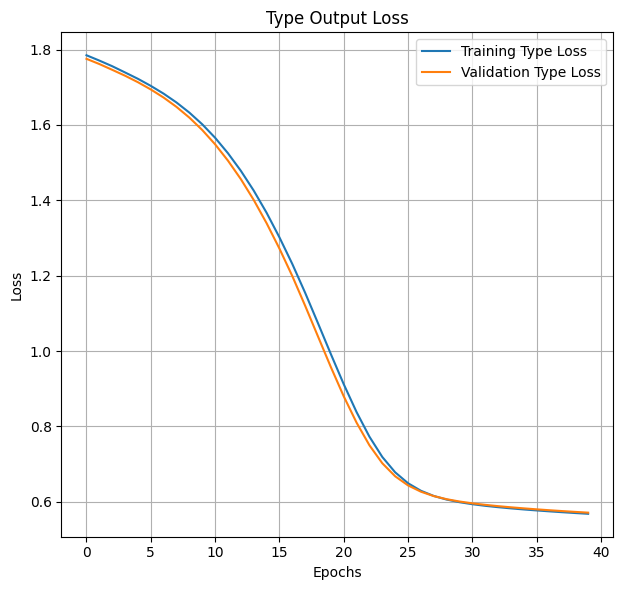

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━

In [ ]:
import ijson
import json
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import os
import csv
import pickle
import matplotlib.pyplot as plt

class TurnoverPredictor:
  def __init__(self, epochs=40, data=None, split_index=0):
    self.epochs = epochs
    self.game_length = 200
    self.feature_dims = 8
    self.event_label = []
    self.time_label = []
    self.load_vocabs()

    # file path leading to the trained model.
    file_path = '/content/data/Turnover_Predictor.keras'
    if not os.path.isfile(file_path):
      # if the file doesn't exists (aka this is the first time running this function)
      # then begin the preprocessing to get it ready for training.
      print("no model file found, generating new one")
      if data is None:
        print("Data is None!")
      else:
        self.preprocess(data, split_index=split_index)
    else:
      # otherwise boot up the pre-trained model
      print("File exists. Loading model...")
      self.model = keras.models.load_model(
          file_path, custom_objects={'cast_to_float32': lambda x: tf.cast(x, tf.float32)}
      )

  # open up all of the json voacbularies that this class makes use of as enums (i think)
  def load_vocabs(self):
    self.rosters_vocab_path = '/content/data/languages/rosters_vocab.json'
    with open(self.rosters_vocab_path, 'r') as f:
        self.rosters_vocab = json.load(f)

    self.player_vocab_path = '/content/data/languages/player_vocab.json'
    with open(self.player_vocab_path, 'r') as f:
        self.player_vocab = json.load(f)

    self.event_vocab_path = '/content/data/languages/event_vocab.json'
    with open(self.event_vocab_path, 'r') as f:
        self.event_vocab = json.load(f)

    self.type_vocab_path = '/content/data/languages/type_vocab.json'
    with open(self.type_vocab_path, 'r') as f:
        self.type_vocab = json.load(f)

    self.result_vocab_path = '/content/data/languages/result_vocab.json'
    with open(self.result_vocab_path, 'r') as f:
        self.result_vocab = json.load(f)

    self.season_vocab_path = '/content/data/languages/season_vocab.json'
    with open(self.season_vocab_path, 'r') as f:
        self.season_vocab = json.load(f)


  def preprocess(self, data, split_index):
    # Normalize time
    self.max_time = data['time'].max()
    data['time_normalized'] = data['time'] / self.max_time

    gameId = data['gameId'].values
    roster1 = data['roster1'].values
    roster2 = data['roster2'].values
    time = data['time'].values
    time_normalized = data['time_normalized'].values
    event = data['event'].values
    player = data['player'].values
    type_val = data['type'].values
    result = data['result'].values
    season = data['season'].values
    playoff = data['playoff'].values

    # Split the games at their start token
    gameIds = np.split(gameId.tolist(), (data.index[data['event'] == 1]).tolist())
    rotations1 = np.split(roster1.tolist(), (data.index[data['event'] == 1]).tolist())
    rotations2 = np.split(roster2.tolist(), (data.index[data['event'] == 1]).tolist())
    times = np.split(time.tolist(), (data.index[data['event'] == 1]).tolist())
    times_normalized = np.split(time_normalized.tolist(), (data.index[data['event'] == 1]).tolist())
    events = np.split(event.tolist(), (data.index[data['event'] == 1]).tolist())
    players = np.split(player.tolist(), (data.index[data['event'] == 1]).tolist())
    type_vals = np.split(type_val.tolist(), (data.index[data['event'] == 1]).tolist())
    results = np.split(result.tolist(), (data.index[data['event'] == 1]).tolist())
    seasons = np.split(season.tolist(), (data.index[data['event'] == 1]).tolist())
    playoffs = np.split(playoff.tolist(), (data.index[data['event'] == 1]).tolist())

    self.gameId_inputs = []
    self.roster1_inputs = []
    self.roster2_inputs = []
    self.time_inputs = []
    self.event_inputs = []
    self.player_inputs = []
    self.type_inputs = []
    self.result_inputs = []
    self.season_inputs = []
    self.playoff_inputs = []

    # remove the first set of values
    gameIds.pop(0)
    rotations1.pop(0)
    rotations2.pop(0)
    times.pop(0)
    times_normalized.pop(0)
    events.pop(0)
    players.pop(0)
    type_vals.pop(0)
    results.pop(0)
    seasons.pop(0)
    playoffs.pop(0)

    #run through each event and remove all events that aren't turnovers by using a mask
    for i in range(len(gameIds)):
      length = len(gameIds[i])
      if length > 0:
        mask = (np.array(events[i]) == 1) | (np.array(events[i]) == 4)
        gameIds[i] = np.array(gameIds[i])[mask].tolist()
        rotations1[i] = np.array(rotations1[i])[mask].tolist()
        rotations2[i] = np.array(rotations2[i])[mask].tolist()
        times[i] = np.array(times[i])[mask].tolist()
        times_normalized[i] = np.array(times_normalized[i])[mask].tolist()
        events[i] = np.array(events[i])[mask].tolist()
        players[i] = np.array(players[i])[mask].tolist()
        type_vals[i] = np.array(type_vals[i])[mask].tolist()
        results[i] = np.array(results[i])[mask].tolist()
        seasons[i] = np.array(seasons[i])[mask].tolist()
        playoffs[i] = np.array(playoffs[i])[mask].tolist()

    def map_values(x):
        if x > 2:
            return x - 14
        else:
            return x

    for i in range(len(gameIds)):
      length = len(gameIds[i])
      if length > 0:
        type_vals[i] = [map_values(x) for x in type_vals[i]]

        # Pad inputs
        self.gameId_inputs.append(np.pad(gameIds[i], (0, self.game_length - length), mode='constant'))
        self.roster1_inputs.append(np.pad(rotations1[i], (0, self.game_length - length), mode='constant'))
        self.roster2_inputs.append(np.pad(rotations2[i], (0, self.game_length - length), mode='constant'))
        self.time_inputs.append(np.pad(times_normalized[i], (0, self.game_length - length), mode='constant'))
        self.event_inputs.append(np.pad(events[i], (0, self.game_length - length), mode='constant'))
        self.player_inputs.append(np.pad(players[i], (0, self.game_length - length), mode='constant'))
        self.type_inputs.append(np.pad(type_vals[i], (0, self.game_length - length), mode='constant'))
        self.result_inputs.append(np.pad(results[i], (0, self.game_length - length), mode='constant'))
        self.season_inputs.append(np.pad(seasons[i], (0, self.game_length - length), mode='constant'))
        self.playoff_inputs.append(np.pad(playoffs[i], (0, self.game_length - length), mode='constant'))


    split_index = int(len(self.gameId_inputs) * split_index)
    print("Split_index: ", split_index)

    #split training and testing data

    train_gameIds = self.gameId_inputs[:split_index]
    train_roster1 = self.roster1_inputs[:split_index]
    train_roster2 = self.roster2_inputs[:split_index]
    train_time = self.time_inputs[:split_index]
    train_event = self.event_inputs[:split_index]
    train_player = self.player_inputs[:split_index]
    train_type = self.type_inputs[:split_index]
    train_result = self.result_inputs[:split_index]
    train_season = self.season_inputs[:split_index]
    train_playoff = self.playoff_inputs[:split_index]

    test_gameIds = self.gameId_inputs[split_index:]
    test_roster1 = self.roster1_inputs[split_index:]
    test_roster2 = self.roster2_inputs[split_index:]
    test_time = self.time_inputs[split_index:]
    test_event = self.event_inputs[split_index:]
    test_player = self.player_inputs[split_index:]
    test_type = self.type_inputs[split_index:]
    test_result = self.result_inputs[split_index:]
    test_season = self.season_inputs[split_index:]
    test_playoff = self.playoff_inputs[split_index:]

    # Input arrays
    self.train_gameIds_inputs = np.array(train_gameIds[:-1])
    self.train_roster1_inputs = np.array(train_roster1[1:])
    self.train_roster2_inputs = np.array(train_roster2[1:])
    self.train_time_inputs = np.array(train_time[:-1])
    self.train_event_inputs = np.array(train_event[:-1])
    self.train_player_inputs = np.array(train_player[:-1])
    self.train_type_inputs = np.array(train_type[:-1])
    self.train_result_inputs = np.array(train_result[:-1])
    self.train_season_inputs = np.array(train_season[:-1])
    self.train_playoff_inputs = np.array(train_playoff[:-1])
    self.train_current_player_inputs = np.array(train_player[1:])

    # Y data
    self.type_label = np.array(train_type[1:])

    # Test arrays
    self.test_gameIds_inputs = np.array(test_gameIds[:-1])
    self.test_roster1_inputs = np.array(test_roster1[1:])
    self.test_roster2_inputs = np.array(test_roster2[1:])
    self.test_time_inputs = np.array(test_time[:-1])
    self.test_event_inputs = np.array(test_event[:-1])
    self.test_player_inputs = np.array(test_player[:-1])
    self.test_type_inputs = np.array(test_type[:-1])
    self.test_result_inputs = np.array(test_result[:-1])
    self.test_season_inputs = np.array(test_season[:-1])
    self.test_playoff_inputs = np.array(test_playoff[:-1])
    self.test_current_player_inputs = np.array(test_player[1:])

    # Test labels
    self.type_test_label = np.array(test_type[1:])

    self.fit();

  def fit(self):
    lstm_units = 128
    feature_dim = 52

    # Input Layers
    roster1 = tf.keras.layers.Input(shape=(self.game_length, 1), name='roster1')
    roster2 = tf.keras.layers.Input(shape=(self.game_length, 1), name='roster2')
    time = tf.keras.layers.Input(shape=(self.game_length, 1), name='time')
    player = tf.keras.layers.Input(shape=(self.game_length, 1), name='player')
    current_player = tf.keras.layers.Input(shape=(self.game_length, 1), name='current_player')
    result = tf.keras.layers.Input(shape=(self.game_length, 1), name='result')
    season = tf.keras.layers.Input(shape=(self.game_length, 1), name='season')
    playoff = tf.keras.layers.Input(shape=(self.game_length, 1), name='playoff')

    # Embedding Layers with Masking
    roster1_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster1)
    roster2_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster2)
    player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(player)
    current_player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(current_player)

    # Reshape Embeddings
    roster1_reshape = tf.keras.layers.Reshape((self.game_length, 16))(roster1_embedding)
    roster2_reshape = tf.keras.layers.Reshape((self.game_length, 16))(roster2_embedding)
    player_reshape = tf.keras.layers.Reshape((self.game_length, 16))(player_embedding)
    current_player_reshape = tf.keras.layers.Reshape((self.game_length, 16))(current_player_embedding)

    # Masking for Non-Embedding Inputs
    time_masked = tf.keras.layers.Masking(mask_value=0.0)(time)
    result_masked = tf.keras.layers.Masking(mask_value=0.0)(result)

    # Cast to ensure numeric data types
    def cast_to_float32(x):
        return tf.cast(x, tf.float32)

    time_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(time_masked)
    result_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(result_masked)
    season_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(season)
    playoff_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(playoff)

    all_inputs = tf.keras.layers.Concatenate(axis=-1)([
            roster1_reshape,
            roster2_reshape,
            time_cast,
            player_reshape,
            result_cast,
            season_cast,
            playoff_cast,
            current_player_reshape
        ])

    print("all inputs shape: ", all_inputs.shape)

    # LSTM Layer
    lstm_output = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(all_inputs)

    # Attention Layer with Mask
    plays_attention = tf.keras.layers.MultiHeadAttention(
        num_heads=4, key_dim=lstm_units
    )(lstm_output, lstm_output)

    # Outputs
    turnover_type_output = tf.keras.layers.Dense(6, activation='softmax', name='turnover_output')(plays_attention)

    # Model Definition
    self.model = tf.keras.Model(
        inputs=[roster1, roster2, time, player, result, season, playoff, current_player],
        outputs=[turnover_type_output]
    )

    self.model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, clipnorm=1.0),
        loss={
            'turnover_output': 'sparse_categorical_crossentropy',
        },
        metrics={
            'turnover_output': 'accuracy',
        }
     )

    # Callback to track individual losses
    class LossHistory(tf.keras.callbacks.Callback):
        def on_train_begin(self, logs=None):
            self.type_loss = []
            self.val_type_loss = []

        def on_epoch_end(self, epoch, logs=None):
            self.type_loss.append(logs['loss'])
            self.val_type_loss.append(logs['val_loss'])

    loss_history = LossHistory()

    self.model.summary()

    # Train the model
    self.model.fit(
        x={
                'time': self.train_time_inputs,
                'roster1': self.train_roster1_inputs,
                'roster2': self.train_roster2_inputs,
                'player': self.train_player_inputs,
                'result': self.train_result_inputs,
                'season': self.train_season_inputs,
                'playoff': self.train_playoff_inputs,
                'current_player': self.train_current_player_inputs
        },
        y={
             'turnover_output': self.type_label,
         },
         validation_split=0.2,
         epochs=self.epochs,
         batch_size=16,
         callbacks=[loss_history]
    )
    # Plot individual losses
    plt.figure(figsize=(12, 6))

    # Type Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_history.type_loss, label='Training Type Loss')
    plt.plot(loss_history.val_type_loss, label='Validation Type Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Type Output Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    self.model.save('/content/data/Turnover_Predictor.keras')

  def sample_turnover(self, probabilities, valid_indices=[2, 3, 4, 5]):
      probabilities = np.array(probabilities, dtype=np.float64)

      # Mask probabilities to include only valid indices
      mask = np.zeros_like(probabilities, dtype=bool)
      mask[valid_indices] = True
      probabilities = probabilities * mask

      # Normalize probabilities over valid indices
      probabilities = probabilities / np.sum(probabilities)

      # Sample from valid indices
      return np.random.choice(valid_indices, p=probabilities[valid_indices])

  def predict_turnover_type(self, input_data, valid_indices=[2, 3, 4, 5]):
        roster1_input = input_data['roster1']
        roster2_input = input_data['roster2']
        current_player_input = input_data['current_player']
        time_input = input_data['time']
        event_type_input = input_data['type']
        result_input = input_data['result']
        season_input = input_data['season']
        playoff_input = input_data['playoff']

        length = len(roster1_input)

        # Pad inputs to match the game length
        roster1_input = np.pad(roster1_input, (0, self.game_length - length), mode='constant')
        roster2_input = np.pad(roster2_input, (0, self.game_length - length), mode='constant')
        current_player_input = np.pad(current_player_input, (0, self.game_length - length), mode='constant')
        time_input = np.pad(time_input, (0, self.game_length - length), mode='constant')
        event_type_input = np.pad(event_type_input, (0, self.game_length - length), mode='constant')
        result_input = np.pad(result_input, (0, self.game_length - length), mode='constant')
        season_input = np.pad(season_input, (0, self.game_length - length), mode='constant')
        playoff_input = np.pad(playoff_input, (0, self.game_length - length), mode='constant')

        # Create input dictionary for prediction
        input_data_dict = {
            'roster1': np.array([roster1_input]),
            'roster2': np.array([roster2_input]),
            'current_player': np.array([current_player_input]),
            'player': np.array([current_player_input]),
            'time': np.array([time_input]),
            'type': np.array([event_type_input]),
            'result': np.array([result_input]),
            'season': np.array([season_input]),
            'playoff': np.array([playoff_input])
        }

        # Predict using the model
        output = self.model.predict(input_data_dict, batch_size=1, verbose=0)

        # Sample shot type from probabilities
        turnover_type_output = self.sample_turnover(output[0][length - 1], valid_indices)
        return turnover_type_output

  def train(self):
      correct_type = 0
      total_type = 0

      real_time = []
      predicted_time = []

      for i, game in enumerate(self.test_roster1_inputs):
          # Predict the outputs for the first test input (batch size of 1)
          test_input = {
                  'roster1': self.test_roster1_inputs[i].reshape(1, self.game_length, 1),
                  'roster2': self.test_roster2_inputs[i].reshape(1, self.game_length, 1),
                  'time': self.test_time_inputs[i].reshape(1, self.game_length, 1),
                  'player': self.test_player_inputs[i].reshape(1, self.game_length, 1),
                  'result': self.test_result_inputs[i].reshape(1, self.game_length, 1),
                  'season': self.test_season_inputs[i].reshape(1, self.game_length, 1),
                  'playoff': self.test_playoff_inputs[i].reshape(1, self.game_length, 1),
                  'current_player': self.test_current_player_inputs[i].reshape(1, self.game_length, 1)
          }

          # Perform prediction
          test_output = self.model.predict(test_input, batch_size=1)

          # Extract the type and time outputs
          type_output = test_output[0]

          real_type_label = self.type_test_label[i]

          # Process type output
          for j, prediction in enumerate(type_output):
              if real_type_label[j] != 0:
                  type_prediction = self.sample_turnover(prediction)

                  if type_prediction == real_type_label[j]:
                      correct_type += 1

                  total_type += 1

      print("Accuracy:", correct_type/total_type)

def read_file(file_path):
    data = {'gameId': [], 'roster1': [], 'roster2': [], 'time': [], 'event': [], 'player': [], 'type': [], 'result': [], 'season': [], 'playoff': []}

    with open(file_path, 'r') as file:
        items = ijson.items(file, 'item')
        for line in tqdm(items, desc="Processing file", unit="line"):
            for item in line:
                data['gameId'].append(item['gameId'])
                data['roster1'].append(rosters_vocab[hash_roster(item['roster1'])])
                data['roster2'].append(rosters_vocab[hash_roster(item['roster2'])])
                data['time'].append(item['time'])
                data['event'].append(event_vocab[item['event']])
                data['player'].append(player_vocab[item['player']])
                data['type'].append(type_vocab[item['type']])
                data['result'].append(result_vocab[item['result']])
                data['season'].append(season_vocab[item['season']])
                data['playoff'].append(item['playoff'])
    return pd.DataFrame(data)

data = read_file('/content/data/NBADATA.json')

TurnoverPredictorFile = '/content/data/Turnover_Predictor.pkl'

input_data = {
    'roster1': [1],
    'roster2': [1],
    'time': [1],
    'event': [1],
    'player': [1],
    'type': [1],
    'result': [1],
    'season': [1],
    'playoff': [1],
    'current_player': [2]
}

# Create an instance of TurnoverPredictor
predictor = TurnoverPredictor(data=data, split_index=0.9)
print(predictor.predict_turnover_type(input_data))
predictor.predict()


# Substitution Model

In [ ]:
import ijson
import json
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import os
import csv
import pickle
import matplotlib.pyplot as plt

class SubstitutionPredictor:
  def __init__(self, epochs=60, data=None, split_index=0):
    self.epochs = epochs
    self.game_length = 200
    self.feature_dims = 8
    self.event_label = []
    self.time_label = []
    self.load_vocabs()

    # file path leading to the trained model.
    file_path = '/content/data/Substitution_Predictor.keras'
    if not os.path.isfile(file_path):
      # if the file doesn't exists (aka this is the first time running this function)
      # then begin the preprocessing to get it ready for training.
      print("no model file found, generating new one")
      if data is None:
        print("Data is None!")
      else:
        self.preprocess(data, split_index=split_index)
    else:
      # otherwise boot up the pre-trained model
      print("File exists. Loading model...")
      self.model = keras.models.load_model(
          file_path, custom_objects={'cast_to_float32': lambda x: tf.cast(x, tf.float32)}
      )

  # open up all of the json voacbularies that this class makes use of as enums (i think)
  def load_vocabs(self):
    self.rosters_vocab_path = '/content/data/languages/rosters_vocab.json'
    with open(self.rosters_vocab_path, 'r') as f:
        self.rosters_vocab = json.load(f)

    self.player_vocab_path = '/content/data/languages/player_vocab.json'
    with open(self.player_vocab_path, 'r') as f:
        self.player_vocab = json.load(f)

    self.event_vocab_path = '/content/data/languages/event_vocab.json'
    with open(self.event_vocab_path, 'r') as f:
        self.event_vocab = json.load(f)

    self.type_vocab_path = '/content/data/languages/type_vocab.json'
    with open(self.type_vocab_path, 'r') as f:
        self.type_vocab = json.load(f)

    self.result_vocab_path = '/content/data/languages/result_vocab.json'
    with open(self.result_vocab_path, 'r') as f:
        self.result_vocab = json.load(f)

    self.season_vocab_path = '/content/data/languages/season_vocab.json'
    with open(self.season_vocab_path, 'r') as f:
        self.season_vocab = json.load(f)


  def preprocess(self, data, split_index):
    # Normalize time
    self.max_time = data['time'].max()
    data['time_normalized'] = data['time'] / self.max_time

    gameId = data['gameId'].values
    roster1 = data['roster1'].values
    roster2 = data['roster2'].values
    time = data['time'].values
    time_normalized = data['time_normalized'].values
    event = data['event'].values
    player = data['player'].values
    type_val = data['type'].values
    result = data['result'].values
    season = data['season'].values
    playoff = data['playoff'].values

    # Split the games at their start token
    gameIds = np.split(gameId.tolist(), (data.index[data['event'] == 1]).tolist())
    rotations1 = np.split(roster1.tolist(), (data.index[data['event'] == 1]).tolist())
    rotations2 = np.split(roster2.tolist(), (data.index[data['event'] == 1]).tolist())
    times = np.split(time.tolist(), (data.index[data['event'] == 1]).tolist())
    times_normalized = np.split(time_normalized.tolist(), (data.index[data['event'] == 1]).tolist())
    events = np.split(event.tolist(), (data.index[data['event'] == 1]).tolist())
    players = np.split(player.tolist(), (data.index[data['event'] == 1]).tolist())
    type_vals = np.split(type_val.tolist(), (data.index[data['event'] == 1]).tolist())
    results = np.split(result.tolist(), (data.index[data['event'] == 1]).tolist())
    seasons = np.split(season.tolist(), (data.index[data['event'] == 1]).tolist())
    playoffs = np.split(playoff.tolist(), (data.index[data['event'] == 1]).tolist())

    self.gameId_inputs = []
    self.roster1_inputs = []
    self.roster2_inputs = []
    self.time_inputs = []
    self.event_inputs = []
    self.player_inputs = []
    self.type_inputs = []
    self.result_inputs = []
    self.season_inputs = []
    self.playoff_inputs = []

    # remove the first set of values
    gameIds.pop(0)
    rotations1.pop(0)
    rotations2.pop(0)
    times.pop(0)
    times_normalized.pop(0)
    events.pop(0)
    players.pop(0)
    type_vals.pop(0)
    results.pop(0)
    seasons.pop(0)
    playoffs.pop(0)

    #run through each event and remove all events that aren't substitutions by using a mask
    for i in range(len(gameIds)):
      length = len(gameIds[i])
      if length > 0:
        mask = (np.array(events[i]) == 1) | (np.array(events[i]) == 8)
        gameIds[i] = np.array(gameIds[i])[mask].tolist()
        rotations1[i] = np.array(rotations1[i])[mask].tolist()
        rotations2[i] = np.array(rotations2[i])[mask].tolist()
        times[i] = np.array(times[i])[mask].tolist()
        times_normalized[i] = np.array(times_normalized[i])[mask].tolist()
        events[i] = np.array(events[i])[mask].tolist()
        players[i] = np.array(players[i])[mask].tolist()
        type_vals[i] = np.array(type_vals[i])[mask].tolist()
        results[i] = np.array(results[i])[mask].tolist()
        seasons[i] = np.array(seasons[i])[mask].tolist()
        playoffs[i] = np.array(playoffs[i])[mask].tolist()

    def map_values(x):
        if x > 2:
            return x - 20
        else:
            return x

    for i in range(len(gameIds)):
      length = len(gameIds[i])
      if length > 0:
        type_vals[i] = [map_values(x) for x in type_vals[i]]

        # Pad inputs
        self.gameId_inputs.append(np.pad(gameIds[i], (0, self.game_length - length), mode='constant'))
        self.roster1_inputs.append(np.pad(rotations1[i], (0, self.game_length - length), mode='constant'))
        self.roster2_inputs.append(np.pad(rotations2[i], (0, self.game_length - length), mode='constant'))
        self.time_inputs.append(np.pad(times_normalized[i], (0, self.game_length - length), mode='constant'))
        self.event_inputs.append(np.pad(events[i], (0, self.game_length - length), mode='constant'))
        self.player_inputs.append(np.pad(players[i], (0, self.game_length - length), mode='constant'))
        self.type_inputs.append(np.pad(type_vals[i], (0, self.game_length - length), mode='constant'))
        self.result_inputs.append(np.pad(results[i], (0, self.game_length - length), mode='constant'))
        self.season_inputs.append(np.pad(seasons[i], (0, self.game_length - length), mode='constant'))
        self.playoff_inputs.append(np.pad(playoffs[i], (0, self.game_length - length), mode='constant'))


    split_index = int(len(self.gameId_inputs) * split_index)
    print("Split_index: ", split_index)

    #split training and testing data

    train_gameIds = self.gameId_inputs[:split_index]
    train_roster1 = self.roster1_inputs[:split_index]
    train_roster2 = self.roster2_inputs[:split_index]
    train_time = self.time_inputs[:split_index]
    train_event = self.event_inputs[:split_index]
    train_player = self.player_inputs[:split_index]
    train_type = self.type_inputs[:split_index]
    train_result = self.result_inputs[:split_index]
    train_season = self.season_inputs[:split_index]
    train_playoff = self.playoff_inputs[:split_index]

    test_gameIds = self.gameId_inputs[split_index:]
    test_roster1 = self.roster1_inputs[split_index:]
    test_roster2 = self.roster2_inputs[split_index:]
    test_time = self.time_inputs[split_index:]
    test_event = self.event_inputs[split_index:]
    test_player = self.player_inputs[split_index:]
    test_type = self.type_inputs[split_index:]
    test_result = self.result_inputs[split_index:]
    test_season = self.season_inputs[split_index:]
    test_playoff = self.playoff_inputs[split_index:]

    # Input arrays
    self.train_gameIds_inputs = np.array(train_gameIds[:-1])
    self.train_roster1_inputs = np.array(train_roster1[1:])
    self.train_roster2_inputs = np.array(train_roster2[1:])
    self.train_time_inputs = np.array(train_time[:-1])
    self.train_event_inputs = np.array(train_event[:-1])
    self.train_player_inputs = np.array(train_player[:-1])
    self.train_type_inputs = np.array(train_type[:-1])
    self.train_result_inputs = np.array(train_result[:-1])
    self.train_season_inputs = np.array(train_season[:-1])
    self.train_playoff_inputs = np.array(train_playoff[:-1])
    self.train_current_player_inputs = np.array(train_player[1:])

    # Y data
    self.type_label = np.array(train_type[1:])

    # Test arrays
    self.test_gameIds_inputs = np.array(test_gameIds[:-1])
    self.test_roster1_inputs = np.array(test_roster1[1:])
    self.test_roster2_inputs = np.array(test_roster2[1:])
    self.test_time_inputs = np.array(test_time[:-1])
    self.test_event_inputs = np.array(test_event[:-1])
    self.test_player_inputs = np.array(test_player[:-1])
    self.test_type_inputs = np.array(test_type[:-1])
    self.test_result_inputs = np.array(test_result[:-1])
    self.test_season_inputs = np.array(test_season[:-1])
    self.test_playoff_inputs = np.array(test_playoff[:-1])
    self.test_current_player_inputs = np.array(test_player[1:])

    # Test labels
    self.type_test_label = np.array(test_type[1:])

    self.fit();

  def fit(self):
    lstm_units = 128
    feature_dim = 52

    # Input Layers
    roster1 = tf.keras.layers.Input(shape=(self.game_length, 1), name='roster1')
    roster2 = tf.keras.layers.Input(shape=(self.game_length, 1), name='roster2')
    time = tf.keras.layers.Input(shape=(self.game_length, 1), name='time')
    player = tf.keras.layers.Input(shape=(self.game_length, 1), name='player')
    current_player = tf.keras.layers.Input(shape=(self.game_length, 1), name='current_player')
    result = tf.keras.layers.Input(shape=(self.game_length, 1), name='result')
    season = tf.keras.layers.Input(shape=(self.game_length, 1), name='season')
    playoff = tf.keras.layers.Input(shape=(self.game_length, 1), name='playoff')

    # Embedding Layers with Masking
    roster1_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster1)
    roster2_embedding = tf.keras.layers.Embedding(input_dim=len(self.rosters_vocab)+1, output_dim=16, mask_zero=True)(roster2)
    player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(player)
    current_player_embedding = tf.keras.layers.Embedding(input_dim=len(self.player_vocab)+1, output_dim=16, mask_zero=True)(current_player)

    # Reshape Embeddings
    roster1_reshape = tf.keras.layers.Reshape((self.game_length, 16))(roster1_embedding)
    roster2_reshape = tf.keras.layers.Reshape((self.game_length, 16))(roster2_embedding)
    player_reshape = tf.keras.layers.Reshape((self.game_length, 16))(player_embedding)
    current_player_reshape = tf.keras.layers.Reshape((self.game_length, 16))(current_player_embedding)

    # Masking for Non-Embedding Inputs
    time_masked = tf.keras.layers.Masking(mask_value=0.0)(time)
    result_masked = tf.keras.layers.Masking(mask_value=0.0)(result)

    # Cast to ensure numeric data types
    def cast_to_float32(x):
        return tf.cast(x, tf.float32)

    time_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(time_masked)
    result_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(result_masked)
    season_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(season)
    playoff_cast = tf.keras.layers.Lambda(cast_to_float32, output_shape=(self.game_length, 1))(playoff)

    all_inputs = tf.keras.layers.Concatenate(axis=-1)([
            roster1_reshape,
            roster2_reshape,
            time_cast,
            player_reshape,
            result_cast,
            season_cast,
            playoff_cast,
            current_player_reshape
        ])

    print("all inputs shape: ", all_inputs.shape)

    # LSTM Layer
    lstm_output = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(all_inputs)

    # Attention Layer with Mask
    plays_attention = tf.keras.layers.MultiHeadAttention(
        num_heads=4, key_dim=lstm_units
    )(lstm_output, lstm_output)

    # Outputs
    substitution_type_output = tf.keras.layers.Dense(len(type_vocab) - 19, activation='softmax', name='substitution_output')(plays_attention)

    # Model Definition
    self.model = tf.keras.Model(
        inputs=[roster1, roster2, time, player, result, season, playoff, current_player],
        outputs=[substitution_type_output]
    )

    self.model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, clipnorm=1.0),
        loss={
            'substitution_output': 'sparse_categorical_crossentropy',
        },
        metrics={
            'substitution_output': 'accuracy',
        }
     )

    # Callback to track individual losses
    class LossHistory(tf.keras.callbacks.Callback):
        def on_train_begin(self, logs=None):
            self.type_loss = []
            self.val_type_loss = []

        def on_epoch_end(self, epoch, logs=None):
            self.type_loss.append(logs['loss'])
            self.val_type_loss.append(logs['val_loss'])

    loss_history = LossHistory()

    self.model.summary()

    # Train the model
    self.model.fit(
        x={
                'time': self.train_time_inputs,
                'roster1': self.train_roster1_inputs,
                'roster2': self.train_roster2_inputs,
                'player': self.train_player_inputs,
                'result': self.train_result_inputs,
                'season': self.train_season_inputs,
                'playoff': self.train_playoff_inputs,
                'current_player': self.train_current_player_inputs
        },
        y={
             'substitution_output': self.type_label,
         },
         validation_split=0.2,
         epochs=self.epochs,
         batch_size=16,
         callbacks=[loss_history]
    )
    # Plot individual losses
    plt.figure(figsize=(12, 6))

    # Type Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_history.type_loss, label='Training Type Loss')
    plt.plot(loss_history.val_type_loss, label='Validation Type Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Type Output Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    self.model.save('/content/data/Substitution_Predictor.keras')

  def predict_sub(self, input_data, valid_indices=[2, 3, 4, 5]):
        roster1_input = input_data['roster1']
        roster2_input = input_data['roster2']
        current_player_input = input_data['current_player']
        time_input = input_data['time']
        event_type_input = input_data['type']
        result_input = input_data['result']
        season_input = input_data['season']
        playoff_input = input_data['playoff']

        length = len(roster1_input)

        # Pad inputs to match the game length
        roster1_input = np.pad(roster1_input, (0, self.game_length - length), mode='constant')
        roster2_input = np.pad(roster2_input, (0, self.game_length - length), mode='constant')
        current_player_input = np.pad(current_player_input, (0, self.game_length - length), mode='constant')
        time_input = np.pad(time_input, (0, self.game_length - length), mode='constant')
        event_type_input = np.pad(event_type_input, (0, self.game_length - length), mode='constant')
        result_input = np.pad(result_input, (0, self.game_length - length), mode='constant')
        season_input = np.pad(season_input, (0, self.game_length - length), mode='constant')
        playoff_input = np.pad(playoff_input, (0, self.game_length - length), mode='constant')

        # Create input dictionary for prediction
        input_data_dict = {
            'roster1': np.array([roster1_input]),
            'roster2': np.array([roster2_input]),
            'current_player': np.array([current_player_input]),
            'player': np.array([current_player_input]),
            'time': np.array([time_input]),
            'type': np.array([event_type_input]),
            'result': np.array([result_input]),
            'season': np.array([season_input]),
            'playoff': np.array([playoff_input])
        }

        # Predict using the model
        output = self.model.predict(input_data_dict, batch_size=1, verbose=0)

        # Sample shot type from probabilities
        substitute_output = self.sample_substitution(output[0][length - 1], valid_indices)
        return substitute_output

  def sample_substitution(self, probabilities, valid_indices=[2, 3, 4, 5]):
      probabilities = np.array(probabilities, dtype=np.float64)

      # Mask probabilities to include only valid indices
      mask = np.zeros_like(probabilities, dtype=bool)
      mask[valid_indices] = True
      probabilities = probabilities * mask

      # Normalize probabilities over valid indices
      probabilities = probabilities / np.sum(probabilities)

      # Sample from valid indices
      return np.random.choice(valid_indices, p=probabilities[valid_indices])


  def train(self):
      correct_type = 0
      total_type = 0

      real_time = []
      predicted_time = []

      for i, game in enumerate(self.test_roster1_inputs):
          # Predict the outputs for the first test input (batch size of 1)
          test_input = {
                  'roster1': self.test_roster1_inputs[i].reshape(1, self.game_length, 1),
                  'roster2': self.test_roster2_inputs[i].reshape(1, self.game_length, 1),
                  'time': self.test_time_inputs[i].reshape(1, self.game_length, 1),
                  'player': self.test_player_inputs[i].reshape(1, self.game_length, 1),
                  'result': self.test_result_inputs[i].reshape(1, self.game_length, 1),
                  'season': self.test_season_inputs[i].reshape(1, self.game_length, 1),
                  'playoff': self.test_playoff_inputs[i].reshape(1, self.game_length, 1),
                  'current_player': self.test_current_player_inputs[i].reshape(1, self.game_length, 1)
          }

          # Perform prediction
          test_output = self.model.predict(test_input, batch_size=1)

          # Extract the type and time outputs
          type_output = test_output[0]

          real_type_label = self.type_test_label[i]

          # Process type output
          for j, prediction in enumerate(type_output):
              if real_type_label[j] != 0:
                  # TODO: Fix the valid_indices for predict
                  type_prediction = self.sample_substitution(prediction, [2, 3])

                  if type_prediction == real_type_label[j]:
                      correct_type += 1

                  total_type += 1

      print("Accuracy:", correct_type/total_type)

def read_file(file_path):
    data = {'gameId': [], 'roster1': [], 'roster2': [], 'time': [], 'event': [], 'player': [], 'type': [], 'result': [], 'season': [], 'playoff': []}

    with open(file_path, 'r') as file:
        items = ijson.items(file, 'item')
        for line in tqdm(items, desc="Processing file", unit="line"):
            for item in line:
                data['gameId'].append(item['gameId'])
                data['roster1'].append(rosters_vocab[hash_roster(item['roster1'])])
                data['roster2'].append(rosters_vocab[hash_roster(item['roster2'])])
                data['time'].append(item['time'])
                data['event'].append(event_vocab[item['event']])
                data['player'].append(player_vocab[item['player']])
                data['type'].append(type_vocab[item['type']])
                data['result'].append(result_vocab[item['result']])
                data['season'].append(season_vocab[item['season']])
                data['playoff'].append(item['playoff'])
    return pd.DataFrame(data)

data = read_file('/content/data/NBADATA.json')

SubstitutionPredictorFile = '/content/data/Substitution_Predictor.pkl'

input_data = {
    'roster1': [1],
    'roster2': [1],
    'time': [1],
    'event': [1],
    'player': [1],
    'type': [1],
    'result': [1],
    'season': [1],
    'playoff': [1],
    'current_player': [2]
}

# Create an instance of SubstitutionPredictor
predictor = SubstitutionPredictor(data=data, split_index=0.9)
print(predictor.predict_sub(input_data))
predictor.predict()


Processing file: 1700line [00:12, 135.22line/s]


File exists. Loading model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_28' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_29' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'lambda_32' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5


AttributeError: 'SubstitutionPredictor' object has no attribute 'test_roster1_inputs'

# Shot Result Predictor Neural Network

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import ijson

class ShotResultNeuralNetwork:
    def __init__(self, data, split_index):
        self.data = data
        self.split_index = split_index

    def preprocess(self):
        # Normalize 'time'
        scaler = StandardScaler()
        time_column = scaler.fit_transform(self.data[['time']]).astype(np.float32)

        # Separate target column before preprocessing
        y = self.data['result']

        # One-hot encode categorical features
        categorical_features = ['type', 'season', 'player']
        categorical_data = pd.get_dummies(self.data[categorical_features], drop_first=True)

        # Combine normalized numerical features with encoded categorical features
        X = categorical_data

        # One-hot encode the target column
        y = pd.get_dummies(y).to_numpy()

        # Split into training and testing sets
        self.X_train, self.X_test = X.iloc[:self.split_index].to_numpy(), X.iloc[self.split_index:].to_numpy()
        self.y_train, self.y_test = y[:self.split_index], y[self.split_index:]

        # Split self.y_test into two halves
        half_index = len(self.y_test) // 2
        self.X_test_data = self.y_test[half_index:]
        self.y_test_data = self.y_test[half_index:]
        self.X_test = self.X_test[half_index:]
        self.y_test = self.y_test[:half_index]

        # # PCA for 'team' and 'defense'
        # defense_features_scaled = scaler.fit_transform(pd.DataFrame(self.data['defense'].tolist()))
        # team_features_scaled = scaler.fit_transform(pd.DataFrame(self.data['team'].tolist()))

        # pca = PCA(n_components=1)
        # self.data['defense'] = pca.fit_transform(defense_features_scaled)
        # self.data['team'] = pca.fit_transform(team_features_scaled)

        print(self.data.dtypes)

    def fit(self, epochs=50, batch_size=32):
        # Define the neural network
        self.model = Sequential([
            Dense(64, input_dim=self.X_train.shape[1], activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

        # Compile the model
        self.model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Print the model summary
        self.model.summary()


        # Fit the model
        history = self.model.fit(self.X_train, self.y_train,
                            validation_data=(self.X_test, self.y_test),
                            epochs=epochs,
                            batch_size=batch_size)

        # Save the model for future use
        self.model.save("Shot_Predictor_Neural_Network.keras")

        return history, self.model

    def predict(self, model_path="Shot_Predictor_Neural_Network.keras"):
        print(self.model.predict(self.X_test_data))

def read_file(file_path):
    player_vocab_path = '/content/data/languages/player_vocab.json'
    with open(player_vocab_path, 'r') as f:
        player_vocab = json.load(f)

    # add team and defense as columns
    data = {'time': [], 'event': [], 'player': [], 'type': [], 'result': [], 'season': [], 'playoff': []}

    with open(file_path, 'r') as file:
        items = ijson.items(file, 'item')
        for line in tqdm(items, desc="Processing file", unit="line"):
            for item in line:
                # NOT MESSING WITH ROSTERS

                # # Remove player from team
                # team = item['roster1'][:]
                # if player_vocab[item['player']] in team:
                #     team.remove(player_vocab[item['player']])
                #     data['defense'].append(item['roster2'])
                # else:
                #     team = item['roster2'][:]
                #     if player_vocab[item['player']] in team:
                #         team.remove(player_vocab[item['player']])
                #         data['defense'].append(item['roster1'])
                #     else:
                #         print(item['player'])
                #         print("roster1:", item['roster1'])
                #         print("roster2:", item['roster2'])
                #         print("player:", item['player'])
                #         print("player encoded:", player_vocab[item['player']])

                # data['team'].append(team)

                data['time'].append(item['time'])
                data['event'].append(item['event'])
                data['player'].append(item['player'])
                data['type'].append(item['type'])
                data['result'].append(item['result'])
                data['season'].append(item['season'])
                data['playoff'].append(item['playoff'])

    df = pd.DataFrame(data)
    df = df[df['event'] == 'shot']
    df = df[df['player'] != 'null']
    df = df.drop(columns=['event'])

    # Print unique entries in 'type' and 'result'
    print("Unique entries in 'type':", df['type'].unique())
    print("Unique entries in 'result':", df['result'].unique())

    return df

# Read the data
data = read_file('/content/data/NBADATA.json')

# Initialize the class
split_index = int(len(data) * 0.8)  # 80% for training, 20% for testing
nn = ShotResultNeuralNetwork(data, split_index)

# Preprocess the data
nn.preprocess()

# Fit the neural network
history, model = nn.fit(epochs=50, batch_size=32)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import ijson

class ShotResultNeuralNetwork:
    def __init__(self, data, split_index):
        self.data = data
        self.split_index = split_index

    def preprocess(self):
        # Normalize 'time'
        scaler = StandardScaler()
        time_column = scaler.fit_transform(self.data[['time']]).astype(np.float32)

        # Separate target column before preprocessing
        y = self.data['result']

        # One-hot encode categorical features
        categorical_features = ['type', 'season', 'player']
        categorical_data = pd.get_dummies(self.data[categorical_features], drop_first=True)

        # Combine normalized numerical features with encoded categorical features
        X = categorical_data

        # One-hot encode the target column
        y = pd.get_dummies(y).to_numpy()

        # Split into training and testing sets
        self.X_train, self.X_test = X.iloc[:self.split_index].to_numpy(), X.iloc[self.split_index:].to_numpy()
        self.y_train, self.y_test = y[:self.split_index], y[self.split_index:]
        # # PCA for 'team' and 'defense'
        # defense_features_scaled = scaler.fit_transform(pd.DataFrame(self.data['defense'].tolist()))
        # team_features_scaled = scaler.fit_transform(pd.DataFrame(self.data['team'].tolist()))

        # pca = PCA(n_components=1)
        # self.data['defense'] = pca.fit_transform(defense_features_scaled)
        # self.data['team'] = pca.fit_transform(team_features_scaled)

        print(self.data.dtypes)

    def fit(self, epochs=50, batch_size=32):
        # Define the neural network
        self.model = Sequential([
            Dense(64, input_dim=self.X_train.shape[1], activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

        # Compile the model
        self.model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Print the model summary
        self.model.summary()


        # Fit the model
        history = self.model.fit(self.X_train, self.y_train,
                            validation_data=(self.X_test, self.y_test),
                            epochs=epochs,
                            batch_size=batch_size)

        # Save the model for future use
        self.model.save("Shot_Predictor_Neural_Network.keras")

        return history, self.model

def read_file(file_path):
    player_vocab_path = '/content/data/languages/player_vocab.json'
    with open(player_vocab_path, 'r') as f:
        player_vocab = json.load(f)

    # add team and defense as columns
    data = {'time': [], 'event': [], 'player': [], 'type': [], 'result': [], 'season': [], 'playoff': []}

    with open(file_path, 'r') as file:
        items = ijson.items(file, 'item')
        for line in tqdm(items, desc="Processing file", unit="line"):
            for item in line:
                # NOT MESSING WITH ROSTERS

                # # Remove player from team
                # team = item['roster1'][:]
                # if player_vocab[item['player']] in team:
                #     team.remove(player_vocab[item['player']])
                #     data['defense'].append(item['roster2'])
                # else:
                #     team = item['roster2'][:]
                #     if player_vocab[item['player']] in team:
                #         team.remove(player_vocab[item['player']])
                #         data['defense'].append(item['roster1'])
                #     else:
                #         print(item['player'])
                #         print("roster1:", item['roster1'])
                #         print("roster2:", item['roster2'])
                #         print("player:", item['player'])
                #         print("player encoded:", player_vocab[item['player']])

                # data['team'].append(team)

                data['time'].append(item['time'])
                data['event'].append(item['event'])
                data['player'].append(item['player'])
                data['type'].append(item['type'])
                data['result'].append(item['result'])
                data['season'].append(item['season'])
                data['playoff'].append(item['playoff'])

    df = pd.DataFrame(data)
    df = df[df['event'] == 'shot']
    df = df[df['player'] != 'null']
    df = df.drop(columns=['event'])

    # Print unique entries in 'type' and 'result'
    print("Unique entries in 'type':", df['type'].unique())
    print("Unique entries in 'result':", df['result'].unique())

    return df

# Read the data
data = read_file('/content/data/NBADATA.json')

# Initialize the class
split_index = int(len(data) * 0.8)  # 80% for training, 20% for testing
nn = ShotResultNeuralNetwork(data, split_index)

# Preprocess the data
nn.preprocess()

# Fit the neural network
history, model = nn.fit(epochs=50, batch_size=32)


Processing file: 1700line [00:08, 211.59line/s]


Unique entries in 'type': ['2pt' '3pt' 'free throw']
Unique entries in 'result': ['made' 'missed' 'block']
time        int64
player     object
type       object
result     object
season     object
playoff     int64
dtype: object


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 64)                  │         114,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,739 (456.01 KB)

 Trainable params: 116,739 (456.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9115/9115 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.5809 - loss: 0.7983 - val_accuracy: 0.5824 - val_loss: 0.7835
Epoch 2/50
9115/9115 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5898 - loss: 0.7767 - val_accuracy: 0.5838 - val_loss: 0.7824
Epoch 3/50
3210/9115 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5924 - loss: 0.7748

KeyboardInterrupt: 

# Controller

Game Class

In [ ]:
import pandas as pd

class Game:
    def __init__(self, roster1, roster2, season, playoff):
        self.season = season
        self.playoff = playoff

        # List to hold inputs for the models
        self.inputs = {
            "roster1": [roster1],
            "roster2": [roster2],
            "event": [1],
            "time": [1],
            "player": [1],
            "result": [1],
            "type": [1],
            "season": [self.season],
            "playoff": [self.playoff],
            "current_event": [],
            "current_player": [],
            "current_type": []
        }

        self.load_vocabs()

    def load_vocabs(self):
        # Load vocabularies
        self.rosters_vocab_path = '/content/data/languages/rosters_vocab.json'
        with open(self.rosters_vocab_path, 'r') as f:
            self.rosters_vocab = json.load(f)

    def add_next(self, roster1, roster2, event, time, player, event_type, result):
        self.inputs['roster1'].append(roster1)
        self.inputs['roster2'].append(roster2)
        self.inputs['event'].append(event)
        self.inputs['time'].append(time)
        self.inputs['player'].append(player)
        self.inputs['type'].append(event_type)
        self.inputs['result'].append(result)
        self.inputs['season'].append(self.season)
        self.inputs['playoff'].append(self.playoff)

    def add_current_event(self, event):
        self.inputs['current_event'].append(event)

    def add_current_player(self, player):
        self.inputs['current_player'].append(player)

    def add_current_type(self, event_type):
        self.inputs['current_type'].append(event_type)


    def length(self):
        lengths = {key: len(values) for key, values in self.inputs.items()}
        if len(set(lengths.values())) > 1:
            raise ValueError(f"Inconsistent lengths in inputs: {lengths}")
        return next(iter(lengths.values()))

    # Hash function for roster
    def hash_roster(self, roster):
        if len(roster) <= 3:
            return 'start'
        prime = 31
        encoded_value = 0
        for i, num in enumerate(roster):
            encoded_value += num * (prime ** i)
        return self.rosters_vocab[str(encoded_value)]

    def event_prediction(self):
        hashed_roster1 = [self.hash_roster(roster) for roster in self.inputs['roster1']]
        hashed_roster2 = [self.hash_roster(roster) for roster in self.inputs['roster2']]

        input_data = {
            'roster1': hashed_roster1,
            'roster2': hashed_roster2,
            'time': self.inputs['time'],
            'event': self.inputs['event'],
            'player': self.inputs['player'],
            'type': self.inputs['type'],
            'result': self.inputs['result'],
            'season': self.inputs['season'],
            'playoff': self.inputs['playoff']
        }

        return input_data

    def player_prediction(self):
        hashed_roster1 = [self.hash_roster(roster) for roster in self.inputs['roster1']]
        hashed_roster2 = [self.hash_roster(roster) for roster in self.inputs['roster2']]

        input_data = {
            'current_event': self.inputs['current_event'],
            'roster1': hashed_roster1,
            'roster2': hashed_roster2,
            'time': self.inputs['time'],
            'event': self.inputs['event'],
            'player': self.inputs['player'],
            'type': self.inputs['type'],
            'result': self.inputs['result'],
            'season': self.inputs['season'],
            'playoff': self.inputs['playoff']
        }

        return input_data

    def shot_type_prediction(self):
        # Initialize shot_inputs
        shot_inputs = {key: [] for key in self.inputs}

        # Filter the indices for events 1 and 2
        filtered_indices = [
            i for i, event in enumerate(self.inputs["event"])
            if event == 1 or event == 2
        ]

        for key in self.inputs:
            if key == 'current_type' and len(self.inputs[key]) < max(filtered_indices, default=-1) + 1:
                continue
            shot_inputs[key] = [self.inputs[key][i] for i in filtered_indices]

        hashed_roster1 = [self.hash_roster(roster) for roster in shot_inputs['roster1']]
        hashed_roster2 = [self.hash_roster(roster) for roster in shot_inputs['roster2']]

        # Prepare input data for prediction
        input_data = {
            'current_player': shot_inputs['current_player'],
            'roster1': hashed_roster1,
            'roster2': hashed_roster2,
            'time': shot_inputs['time'],
            'type': shot_inputs['type'],
            'player': shot_inputs['player'],
            'result': shot_inputs['result'],
            'season': shot_inputs['season'],
            'playoff': shot_inputs['playoff']
        }

        return input_data

    def shot_result_prediction(self):
        shot_inputs = {key: [] for key in self.inputs}

        # Filter the inputs for events 1 and 2
        filtered_indices = [
            i for i, event in enumerate(self.inputs["event"])
            if event == 1 or event == 2
        ]

        # Populate `shot_inputs` with filtered data
        for key in self.inputs:
            shot_inputs[key] = [self.inputs[key][i] for i in filtered_indices]

        input_data = {
            'current_player': shot_inputs['current_player'],
            'current_type': shot_inputs['current_type'],
            'roster1': shot_inputs['roster1'],
            'roster2': shot_inputs['roster2'],
            'time': shot_inputs['time'],
            'player': shot_inputs['player'],
            'type': shot_inputs['type'],
            'result': shot_inputs['result'],
            'season': shot_inputs['season'],
            'playoff': shot_inputs['playoff']
        }

        return input_data

    def foul_type_prediction(self):
        foul_inputs = {key: [] for key in self.inputs}

        # Filter the inputs for events 1 and 2
        filtered_indices = [
            i for i, event in enumerate(self.inputs["event"])
            if event == 1 or event == 6
        ]

        for key in self.inputs:
            if key == 'current_type' and len(self.inputs[key]) < max(filtered_indices, default=-1) + 1:
                continue
            foul_inputs[key] = [self.inputs[key][i] for i in filtered_indices]

        # Hash rosters
        hashed_roster1 = [self.hash_roster(roster) for roster in foul_inputs['roster1']]
        hashed_roster2 = [self.hash_roster(roster) for roster in foul_inputs['roster2']]

        input_data = {
            'current_player': foul_inputs['current_player'],
            'roster1': hashed_roster1,
            'roster2': hashed_roster2,
            'time': foul_inputs['time'],
            'player': foul_inputs['player'],
            'type': foul_inputs['type'],
            'result': foul_inputs['result'],
            'season': foul_inputs['season'],
            'playoff': foul_inputs['playoff']
        }

        return input_data

    def turnover_type_prediction(self):
        turnover_inputs = {key: [] for key in self.inputs}

        # Filter the inputs for events 1 and 2
        filtered_indices = [
            i for i, event in enumerate(self.inputs["event"])
            if event == 1 or event == 4
        ]

        for key in self.inputs:
            turnover_inputs[key] = [self.inputs[key][i] for i in filtered_indices]

        input_data = {
            'current_player': turnover_inputs['current_player'],
            'roster1': turnover_inputs['roster1'],
            'roster2': turnover_inputs['roster2'],
            'time': turnover_inputs['time'],
            'player': turnover_inputs['player'],
            'type': turnover_inputs['type'],
            'result': turnover_inputs['result'],
            'season': turnover_inputs['season'],
            'playoff': turnover_inputs['playoff']
        }

        return input_data

    def substitution_prediction(self):
        substitute_output = {key: [] for key in self.inputs}

        # Filter the inputs for events 1 and 2
        filtered_indices = [
            i for i, event in enumerate(self.inputs["event"])
            if event == 1 or event == 8
        ]

        for key in self.inputs:
            substitute_output[key] = [self.inputs[key][i] for i in filtered_indices]

        input_data = {
            'current_player': substitute_output['current_player'],
            'roster1': substitute_output['roster1'],
            'roster2': substitute_output['roster2'],
            'time': substitute_output['time'],
            'player': substitute_output['player'],
            'type': substitute_output['type'],
            'result': substitute_output['result'],
            'season': substitute_output['season'],
            'playoff': substitute_output['playoff']
        }

        return input_data

    def to_dataframe(self, for_model="event_time"):
        if for_model == "event_time":
            return pd.DataFrame({
                "roster1": self.inputs["Roster1"],
                "roster2": self.inputs["Roster2"],
                "time": self.inputs["Time"],
                "event": self.inputs["Event"],
                "player": self.inputs["Player"],
                "type": self.inputs["Type"],
                "result": self.inputs["Result"],
                "season": self.inputs["Season"],
                "playoff": self.inputs["Playoff"]
            })
        elif for_model == "player":
            return pd.DataFrame({
                "roster1": self.inputs["Roster1"],
                "roster2": self.inputs["Roster2"],
                "time": self.inputs["Time"],
                "event": self.inputs["Event"],
                "player": self.inputs["Player"],
                "type": self.inputs["Type"],
                "result": self.inputs["Result"],
                "season": self.inputs["Season"],
                "playoff": self.inputs["Playoff"],
                "current_event": self.inputs["CurrentEvent"]
            })
        else:
            raise ValueError(f"Unknown model type: {for_model}")

    def clear_inputs(self):
        for key in self.inputs:
            self.inputs[key] = []


Controller Class

Processing file: 1950line [00:24, 80.88line/s] 


hi
no model file found, generating new one
Split_index 1852
Train Game IDs Inputs Shape: (1851, 800)
Train Roster1 Inputs Shape: (1851, 800)
Train Roster2 Inputs Shape: (1851, 800)
Train Time Inputs Shape: (1851, 800)
Train Event Inputs Shape: (1851, 800)
Train Player Inputs Shape: (1851, 800)
Train Type Inputs Shape: (1851, 800)
Train Result Inputs Shape: (1851, 800)
Train Season Inputs Shape: (1851, 800)
Train Playoff Inputs Shape: (1851, 800)
Event Label Shape: (1851, 800)
Time Label Shape: (1851, 800, 1)
Test Game IDs Inputs Shape: (97, 800)
Test Roster1 Inputs Shape: (97, 800)
Test Roster2 Inputs Shape: (97, 800)
Test Time Inputs Shape: (97, 800)
Test Event Inputs Shape: (97, 800)
Test Player Inputs Shape: (97, 800)
Test Type Inputs Shape: (97, 800)
Test Result Inputs Shape: (97, 800)
Test Season Inputs Shape: (97, 800)
Test Playoff Inputs Shape: (97, 800)
Event Test Label Shape: (97, 800)
Time Test Label Shape: (97, 800)
All inputs shape: (None, 800, 54)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_1' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_2' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ time (InputLayer)         │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ event (InputLayer)        │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ type (InputLayer)         │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ result (InputLayer)       │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster1 (InputLayer)      │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster2 (InputLayer)      │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 800, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, 800, 1)         │              0 │ event[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ player (InputLayer)       │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_5 (NotEqual)    │ (None, 800, 1)         │              0 │ type[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_6 (NotEqual)    │ (None, 800, 1)         │              0 │ result[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 800, 1, 16)     │        919,232 │ roster1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 800, 1, 16)     │        919,232 │ roster2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, 800, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 800)            │              0 │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_1 (Masking)       │ (None, 800, 1)         │              0 │ event[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_1 (Any)               │ (None, 800)            │              0 │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 800, 1, 16)     │         29,984 │ player[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_2 (Masking)       │ (None, 800, 1)         │              0 │ type[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_2 (Any)          

 Total params: 2,228,274 (8.50 MB)

 Trainable params: 2,228,274 (8.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - event_output_accuracy: 0.3639 - event_output_loss: 1.9197 - loss: 3.6953 - time_output_accuracy: 0.3973 - time_output_loss: 1.7755 - val_event_output_accuracy: 0.6426 - val_event_output_loss: 1.0561 - val_loss: 2.0623 - val_time_output_accuracy: 0.6159 - val_time_output_loss: 1.0058
Epoch 2/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - event_output_accuracy: 0.6445 - event_output_loss: 1.0482 - loss: 2.0494 - time_output_accuracy: 0.6167 - time_output_loss: 1.0012 - val_event_output_accuracy: 0.6431 - val_event_output_loss: 1.0521 - val_loss: 2.0543 - val_time_output_accuracy: 0.6162 - val_time_output_loss: 1.0017
Epoch 3/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - event_output_accuracy: 0.6438 - event_output_loss: 1.0484 - loss: 2.0478 - time_output_accuracy: 0.6165 - time_output_loss: 0.9995 - val_event_output_accuracy: 0.6432 - val_event_output_loss: 1.0520 - val_loss: 2.0538 - val_time_output_accuracy: 0.6163 - val_time_output_loss: 1.0012

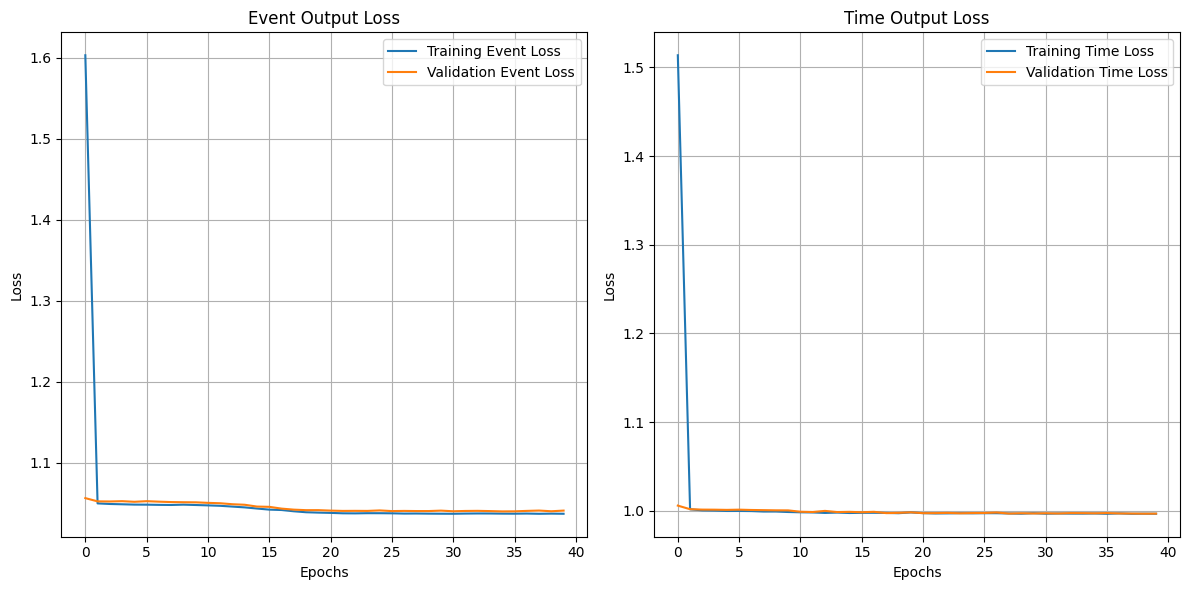

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_3' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_4' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_5' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ current_event             │ (None, 800, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time (InputLayer)         │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ event (InputLayer)        │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ type (InputLayer)         │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ result (InputLayer)       │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_12 (NotEqual)   │ (None, 800, 1)         │              0 │ current_event[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster1 (InputLayer)      │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster2 (InputLayer)      │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_10 (NotEqual)   │ (None, 800, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_11 (NotEqual)   │ (None, 800, 1)         │              0 │ event[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ player (InputLayer)       │ (None, 800, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_13 (NotEqual)   │ (None, 800, 1)         │              0 │ type[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_14 (NotEqual)   │ (None, 800, 1)         │              0 │ result[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_6 (Masking)       │ (None, 800, 1)         │              0 │ current_event[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_6 (Any)               │ (None, 800)            │              0 │ not_equal_12[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 800, 1, 16)     │        919,232 │ roster1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 800, 1, 16)     │        919,232 │ roster2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_4 (Masking)       │ (None, 800, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_4 (Any)               │ (None, 800)            │              0 │ not_equal_10[0][0]     │
├──────────────────────

 Total params: 2,468,210 (9.42 MB)

 Trainable params: 2,468,210 (9.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.3367 - loss: 7.0175 - val_accuracy: 0.3752 - val_loss: 4.5628
Epoch 2/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.3756 - loss: 4.4201 - val_accuracy: 0.3752 - val_loss: 4.3080
Epoch 3/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.3758 - loss: 4.2801 - val_accuracy: 0.3752 - val_loss: 4.2723
Epoch 4/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.3763 - loss: 4.2416 - val_accuracy: 0.3757 - val_loss: 4.2547
Epoch 5/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.3860 - loss: 4.2353 - val_accuracy: 0.3972 - val_loss: 4.2439
Epoch 6/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.3984 - loss: 4.2128 - val_accuracy: 0.3973 - val_loss: 4.2400
Epoch 7/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.3971 - loss: 4.2266 - val_accuracy: 0.3973 - val_loss: 4.2378
Epoch 8/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.3983 - loss: 4.2047 - val_accu

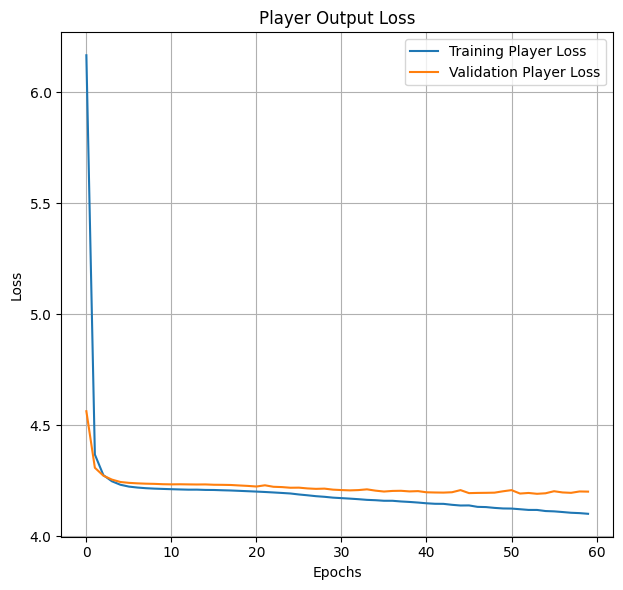

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_6' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_7' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_8' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ time (InputLayer)         │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ type (InputLayer)         │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ result (InputLayer)       │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster1 (InputLayer)      │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster2 (InputLayer)      │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_19 (NotEqual)   │ (None, 400, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ player (InputLayer)       │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_21 (NotEqual)   │ (None, 400, 1)         │              0 │ type[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_20 (NotEqual)   │ (None, 400, 1)         │              0 │ result[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ current_player            │ (None, 400, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 400, 1, 16)     │        919,232 │ roster1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 400, 1, 16)     │        919,232 │ roster2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_9 (Masking)       │ (None, 400, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_9 (Any)               │ (None, 400)            │              0 │ not_equal_19[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, 400, 1, 16)     │         29,984 │ player[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_11 (Masking)      │ (None, 400, 1)         │              0 │ type[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_11 (Any)              │ (None, 400)            │              0 │ not_equal_21[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_10 (Masking)      │ (None, 400, 1)         │              0 │ result[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_10 (Any)              │ (None, 400)            │              0 │ not_equal_20[0][0]     │
├──────────────────────

 Total params: 2,264,261 (8.64 MB)

 Trainable params: 2,264,261 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.4005 - loss: 1.6028 - val_accuracy: 0.4443 - val_loss: 1.5900
Epoch 2/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4518 - loss: 1.5853 - val_accuracy: 0.4576 - val_loss: 1.5741
Epoch 3/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4570 - loss: 1.5679 - val_accuracy: 0.4603 - val_loss: 1.5583
Epoch 4/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.4626 - loss: 1.5503 - val_accuracy: 0.4608 - val_loss: 1.5425
Epoch 5/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4592 - loss: 1.5342 - val_accuracy: 0.4609 - val_loss: 1.5267
Epoch 6/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4620 - loss: 1.5161 - val_accuracy: 0.4609 - val_loss: 1.5108
Epoch 7/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4609 - loss: 1.4996 - val_accuracy: 0.4609 - val_loss: 1.4949
Epoch 8/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4604 - loss: 1.4827 - val_accuracy: 0.4609 - v

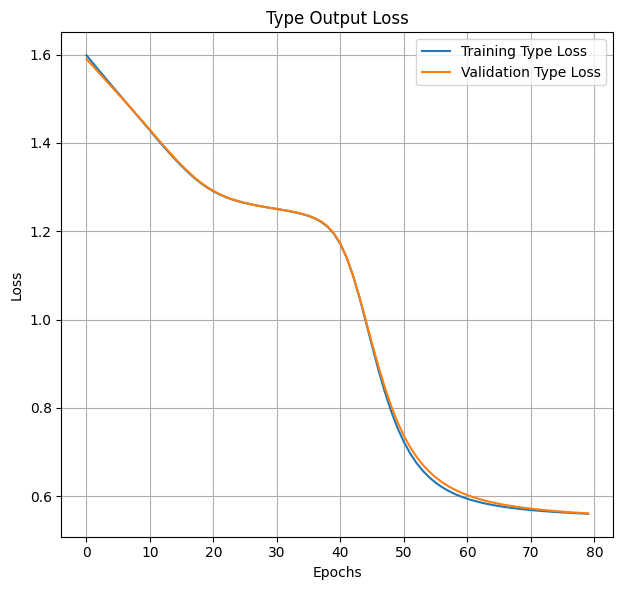

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_10' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_11' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_12' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packag

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ time (InputLayer)         │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ type (InputLayer)         │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ result (InputLayer)       │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ current_player            │ (None, 400, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster1 (InputLayer)      │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster2 (InputLayer)      │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_26 (NotEqual)   │ (None, 400, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ player (InputLayer)       │ (None, 400, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_27 (NotEqual)   │ (None, 400, 1)         │              0 │ type[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_28 (NotEqual)   │ (None, 400, 1)         │              0 │ result[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_29 (NotEqual)   │ (None, 400, 1)         │              0 │ current_player[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 400, 1, 16)     │        919,232 │ roster1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 400, 1, 16)     │        919,232 │ roster2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_12 (Masking)      │ (None, 400, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_12 (Any)              │ (None, 400)            │              0 │ not_equal_26[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, 400, 1, 16)     │         29,984 │ player[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_13 (Masking)      │ (None, 400, 1)         │              0 │ type[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_13 (Any)              │ (None, 400)            │              0 │ not_equal_27[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_14 (Masking)      │ (None, 400, 1)         │              0 │ result[0][0]           │
├──────────────────────

 Total params: 2,264,773 (8.64 MB)

 Trainable params: 2,264,773 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/90
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.2504 - loss: 1.5923 - val_accuracy: 0.3947 - val_loss: 1.5762
Epoch 2/90
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4163 - loss: 1.5712 - val_accuracy: 0.4375 - val_loss: 1.5560
Epoch 3/90
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4480 - loss: 1.5507 - val_accuracy: 0.4566 - val_loss: 1.5363
Epoch 4/90
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4595 - loss: 1.5304 - val_accuracy: 0.4609 - val_loss: 1.5170
Epoch 5/90
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4605 - loss: 1.5106 - val_accuracy: 0.4609 - val_loss: 1.4979
Epoch 6/90
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4615 - loss: 1.4910 - val_accuracy: 0.4609 - val_loss: 1.4792
Epoch 7/90
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.4610 - loss: 1.4723 - val_accuracy: 0.4609 - val_loss: 1.4606
Epoch 8/90
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.4597 - loss: 1.4536 - val_accuracy: 0.4609 - v

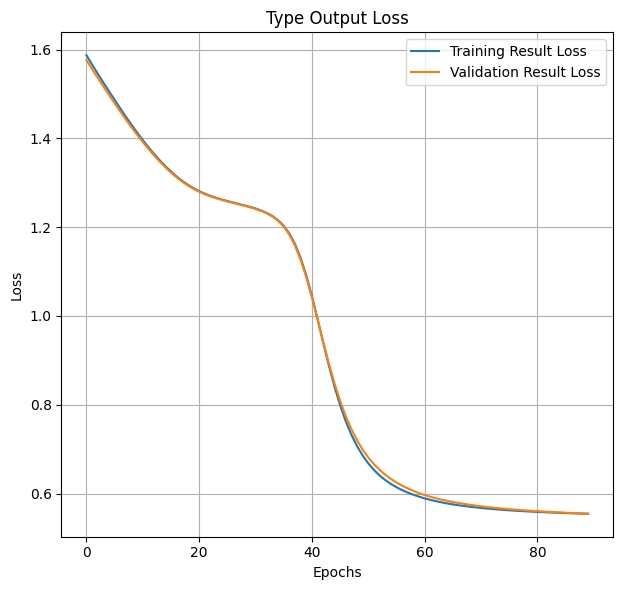

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_14' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_15' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'reshape_16' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packag

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ time (InputLayer)         │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ result (InputLayer)       │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster1 (InputLayer)      │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roster2 (InputLayer)      │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_34 (NotEqual)   │ (None, 200, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ player (InputLayer)       │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_35 (NotEqual)   │ (None, 200, 1)         │              0 │ result[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ current_player            │ (None, 200, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 200, 1, 16)     │        919,232 │ roster1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_15 (Embedding)  │ (None, 200, 1, 16)     │        919,232 │ roster2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_16 (Masking)      │ (None, 200, 1)         │              0 │ time[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_16 (Any)              │ (None, 200)            │              0 │ not_equal_34[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_16 (Embedding)  │ (None, 200, 1, 16)     │         29,984 │ player[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_17 (Masking)      │ (None, 200, 1)         │              0 │ result[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_17 (Any)              │ (None, 200)            │              0 │ not_equal_35[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ season (InputLayer)       │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ playoff (InputLayer)      │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_17 (Embedding)  │ (None, 200, 1, 16)     │         29,984 │ current_player[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_14 (Reshape)      │ (None, 200, 16)        │              0 │ embedding_14[0][0]     │
├──────────────────────

 Total params: 2,265,039 (8.64 MB)

 Trainable params: 2,265,039 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.1960 - loss: 2.6920 - val_accuracy: 0.7682 - val_loss: 2.6713
Epoch 2/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7744 - loss: 2.6694 - val_accuracy: 0.7824 - val_loss: 2.6488
Epoch 3/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7831 - loss: 2.6458 - val_accuracy: 0.7824 - val_loss: 2.6250
Epoch 4/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7840 - loss: 2.6214 - val_accuracy: 0.7824 - val_loss: 2.5995
Epoch 5/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7854 - loss: 2.5950 - val_accuracy: 0.7824 - val_loss: 2.5718
Epoch 6/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7850 - loss: 2.5657 - val_accuracy: 0.7824 - val_loss: 2.5412
Epoch 7/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7845 - loss: 2.5336 - val_accuracy: 0.7824 - val_loss: 2.5069
Epoch 8/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7832 - loss: 2.4969 - val_accuracy: 0.7824 - v

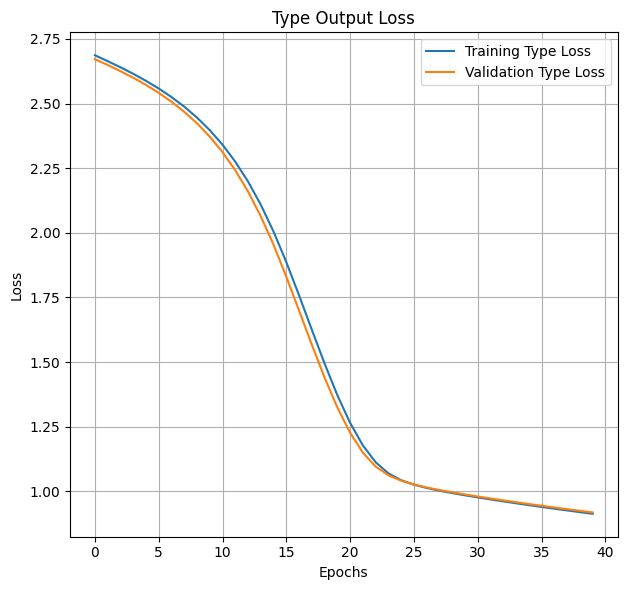

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

{'team1_points_actual': 81, 'team2_points_actual': 79, 'team1_points_predicted': 60, 'team2_points_predicted': 69, 'winner_actual': 'Team1', 'winner_predicted': 'Team2'}
Processing file: /content/data/NBAdata-test/[2008-04-16]-0020701228-MEM@DEN.json
{'team1_points_actual': 65, 'team2_points_actual': 57, 'team1_points_predicted': 75, 'team2_points_predicted': 77, 'winner_actual': 'Team1', 'winner_predicted': 'Team2'}
Processing file: /content/data/NBAdata-test/[2019-02-10]-0021800834-POR@DAL.json
{'team1_points_actual': 69, 'team2_points_actual': 77, 'team1_points_predicted': 63, 'team2_points_predicted': 65, 'winner_actual': 'Team2', 'winner_predicted': 'Team2'}
Processing file: /content/data/NBAdata-test/[2022-03-21]-0022101075-UTA@BKN.json
{'team1_points_actual': 63, 'team2_points_actual': 81, 'team1_points_predicted': 79, 'team2_points_predicted': 80, 'winner_actual': 'Team2', 'winner_predicted': 'Team2'}
Processing file: /content/data/NBAdata-test/[2007-02-15]-0020600789-CLE@LAL.j

In [ ]:
import ijson
import json
from IPython.display import clear_output

class Controller:
    def __init__(self):
        self.data = self.read_file('/content/data/NBADATA.json')
        self.split_index = 0.95
        self.event_predictor = EventPredictor(data=self.data, split_index=self.split_index)
        self.player_predictor = PlayerPredictor(data=self.data, split_index=self.split_index)
        self.shot_type_predictor = ShotTypePredictor(data=self.data, split_index=self.split_index)
        self.shot_result_predictor = ShotResultPredictor(data=self.data, split_index=self.split_index)
        self.foul_type_predictor = FoulPredictor(data=self.data, split_index=self.split_index)
        self.accumulated_results = []

        # self.turnover_type_predictor = TurnoverPredictor(data=self.data, split_index=self.split_index)
        # self.substitution_predictor = SubstitutionPredictor(data=self.data, split_index=self.split_index)
        self.load_vocabs()

    def load_models(self):
        self.event_predictor = EventPredictor(data=self.data, split_index=self.split_index)
        self.player_predictor = PlayerPredictor(data=self.data, split_index=self.split_index)
        self.shot_type_predictor = ShotTypePredictor(data=self.data, split_index=self.split_index)
        self.shot_result_predictor = ShotResultPredictor(data=self.data, split_index=self.split_index)
        self.foul_type_predictor = FoulPredictor(data=self.data, split_index=self.split_index)

    def load_vocabs(self):
        # Load vocabularies
        self.rosters_vocab_path = '/content/data/languages/rosters_vocab.json'
        with open(self.rosters_vocab_path, 'r') as f:
            self.rosters_vocab = json.load(f)

        self.player_vocab_path = '/content/data/languages/player_vocab.json'
        with open(self.player_vocab_path, 'r') as f:
            self.player_vocab = json.load(f)

        self.event_vocab_path = '/content/data/languages/event_vocab.json'
        with open(self.player_vocab_path, 'r') as f:
            self.event_vocab = json.load(f)

        self.type_vocab_path = '/content/data/languages/type_vocab.json'
        with open(self.type_vocab_path, 'r') as f:
            self.type_vocab = json.load(f)

        self.result_vocab_path = '/content/data/languages/result_vocab.json'
        with open(self.result_vocab_path, 'r') as f:
            self.result_vocab = json.load(f)

        self.season_vocab_path = '/content/data/languages/season_vocab.json'
        with open(self.season_vocab_path, 'r') as f:
            self.season_vocab = json.load(f)

    def read_file(self, file_path):
        data = {'gameId': [], 'roster1': [], 'roster2': [], 'time': [], 'event': [], 'player': [], 'type': [], 'result': [], 'season': [], 'playoff': []}

        with open(file_path, 'r') as file:
            items = ijson.items(file, 'item')
            for line in tqdm(items, desc="Processing file", unit="line"):
                for item in line:
                    data['gameId'].append(item['gameId'])
                    data['roster1'].append(rosters_vocab[hash_roster(item['roster1'])])
                    data['roster2'].append(rosters_vocab[hash_roster(item['roster2'])])
                    data['time'].append(item['time'])
                    data['event'].append(event_vocab[item['event']])
                    data['player'].append(player_vocab[item['player']])
                    data['type'].append(type_vocab[item['type']])
                    data['result'].append(result_vocab[item['result']])
                    data['season'].append(season_vocab[item['season']])
                    data['playoff'].append(item['playoff'])
        return pd.DataFrame(data)

    def train_models(self):
        self.event_predictor.train()
        self.player_predictor.train()
        self.shot_type_predictor.train()
        self.shot_result_predictor.train()
        self.foul_type_predictor.train()
        # self.turnover_type_predictor.train()
        # self.substitution_predictor.train()

    def predict_game(self, file_path):
        game_on = True
        season = ''
        playoff = 0
        team1_points = 0
        team2_points = 0
        all_roster1 = set()
        all_roster2 = set()

        with open(file_path, 'r') as file:
            # Load the entire JSON content
            plays = json.load(file)

        # Process the first play
        first_play = plays[0]
        season = first_play['season']
        playoff = first_play['playoff']
        self.roster1_in = first_play['roster1']
        self.roster2_in = first_play['roster2']

        # Process the rest of the plays
        for play in plays:
            all_roster1.update(play['roster1'])
            all_roster2.update(play['roster2'])

            if play['event'] == 'shot':
                points = 0
                if play['result'] == 'made':
                    if play['type'] == '2pt':
                        points = 2
                    elif play['type'] == '3pt':
                        points = 3
                    elif play['type'] == 'free throw':
                        points = 1

                    if play['player'] in self.player_vocab and self.player_vocab[play['player']] in self.roster1_in:
                        team1_points += points
                    elif play['player'] in self.player_vocab and self.player_vocab[play['player']] in self.roster2_in:
                        team2_points += points

        # Determine roster1_out and roster2_out
        self.roster1_out = list(all_roster1 - set(self.roster1_in))
        self.roster2_out = list(all_roster2 - set(self.roster2_in))

        winner_actual = ''
        if team1_points > team2_points:
            winner_actual = 'Team1'
        else:
            winner_actual = 'Team2'

        # Generate Prediction
        self.game = Game(self.roster1_in, self.roster2_in, self.season_vocab[season], playoff)
        end_threshold = 2800
        self.time = 1
        self.team1_pred_score = 0
        self.team2_pred_score = 0

        self.possession = 0

        winner_predicted = ''

        def predict_rebound(self):
            both_teams = self.roster1_in + self.roster2_in

            event_instance = 4

            # Sample player
            player_instance = self.player_predictor.predict_player(self.game.player_prediction(), both_teams)
            self.game.add_current_player(player_instance)

            type_instance = 0
            result_instance = 0
            if player_instance in self.roster1_in:
                if self.possession == 0:
                    type_instance = 20
                    result_instance = 8
                else:
                    type_instance = 21
                    self.possession = 1
                    result_instance = 7
            elif player_instance in self.roster2_in:
                if self.possession == 0:
                    type_instance = 21
                    self.possession = 0
                    result_instance = 7
                else:
                    type_instance = 20
                    result_instance = 8

            self.game.add_current_type(type_instance)
            self.game.add_next(self.roster1_in, self.roster2_in, event_instance, self.time, player_instance, type_instance, result_instance)

        def generate_free_throws(self, point_gain, player):
            for x in range(0, point_gain):
                event_instance = 2
                self.game.add_current_event(event_instance)
                player_instance = player
                self.game.add_current_player(player_instance)
                type_instance = 5
                self.game.add_current_type(type_instance)
                shot_result_instance = self.shot_result_predictor.predict_shot_result(self.game.shot_result_prediction(), [2, 3])

                if shot_result_instance == 2:
                    if self.possession == 0:
                        self.team1_pred_score += 1
                    else:
                        self.team2_pred_score += 1
                shot_result_instance += 1

                self.game.add_next(self.roster1_in, self.roster2_in, event_instance, self.time, player_instance, type_instance, shot_result_instance)

            if self.possession == 0:
                self.possession = 1
            else:
                self.possession = 0

        while game_on:
            event_instance, time_advance = self.event_predictor.predict_event_time(self.game.event_prediction(), [2, 3, 4, 6, 8])
            self.time += time_advance

            # Check for end of game
            if self.time > end_threshold:
                if self.team1_pred_score == self.team2_pred_score:
                    end_threshold += 300
                else:
                    if self.team1_pred_score > self.team2_pred_score:
                        winner_predicted = 'Team1'
                    else:
                        winner_predicted = 'Team2'
                    game_on = False
                    break

            # Event is a shot
            if event_instance == 2:
                self.game.add_current_event(event_instance)

                # Sample player
                if self.possession == 0:
                    player_instance = self.player_predictor.predict_player(self.game.player_prediction(), self.roster1_in)
                    self.game.add_current_player(player_instance)

                else:
                    player_instance = self.player_predictor.predict_player(self.game.player_prediction(), self.roster1_in)
                    self.game.add_current_player(player_instance)


                # Sample shot type
                point_gain = 0
                shot_type_instance = self.shot_type_predictor.predict_shot_type(self.game.shot_type_prediction(), [2, 3])
                if shot_type_instance == 2:
                    point_gain += 2
                else:
                    point_gain += 3
                shot_type_instance += 1

                self.game.add_current_type(shot_type_instance)

                # Sample shot result
                # TODO: Implement blocks
                shot_result_instance = self.shot_result_predictor.predict_shot_result(self.game.shot_result_prediction(), [2, 3])
                if shot_result_instance == 2:
                    if self.possession == 0:
                        self.team1_pred_score += point_gain
                    else:
                        self.team2_pred_score += point_gain
                shot_result_instance += 1

                self.game.add_next(self.roster1_in, self.roster2_in, event_instance, self.time, player_instance, shot_type_instance, shot_result_instance)

                if shot_result_instance == 4:
                    event_instance, time_advance = self.event_predictor.predict_event_time(self.game.event_prediction(), [5, 6])
                    self.time += time_advance
                    self.game.add_current_event(event_instance)

                    # Event is a foul
                    if event_instance == 6:
                        both_teams = self.roster1_in + self.roster2_in

                        # Sample player
                        last_player = player_instance
                        player_instance = self.player_predictor.predict_player(self.game.player_prediction(), both_teams)
                        self.game.add_current_player(player_instance)

                        type_instance = 0
                        # Sample foul
                        if player_instance in self.roster1_in:
                            if self.possession == 0:
                                type_instance = self.foul_type_predictor.predict_foul_type(self.game.foul_type_prediction(), [6, 10])
                            else:
                                type_instance = self.foul_type_predictor.predict_foul_type(self.game.foul_type_prediction(), [4, 6, 10])
                        else:
                            if self.possession == 0:
                                type_instance = self.foul_type_predictor.predict_foul_type(self.game.foul_type_prediction(), [4, 6, 10])
                            else:
                                type_instance = self.foul_type_predictor.predict_foul_type(self.game.foul_type_prediction(), [6, 10])

                        type_instance += 3
                        self.game.add_current_type(type_instance)

                        if (type_instance == 7):
                            result_instance = 10
                            self.game.add_next(self.roster1_in, self.roster2_in, event_instance, self.time, player_instance, type_instance, result_instance)
                            generate_free_throws(self, point_gain, last_player)
                        else:
                            result_instance = 13
                            self.game.add_next(self.roster1_in, self.roster2_in, event_instance, self.time, player_instance, type_instance, result_instance)
                            if player_instance in self.roster1_in:
                                if self.possession == 0:
                                    self.possession = 1
                                else:
                                    self.possession = 0
                    # Event is a rebound
                    else:
                        predict_rebound(self)
                else:
                    if self.possession == 0:
                        self.possession = 1
                    else:
                        self.possession = 0

            elif event_instance == 3:
                self.time += time_advance
                pass
            elif event_instance == 4:
                self.time += time_advance
                pass
            elif event_instance == 6:
                self.time += time_advance
                pass
            elif event_instance == 8:
                self.time += time_advance
                pass

        # After game ends, add to accumulated results
        result = f"File: {file_path}, Winner Actual: {winner_actual}, Winner Predicted: {winner_predicted}"
        self.accumulated_results.append(result)

        return {
            'team1_points_actual': team1_points,
            'team2_points_actual': team2_points,
            'team1_points_predicted': self.team1_pred_score,
            'team2_points_predicted': self.team2_pred_score,
            'winner_actual': winner_actual,
            'winner_predicted': winner_predicted
        }


    def test(self, file_path='/content/data/NBAdata-test'):
        team1_actual_scores = []
        team2_actual_scores = []
        team1_predicted_scores = []
        team2_predicted_scores = []
        winner_actual_list = []
        winner_predicted_list = []

        # Iterate through each file in the directory
        for filename in os.listdir(file_path):
            file_full_path = os.path.join(file_path, filename)

            # Ensure it's a file and not a subdirectory
            if os.path.isfile(file_full_path):
                print(f"Processing file: {file_full_path}")
                result = self.predict_game(file_full_path)

                print(result)

                # Collect scores for standard deviation calculation
                team1_actual_scores.append(result['team1_points_actual'])
                team2_actual_scores.append(result['team2_points_actual'])
                team1_predicted_scores.append(result['team1_points_predicted'])
                team2_predicted_scores.append(result['team2_points_predicted'])

                # Collect actual and predicted winners
                winner_actual_list.append(result['winner_actual'])
                winner_predicted_list.append(result['winner_predicted'])

        # Calculate standard deviations
        team1_std_dev = np.std(np.array(team1_actual_scores) - np.array(team1_predicted_scores))
        team2_std_dev = np.std(np.array(team2_actual_scores) - np.array(team2_predicted_scores))

        # Calculate percentage of correct predictions
        correct_predictions = sum(1 for actual, predicted in zip(winner_actual_list, winner_predicted_list) if actual == predicted)
        total_predictions = len(winner_predicted_list)
        correct_percentage = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

        # Print results
        print("\nSummary:")
        print(f"Standard Deviation (Team 1 Scores): {team1_std_dev:.2f}")
        print(f"Standard Deviation (Team 2 Scores): {team2_std_dev:.2f}")
        print(f"Percentage of Correct Predictions: {correct_percentage:.2f}%")

controller = Controller()
controller.train_models()
controller.test()

In [ ]:
!cp "/content/your_notebook_name.ipynb" "/content/drive/My Drive/saved_notebook.ipynb"

# Future

Create a tool that makes the JSON data into a box score.

The box score should have players names by their time (seconds), points, assists, rebounds, blocks, steals, turnovers, fouls, fg, 3pt, ft. Example of NBA Box Score: https://www.espn.com/nba/boxscore/_/gameId/401704662

The tool also needs to determine the score of the game.

**Box Score**

In [ ]:
# TODO: need to be more precise on Free Throws, currently not getting them rn. Need to ensure all data that can be on a boxcard is extracted here.

import json
from collections import defaultdict
from tabulate import tabulate

# Helper function for rounding minutes
def round_player_minutes(stats):
  for player, player_stats in stats.items():
    if "min" in player_stats:
      player_stats["min"] = round(player_stats["min"], 0)

# Initialize player statistics
def create_player_stats():
    return {
        "points": 0,
        "assists": 0,
        "rebounds": 0,
        "blocks": 0,
        "steals": 0,
        "turnovers": 0,
        "fouls": 0,
        "fg_made": 0,
        "fg_attempted": 0,
        "fg_missed": 0,
        "3pt_made": 0,
        "3pt_attempted": 0,
        "3pt_missed": 0,
        "ft_made": 0,
        "ft_attempted": 0,
        "ft_missed": 0,
        "min": 0
    }

# Process a single JSON event entry to update player stats
def process_event(event, stats, team_scores, active_players, last_event_time):
    player = event.get("player", "")
    event_type = event.get("event")
    event_result = event.get("result")
    event_detail = event.get("type")

    # Skip if the player field is empty
    if not player:
        return last_event_time

    # Check team for the player
    team = "Team1" if player in event.get("roster1", []) else "Team2"

    if player not in stats:
        stats[player] = create_player_stats()

    if event_type == "shot":
        if event_detail == "2pt":
            stats[player]["fg_attempted"] += 1
            if event_result == "made":
                stats[player]["points"] += 2
                stats[player]["fg_made"] += 1
                team_scores[team] += 2
            elif event_result == "missed":
                stats[player]["fg_missed"] += 1

        elif event_detail == "3pt":
            stats[player]["3pt_attempted"] += 1

            if event_result == "made":
                stats[player]["points"] += 3
                stats[player]["3pt_made"] += 1
                stats[player]["fg_made"] += 1
                team_scores[team] += 3

            elif event_result == "missed":
                stats[player]["3pt_missed"] += 1

        elif event_detail == "free throw":
          stats[player]["ft_attempted"] += 1

          if event_result == "made":
            stats[player]["points"] += 1
            stats[player]["ft_made"] += 1
            team_scores[team] += 1

          elif event_result == "missed":
            stats[player]["ft_missed"] += 1

    elif event_type == "assist":
        stats[player]["assists"] += 1

    elif event_type == "rebound":
        stats[player]["rebounds"] += 1

    elif event_type == "block":
        stats[player]["blocks"] += 1

    elif event_type == "turnover":
        stats[player]["turnovers"] += 1
        if event_result == "steal":
          stats[player]["steals"] += 1

    elif event_type == "foul" and event_detail == "personal":
        stats[player]["fouls"] += 1

    # Will need to update parser to get more details on whether or not a freethrow was made/missed
    current_time = event.get("time") / 60 # Convert to minutes

    if active_players:
        elapsed_time = (current_time - last_event_time)
        for active_player in active_players:
            if active_player in stats:
                stats[active_player]["min"] += elapsed_time

    if event_type == "substitution":
        substituted_out = event.get("substituted_out", "")
        if substituted_out in active_players:
            active_players.remove(substituted_out)
        active_players.add(player)

    return current_time

# Generate a box score table
def generate_box_score(events):
    stats = {}
    team_scores = defaultdict(int)  # Track scores for each team

    # make set here
    active_players = set()
    last_event_time = 0

    # Process each event
    for event in events:
        last_event_time = process_event(event, stats, team_scores, active_players, last_event_time)

    # round minutes
    round_player_minutes(stats)

    # Format stats for output of all individual players
    box_score = [
        [player,
        stat["min"],
        f"{stat['fg_missed']}-{stat['fg_made']}",  # Combine made / missed
        f"{stat['3pt_missed']}-{stat['3pt_made']}",
        f"{stat['ft_made']}-{stat['ft_missed']}",
        stat["rebounds"],
        stat["assists"],
        stat["steals"],
        stat["blocks"],
        stat["turnovers"],
        stat["fouls"],
        stat["points"]
        ]
        for player, stat in stats.items()
    ]
    headers = [
        "Player",
        "MIN", # minutes
        "FG",  # field goal?
        "3PT",  # 3 pointer
        "FT",  # free throw
        "REB", # rebounds
        "AST", # assists
        "STL", # steals
        "BLK", # blocks
        "TO", # turnovers
        "PF", # personal fouls
        "PTS" #points
    ]

    # Separate stats by team
    team1_box_score = [row for row in box_score if any(player in event.get("roster1", []) for player in row)]
    team2_box_score = [row for row in box_score if any(player in event.get("roster2", []) for player in row)]

    return team1_box_score, team2_box_score, headers, team_scores

directory = '/content/data/NBAdata'
json_files = [f for f in os.listdir(directory) if f.endswith('.json')]
box_score_count = 0

for json_file in json_files:
    with open(os.path.join(directory, json_file)) as f:
        events = [json.loads(line) for line in f if line.strip()]  # Only include non-empty lines

    team1_box_score, team2_box_score, headers, team_scores = generate_box_score(events)

    if box_score_count < 3: # Just print 3 box_scores
        print(f"Box Score for {json_file}:\n")

        # Team 1 box score
        print("Team 1:")
        print(tabulate(team1_box_score, headers=headers))

        print("-" * 95)

        # Team 2 box score
        print("Team 2:")
        print(tabulate(team2_box_score, headers=headers))

        print("\nTeam Scores:")
        for team, score in team_scores.items():
            print(f"{team}: {score}")
        print("\n" + "/" * 100)
        print("\n" + "/" * 100 + "\n")

        box_score_count += 1
    else:
        break


Box Score for 2017regularLAC@GSW1-28.json:

Team 1:
Player            MIN  FG    3PT    FT      REB    AST    STL    BLK    TO    PF    PTS
--------------  -----  ----  -----  ----  -----  -----  -----  -----  ----  ----  -----
Raymond Felton     25  3-3   3-2    2-0       7      5      2      1     5     1     10
Jamal Crawford     27  3-2   2-1    0-0       1      2      1      0     3     3      5
Brandon Bass       32  2-4   0-0    1-1       5      2      1      0     2     0      9
Alan Anderson       0  1-2   1-2    0-0       0      1      0      0     0     0      6
Diamond Stone       0  1-1   0-0    2-0       1      0      0      0     0     0      4
-----------------------------------------------------------------------------------------------
Team 2:
Player                  MIN  FG    3PT    FT      REB    AST    STL    BLK    TO    PF    PTS
--------------------  -----  ----  -----  ----  -----  -----  -----  -----  ----  ----  -----
Patrick McCaw            29  0-2   3-1  